Contains HM Land Registry data © Crown copyright and database right 2021. This data is licensed under the [Open Government Licence v3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

Contains OS data © Crown copyright and database right 2022\
Contains Royal Mail data © Royal Mail copyright and database right 2022\
Contains National Statistics data © Crown copyright and database right 2022

# Assessment for Advanced Data Science

## Christian Cabrera, Carl Henrik Ek and Neil D. Lawrence

### 29th October 2021



<font color="gray">Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices.</font>

<font color="gray">Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  </font>

<font color="gray">To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.</font>

<font color="gray">Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code. </font>

<font color="gray">Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)</font>

<font color="gray">The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total.</font>


### <font color="gray">Useful Links</font>

<font color="gray">You may find some of the following links useful when building your system.</font>

<font color="gray">University instuctions on Security and Privacy with AWS.</font>

<font color="gray">https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy</font>

<font color="gray">Security Rules in AWS </font>

<font color="gray">https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4</font>

## Prelude: Jacky's Conventions
There are two tables in AWS: `pp_data` and `postcode_data`. 
- When referring to them in code, I'll call them `ppdata` and `podata` respectively. (e.g. `df_ppdata` refers to a dataframe containing rows from the `pp_data` table)
- When referring to the join of the above two in code, I'll call it `pppodata`. (e.g. `df_pppodata` is the join of `df_ppdata` and `df_podata`).

Also, throughout this notebook, text in gray come from the original notebook. Text in black are written by me.

### Installing Your Library

<font color="gray">One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.</gray>

<font color="gray">You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below. </gray>



In [5]:
# Install your library here, for example the fynesse template is set up to be pip installable
%pip uninstall -q --yes fynesse
%pip install -q --no-cache-dir git+https://github.com/jackykwe/uoa-ads-assessment.git

     |████████████████████████████████| 9.4 MB 4.9 MB/s 


<font color="gray">Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).</font>

In [6]:
%pip uninstall -q --yes matplotlib
%pip install -q --no-deps matplotlib==3.1.3  # otherwise plotting won't work; --no-deps to suppress incompatible warning

In [1]:
# Sanity check
%pip show osmnx | grep Version # ensure at least 1.2.2
%pip show matplotlib | grep Version # ensure exactly 3.1.3

Version: 1.2.2
Version: 3.1.3


I require that users first specify the credentials in `credentials.yaml` before importing my library, because the credentials are used as default arguments when defining functions that communicate with AWS. When not used in a notebook, the `credentials.yaml` file is expected to be present in the package's directory, just like configuration/environment files used in a typical software project.

In [2]:
import yaml
from ipywidgets import interact_manual, Text, Password

# Write code for requesting and storing credentials (username, password) here. 

@interact_manual(username=Text(description="Username:"), 
                 password=Password(description="Password:"))
def write_credentials(username, password):
    with open("credentials.yaml", "w") as file:
        credentials_dict = {'username': username, 
                            'password': password}
        yaml.dump(credentials_dict, file)

interactive(children=(Text(value='', description='Username:'), Password(description='Password:'), Button(descr…

In [3]:
from fynesse import constants, utils, aws_utils, aws_init, access, assess, address

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

<font color="gray">The UK price paid data for housing in dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*. </font>

<font color="gray">Using the following ideas.</font>

1. <font color="gray">A cloud hosted database (such as MariaDB hosted on the AWS RDS service).</font>
2. <font color="gray">The SQL language wrapped in appropriately structured python code.</gray>
3. <font color="gray">Joining of two databases.</font>

<font color="gray">You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.</font>

<font color="gray">You will likely find the following resources helpful.</font>

1. <font color="gray">Lecture 1, 2 and 3.</font>
2. <font color="gray">Lab class 1 and 2.</font>
3. <font color="gray">The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads></font>
4. <font color="gray">The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo></font>

<font color="gray">Below we provide codeboxes and hints to help you develop your answer.</gray>

<font color="gray">*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (11th November 2021). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*</gray>

<font color="gray">*5 Marks*</gray>

### Task A

<font color="gray">Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository.</font>

<font color="gray">Call the database you use for this assessment `property_prices`.</font>
  

In [4]:
# Write code for requesting and storing credentials (username, password) here. 

# This is done above, before importing fynesse.

In [5]:
# Write any other setup code you need for setting up database access here.

aws_init.init_create_database_if_not_exists()

Database property_prices already exists, not re-created.


This function basically runs the following SQL query, wrapped up as a Python function:
```sql
SET SQL_MODE = "NO_AUTO_VALUE_ON_ZERO";
SET time_zone = "+00:00";
DROP DATABASE IF EXISTS `{new_database_name}`;  -- only if drop_before_create=True
CREATE DATABASE IF NOT EXISTS `{new_database_name}` DEFAULT CHARACTER SET utf8 COLLATE utf8_bin;
```

### Task B

<font color="gray">Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using </gray>

```
LOCAL DATA LOAD INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```
<font color="gray">*Note* this command should be wrapped and placed in an appropriately structured python module. </gray>

<font color="gray">Each 'data part' should be downloadable from the `gov.uk` site and uploadable to your database instance in a couple of seconds. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in a matter of minutes. </gray>

<font color="gray">You may find the following schema useful in creation of your database:</gray>

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
<font color="gray">This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql></gray>

<font color="gray">You may also find it helpful to set up the following indexes in the database</gray>

```
--
-- Indexes for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
CREATE INDEX `pp.postcode` USING HASH
  ON `pp_data`
    (postcode);
CREATE INDEX `pp.date` USING HASH
  ON `pp_data` 
    (date_of_transfer);
```


<font color="gray">In the box below, briefly describe what the schema is doing and why we will find it useful to create the indexes we have for the table we've created.</gray>

The schema is defining the relational database table's column names and types. Relational databases require that table schemae are defined before insertion of data, so that records in the database can be checked for type correctness. This is important for database consistency (C in ACID properties).

Additionally, during the address aspect (when doing predictions), we'd need to query a subset of the database using `WHERE` SQL clauses. These queries are greatly sped up if the `WHERE` conditions involve indexes. 

For `pp_data`, because we want to be able to query rows based on `property_type` and `date` quickly, I've added indexes for them. The index on `postcode` is there in case because we'll be joining `pp_data` with `postcode_data` (Task C) on the `postcode` column, and we want the join to be quick.

In [6]:
# Write the code you need for creating the database table and uploading the data here.

# Non-idempotent operation, commented out to prevent accidenal execution
# aws_init.init_setup_aws_ppdata()

The code logic for the above cell is as follows. The code does the following in sequence:
1. Download the .csv parts form the government website.
2. Cleanup each .csv, by removing rows whose:
   - `postcode` is null (empty string) in the csv\
     Records with a null postcode are not useful at all, because the way we obtain latlongs for each record is by joining with `podata` (Task C) on the postcode column. As such, these null-postcode rows will never be used in our prediction system, and are thus discarded, not even uploaded onto AWS.
   - `tenure_type` is not one of `F` or `L`. \
     It turns out, there exists rows where this field takes the value `U`, but this is not documented on the [government website](https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd) (it's named "Duration" on the website)! I cannot find any documentation for what `U` might mean. A friend who is currently studying Law is also unsure of what `U` means: as far as he knows, there are only 2 kinds of leases. I'll take `U` to mean unknown/undefined (i.e. null), and thus discard these data rows.

    Details of how this cleanup is implemented can be seen via the definition of `access.fix_ppdata()`:
    ```python
    def fix_ppdata(
        dir_name="data/ppdata",
        first_year_inclusive=constants.FIRST_YEAR_INCLUSIVE,
        final_year_inclusive=constants.FINAL_YEAR_INCLUSIVE
    ):
        for year in tqdm(range(first_year_inclusive, final_year_inclusive + 1)):
            for part in tqdm((1, 2), leave=False):
                file_name = f"pp-{year}-part{part}.csv"
                file_name_with_dir = os.path.join(dir_name, file_name)
                df_tofix = pd.read_csv(
                    file_name_with_dir,
                    names=PPDATA_COLUMN_NAMES
                )

                # Dropping useless rows
                df_tofix = df_tofix.loc[
                    df_tofix["postcode"].notna() &
                    df_tofix["tenure_type"].isin(["F", "L"])
                ]

                fixed_file_name = f"pp-{year}-part{part}_fixed.csv"
                fixed_file_name_with_dir = os.path.join(dir_name, fixed_file_name)
                df_tofix.to_csv(fixed_file_name_with_dir, header=False,
                                index=False, quoting=csv.QUOTE_ALL)

                del df_tofix  # to prevent OOM; allow GC to collect the object
    ```

```python
def init_setup_aws_ppdata(
    dir_name="data/ppdata",
    first_year_inclusive=constants.FIRST_YEAR_INCLUSIVE,
    final_year_inclusive=constants.FINAL_YEAR_INCLUSIVE
):
    """
    WARNING: Do NOT run more than once. This operation is NOT idempotent.
    """
    print("Downloading ppdata from gov...")
    access.download_ppdata_from_gov(
        dir_name=dir_name,
        first_year_inclusive=first_year_inclusive,
        final_year_inclusive=first_year_inclusive
    )

    # Data cleanup
    print("Fixing ppdata (removing invalid rows)...")
    access.fix_ppdata(
        dir_name=dir_name,
        first_year_inclusive=first_year_inclusive,
        final_year_inclusive=first_year_inclusive
    )

    total_rows_to_upload = 0
    with aws_utils.create_connection(database=constants.DATABASE_NAME) as conn:
        aws_utils.create_new_table_if_not_exists(
            conn,
            constants.PPDATA_TABLE_NAME,
            [
                ("transaction_unique_identifier",
                 "tinytext COLLATE utf8_bin NOT NULL"),
                ("price", "int(10) unsigned NOT NULL"),
                ("date_of_transfer", "date NOT NULL"),
                ("postcode", "varchar(8) COLLATE utf8_bin NOT NULL"),
                ("property_type", "varchar(1) COLLATE utf8_bin NOT NULL"),
                # NB this is modelled as text
                ("new_build_flag", "varchar(1) COLLATE utf8_bin NOT NULL"),
                ("tenure_type", "varchar(1) COLLATE utf8_bin NOT NULL"),
                ("primary_addressable_object_name",
                 "tinytext COLLATE utf8_bin NOT NULL"),
                ("secondary_addressable_object_name",
                 "tinytext COLLATE utf8_bin NOT NULL"),
                ("street", "tinytext COLLATE utf8_bin NOT NULL"),
                ("locality", "tinytext COLLATE utf8_bin NOT NULL"),
                ("town_city", "tinytext COLLATE utf8_bin NOT NULL"),
                ("district", "tinytext COLLATE utf8_bin NOT NULL"),
                ("county", "tinytext COLLATE utf8_bin NOT NULL"),
                ("ppd_category_type", "varchar(2) COLLATE utf8_bin NOT NULL"),
                ("record_status", "varchar(2) COLLATE utf8_bin NOT NULL"),
                # must define primary key here, not after uploading data
                ("db_id", "bigint(20) unsigned NOT NULL AUTO_INCREMENT PRIMARY KEY"),
            ]
        )

        print("Uploading ppdata to AWS...")
        for year in tqdm(range(constants.FIRST_YEAR_INCLUSIVE, constants.FINAL_YEAR_INCLUSIVE + 1)):
            for part in tqdm((1, 2), leave=False):
                file_name_with_dir = os.path.join(
                    dir_name, f"pp-{year}-part{part}fixed.csv"
                )

                tempdf = access.read_ppdata_to_df(
                    year,
                    part,
                    dir_name=dir_name,
                    fixed_version=True
                )
                total_rows_to_upload += len(tempdf)
                del tempdf

                aws_utils.upload_data_into_table(
                    constants.PPDATA_TABLE_NAME,
                    file_name_with_dir
                )

        print("Adding ppdata indexes to AWS...")
        aws_utils.add_table_hash_index(
            conn, "pp.postcode", "pp_data", "postcode"
        )
        aws_utils.add_table_hash_index(
            conn, "pp.property_type", "pp_data", "property_type"
        )
        aws_utils.add_table_btree_index(
            conn, "pp.date", "pp_data", "date_of_transfer"
        )

        print("Successfully uploaded ppdata to AWS.")

        # Sanity checking
        rows_uploaded = aws_utils.aws_get_number_of_rows_in_ppdata()
        print(f"Successfully uploaded ppdata ({rows_uploaded} rows) to AWS.")
        assert rows_uploaded == total_rows_to_upload, f"Expected to upload {total_rows_to_upload} rows, uploaded only {rows_uploaded}"
```

### Task C

<font color="gray">Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).</gray>


<font color="gray">The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use.</gray>

<font color="gray">You may find the following schema useful for the postcode data (developed by Christian and Neil)</gray>

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

<font color="gray">And again you'll want to set up indices for your table.</gray>

```
ALTER TABLE `postcode_data`
ADD PRIMARY KEY (`db_id`);
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
CREATE INDEX `po.postcode` USING HASH
  ON `postcode_data`
    (postcode);
```

<font color="gray">And you can load the CSV file into the table in one "INFILE".</gray>

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```

For `postcode_data`, because we want to be able to query rows based on `date_of_transfer`, `latitude` and `longitude` quickly, I've added indexes for them. The index on `postcode` is there in case because we'll be joining `pp_data` (Task B)  with `postcode_data` on the `postcode` column, and we want the join to be quick.

In [7]:
# Non-idempotent operation, commented out to prevent accidenal execution
# aws_init.init_setup_aws_podata()

The code logic for the above cell is as follows. The code does the following in sequence:
1. Download the .csv parts form the getthedata (`gtd` in code) website.
2. Cleanup the .csv, by removing rows whose:
   - `postcode` is null (empty string) in the csv\
      Same reasoning as in Task B.
   
   Details of how this cleanup is implemented can be seen via the definition of `access.fix_podata()`, which works the same sa `fix_ppdata()` and so isn't shown here.

```python

def init_setup_aws_podata(dir_name="data/podata"):
    """
    WARNING: Do NOT run more than once. This operation is NOT idempotent.
    """
    print("Downloading podata from gtd...")
    aws_utils.download_podata_from_gtd(dir_name=dir_name)

    # Data cleanup
    print("Fixing podata (removing invalid rows)...")
    access.fix_podata(dir_name=dir_name)

    total_rows_to_upload = 0
    with aws_utils.create_connection(database=constants.DATABASE_NAME) as conn:
        aws_utils.create_new_table_if_not_exists(
            conn,
            constants.PODATA_TABLE_NAME,
            [
                ("postcode", "varchar(8) COLLATE utf8_bin NOT NULL"),
                ("status", "enum('live','terminated') NOT NULL"),
                ("usertype", "enum('small', 'large') NOT NULL"),
                ("easting", "int unsigned"),
                ("northing", "int unsigned"),
                ("positional_quality_indicator", "int NOT NULL"),
                ("country", "enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL"),
                ("latitude", "decimal(11,8) NOT NULL"),
                ("longitude", "decimal(10,8) NOT NULL"),
                ("postcode_no_space", "tinytext COLLATE utf8_bin NOT NULL"),
                ("postcode_fixed_width_seven",
                 "varchar(7) COLLATE utf8_bin NOT NULL"),
                ("postcode_fixed_width_eight",
                 "varchar(8) COLLATE utf8_bin NOT NULL"),
                ("postcode_area", "varchar(2) COLLATE utf8_bin NOT NULL"),
                ("postcode_district", "varchar(4) COLLATE utf8_bin NOT NULL"),
                ("postcode_sector", "varchar(6) COLLATE utf8_bin NOT NULL"),
                ("outcode", "varchar(4) COLLATE utf8_bin NOT NULL"),
                ("incode", "varchar(3)  COLLATE utf8_bin NOT NULL"),
                # must define primary key here, not after uploading data
                ("db_id", "bigint(20) unsigned NOT NULL AUTO_INCREMENT PRIMARY KEY"),
            ]
        )

        print("Uploading podata to AWS...")
        for _ in tqdm((1, )):
            file_name_with_dir = os.path.join(
                dir_name, "open_postcode_geo.csv"
            )

            tempdf = access.read_podata_to_df(
                dir_name=dir_name,
                fixed_version=True
            )
            total_rows_to_upload += len(tempdf)
            del tempdf

        aws_utils.upload_data_into_table(
            constants.PODATA_TABLE_NAME,
            file_name_with_dir,
            fields_enclosed_by_char=""
        )

        print("Adding podata indexes to AWS...")
        aws_utils.add_table_hash_index(
            conn, "po.postcode", "postcode_data", "postcode"
        )
        aws_utils.add_table_btree_index(
            conn, "po.date", "postcode_data", "date_of_transfer"
        )
        aws_utils.add_table_btree_index(
            conn, "po.latitude", "postcode_data", "latitude"
        )
        aws_utils.add_table_btree_index(
            conn, "po.longitude", "postcode_data", "longitude"
        )

        # Sanity checking
        rows_uploaded = aws_utils.aws_get_number_of_rows_in_podata()
        print(f"Successfully uploaded ppdata ({rows_uploaded} rows) to AWS.")
        assert rows_uploaded == total_rows_to_upload, f"Expected to upload {total_rows_to_upload} rows, uploaded only {rows_uploaded}"
```

### Task D 

<font color="gray">These data can now be joined to form a new table that contains house price paid and latitude longitude of the house. We could create a new table that contains all this information. However, the computation of that table will take some time because of the size of the two existing tables in the join. </font>

<font color="gray">Instead, we're going to exploit the nature of the task. To build our prediction model, we're going to use the prices for a particular region in a given time period. This means we can select that region and time period and build the joined data only from the relevent rows from the two tables. This will save time on the join.</font>

<font color="gray">Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would likely be better to store the entired database joined, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better. In that case you can make use of an  *inner join* for this data set creation.</font>

```
USE `property_prices`;
--
-- Table structure for table `prices_coordinates_data`
--
DROP TABLE IF EXISTS `prices_coordinates_data`;
CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;


```



Because there are over 20 million rows in the database (`ppdata` ranges from 1995 to 2022 and will only keep growing), it is not feasible to pull all data from the database and store it on any machine at the same time. We therefore perform the join at the database, and then return only the relevant rows.

The code that does this is in `aws_utils.get_pppodata_conditioned()`, and is used as part of the address aspect. Here's its definition (the main interesting thing is the SQL query):
```python
def get_pppodata_conditioned(
    property_type,
    sql_cutoff_earliest_date,
    sql_cutoff_latest_date,
    north,
    south,
    east,
    west
):
    """
    Only rows that satisfy all the following conditions are fetched:
    - rows whose property_type (column name) matches property_type (argument to this function)
    - rows where sql_cutoff_earliest_date <= date_of_transfer (column name) <= sql_cutoff_latest_date
    - rows where south <= latitude (column name) <= north
    - rows where west <= longitude (column name) <= east

    :param property_type: a string, one of "D/S/T/F/O".
    :param sql_cutoff_earliest_date: a string in ISO format.
    :param sql_cutoff_latest_date: a string in ISO format.
    :param north: an int or float.
    :param south: an int or float.
    :param east: an int or float.
    :param west: an int or float.
    """
    with create_connection(database=constants.DATABASE_NAME) as conn:
        with conn.cursor() as cur:
            cur.execute(
                f"""
                SELECT price, date_of_transfer, pp_data.postcode, property_type, new_build_flag, tenure_type, ppd_category_type, usertype, positional_quality_indicator, latitude, longitude FROM pp_data
                INNER JOIN postcode_data ON pp_data.postcode = postcode_data.postcode
                WHERE
                    pp_data.property_type = '{property_type}'
                    AND pp_data.date_of_transfer >= '{sql_cutoff_earliest_date}'
                    AND pp_data.date_of_transfer <= '{sql_cutoff_latest_date}'
                    AND postcode_data.longitude >= {west}
                    AND postcode_data.longitude <= {east}
                    AND postcode_data.latitude >= {south}
                    AND postcode_data.latitude <= {north};
                """
            )
            aws_query_result = cur.fetchall()

    return pd.DataFrame(
        aws_query_result,
        columns=[
            "price",
            "date_of_transfer",
            "postcode",
            "property_type",
            "new_build_flag",
            "tenure_type",
            "ppd_category_type",
            "usertype",
            "positional_quality_indicator",
            "latitude",
            "longitude"
        ]
    )
```
During the address aspect, we'll use this function to grab only relevant rows from AWS. The join is performed using the `INNER JOIN` SQL command.

## Question 2. Accessing OpenStreetMap and Assessing the Available Features

<font color="gray">In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. **We expect that knowledge of the local region around the property should be helpful in making those price predictions.** To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.</font>

<font color="gray">The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below. </font>

<font color="gray">Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, **write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices**. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the lab sessions for visualising features and exploring their correlation, use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.</font>

<font color="gray">The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.</font>

<font color="gray">You should write **reusable code that allows you to explore the characteristics of different points of interest**. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.</font>

<font color="gray">*5 marks*</font>


## Characterising `ppdata` and `podata`
Before we talk about the construction of features, let's look at some properties of the datasets working with.

First we download the datasets. The following two are wrapper functions that download all the data we need.

In [8]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.
access.download_ppdata_from_gov()
access.download_podata_from_gtd()

  0%|          | 0/28 [00:00<?, ?it/s]

The following function does all the statistics gathering and graph plotting from the files we've downloaded above. It's a rather monolithic function, but the basic idea is:
1. Read `podata` in entirety. Drop any null postcode rows if present, because nulls interfere with pandas joining of tables (see warning [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)).
2. Read each `ppdata` fragment (e.g. `[...]1995part1.csv` is considered a fragment, all the way till `[...]2022part2.csv`). Drop any null postcode rows if present, because nulls interfere with pandas joining of tables (see warning [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)).
3. Merge it with `podata`.
4. Gather relevant statistics.
5. Repeat steps 2 to 4 for all fragments.
6. Consolidate gathered statistics and produce plots.

Here are the questions we want answered, to give us a feel of what the dataset is like:
1. **What is the total number of rows in `ppdata` and `podata`?**
2. **Are there rows whose `postcode` is null in `ppdata` and `podata`?**
3. **What is the distribution of *numerical* columns in `ppdata` and `podata`?**\
   We'll plot bar charts to visualise these. Normal scale (y-axis) plots are provided in blue, and log scale (y-axis) plots are provided in red adjacent to the normal scale plots (since for some values, the proportion is exceedingly tiny).

   It's not meaningful to look at distributions of non-numerical columns like `postcode` or `transaction_unique_identifier`.
4. **What is the distribution of `price` for each `property_type`? Any significant differences between them?**\
   We'll plot bar charts to visualise these. Normal scale plots are provided in blue, and log scale plots are provided in red adjacent to the normal scale plots (since for some values, the proportion is exceedingly tiny).

   *Only for these set of graphs, the x-axis for both blue and red graphs will be in log-scale, since a grand majority of prices are less than 1 million, with a few outliers stretching out to around 600 million. (This is informed by the insights to Q5 just below this)*
5. **What is the geographical distribution of price paid data across UK?**\
   We'll plot a geographical heatmap to visualise this.

podata: Gathering statistics...
Dropped 0 null postcode rows from df_podata out of 2610679


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 1995part1] Dropped 299 null postcode rows out of 398430
[ppdata 1995part2] Dropped 269 null postcode rows out of 398430


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 1996part1] Dropped 324 null postcode rows out of 482525
[ppdata 1996part2] Dropped 325 null postcode rows out of 482525


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 1997part1] Dropped 370 null postcode rows out of 547084
[ppdata 1997part2] Dropped 384 null postcode rows out of 547084


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 1998part1] Dropped 363 null postcode rows out of 525120
[ppdata 1998part2] Dropped 361 null postcode rows out of 525121


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 1999part1] Dropped 359 null postcode rows out of 597300
[ppdata 1999part2] Dropped 375 null postcode rows out of 597301


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2000part1] Dropped 449 null postcode rows out of 564542
[ppdata 2000part2] Dropped 467 null postcode rows out of 564542


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2001part1] Dropped 562 null postcode rows out of 622784
[ppdata 2001part2] Dropped 573 null postcode rows out of 622784


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2002part1] Dropped 635 null postcode rows out of 675743
[ppdata 2002part2] Dropped 659 null postcode rows out of 675744


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2003part1] Dropped 629 null postcode rows out of 617577
[ppdata 2003part2] Dropped 635 null postcode rows out of 617578


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2004part1] Dropped 525 null postcode rows out of 615823
[ppdata 2004part2] Dropped 506 null postcode rows out of 615823


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2005part1] Dropped 387 null postcode rows out of 530596
[ppdata 2005part2] Dropped 429 null postcode rows out of 530597


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2006part1] Dropped 447 null postcode rows out of 662897
[ppdata 2006part2] Dropped 423 null postcode rows out of 662897


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2007part1] Dropped 421 null postcode rows out of 636031
[ppdata 2007part2] Dropped 402 null postcode rows out of 636032


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2008part1] Dropped 247 null postcode rows out of 324757
[ppdata 2008part2] Dropped 299 null postcode rows out of 324757


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2009part1] Dropped 185 null postcode rows out of 312584
[ppdata 2009part2] Dropped 176 null postcode rows out of 312584


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2010part1] Dropped 161 null postcode rows out of 331589
[ppdata 2010part2] Dropped 189 null postcode rows out of 331589


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2011part1] Dropped 141 null postcode rows out of 330545
[ppdata 2011part2] Dropped 163 null postcode rows out of 330545


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2012part1] Dropped 107 null postcode rows out of 334384
[ppdata 2012part2] Dropped 132 null postcode rows out of 334384


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2013part1] Dropped 243 null postcode rows out of 405410
[ppdata 2013part2] Dropped 233 null postcode rows out of 405410


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2014part1] Dropped 570 null postcode rows out of 492286
[ppdata 2014part2] Dropped 440 null postcode rows out of 492286


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2015part1] Dropped 649 null postcode rows out of 505160
[ppdata 2015part2] Dropped 362 null postcode rows out of 505161


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2016part1] Dropped 2323 null postcode rows out of 522612
[ppdata 2016part2] Dropped 1676 null postcode rows out of 522612


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2017part1] Dropped 3186 null postcode rows out of 532753
[ppdata 2017part2] Dropped 3242 null postcode rows out of 532754


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2018part1] Dropped 3393 null postcode rows out of 517355
[ppdata 2018part2] Dropped 2195 null postcode rows out of 517355


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2019part1] Dropped 2508 null postcode rows out of 502944
[ppdata 2019part2] Dropped 2314 null postcode rows out of 502944


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2020part1] Dropped 1692 null postcode rows out of 435662
[ppdata 2020part2] Dropped 1803 null postcode rows out of 435662


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2021part1] Dropped 1996 null postcode rows out of 576030
[ppdata 2021part2] Dropped 1643 null postcode rows out of 576030


  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2022part1] Dropped 355 null postcode rows out of 266956
[ppdata 2022part2] Dropped 572 null postcode rows out of 266956

Statistics collection complete.

###########
# RESULTS #
###########

Number of rows in podata: 2610679
Number of rows in podata whose postcode is null: 0
Number of rows in ppdata: 27734966
Number of rows in ppdata whose postcode is null: 44773
Number of rows in ppdata whose record_status isn't A: 0
Number of rows in ppdata whose record_status is A: 27687263
Minimum price in ppdata over all rows: 1
Maximum price in ppdata over all rows: 594300000

ppdata_and_podata_distributions plot:



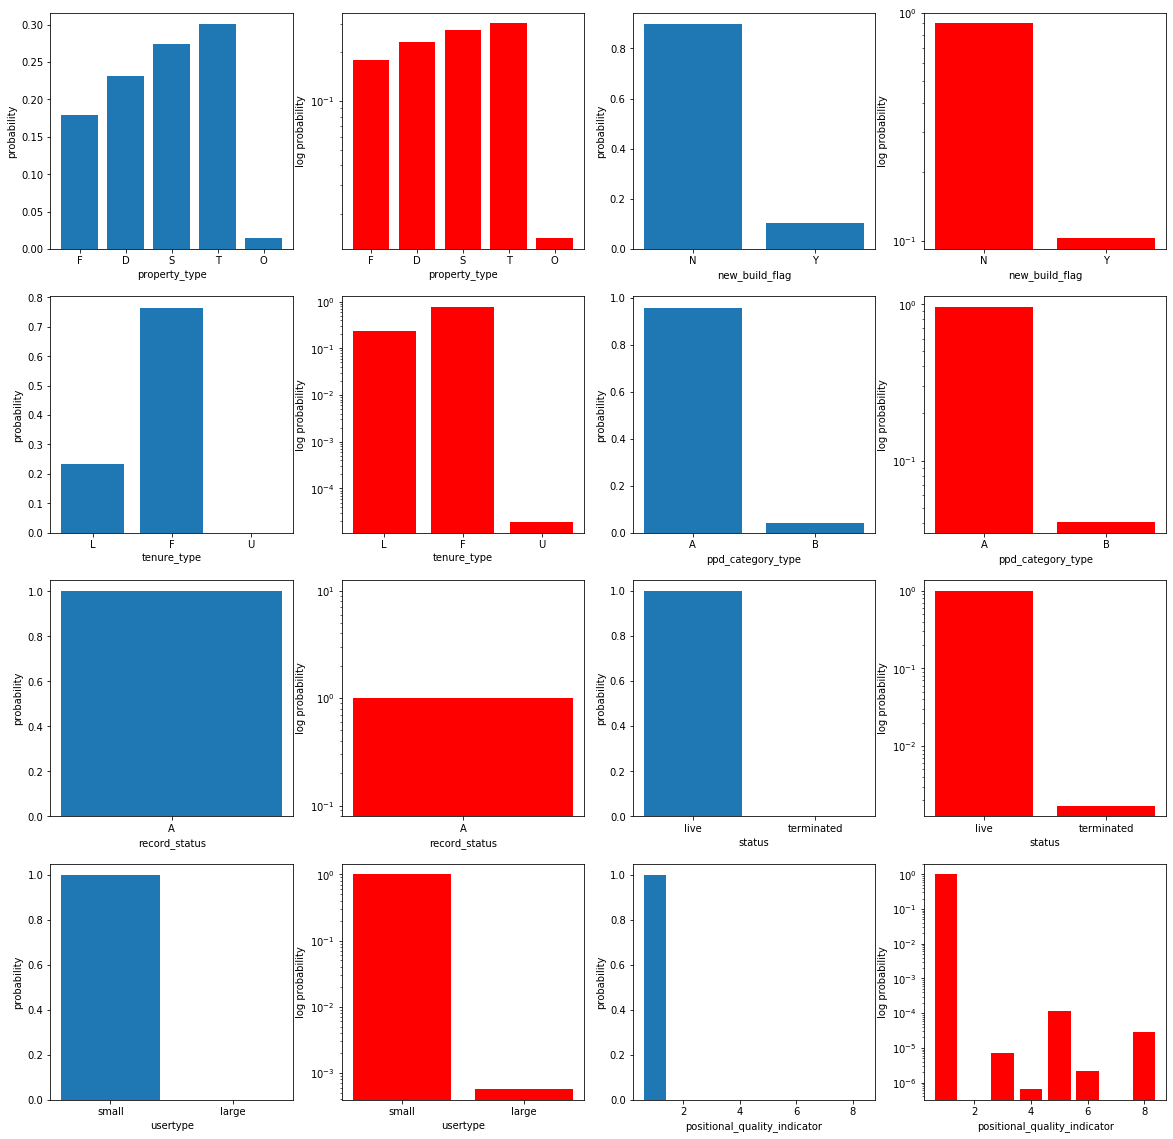



pppodata_distributions plot:



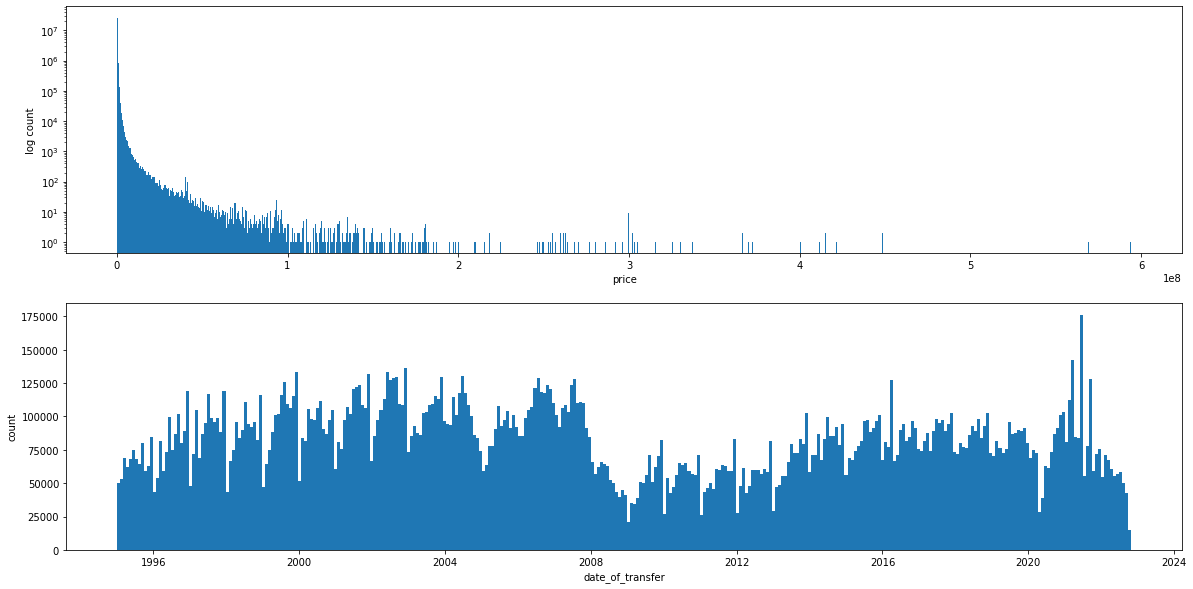



price plots for given property_type:



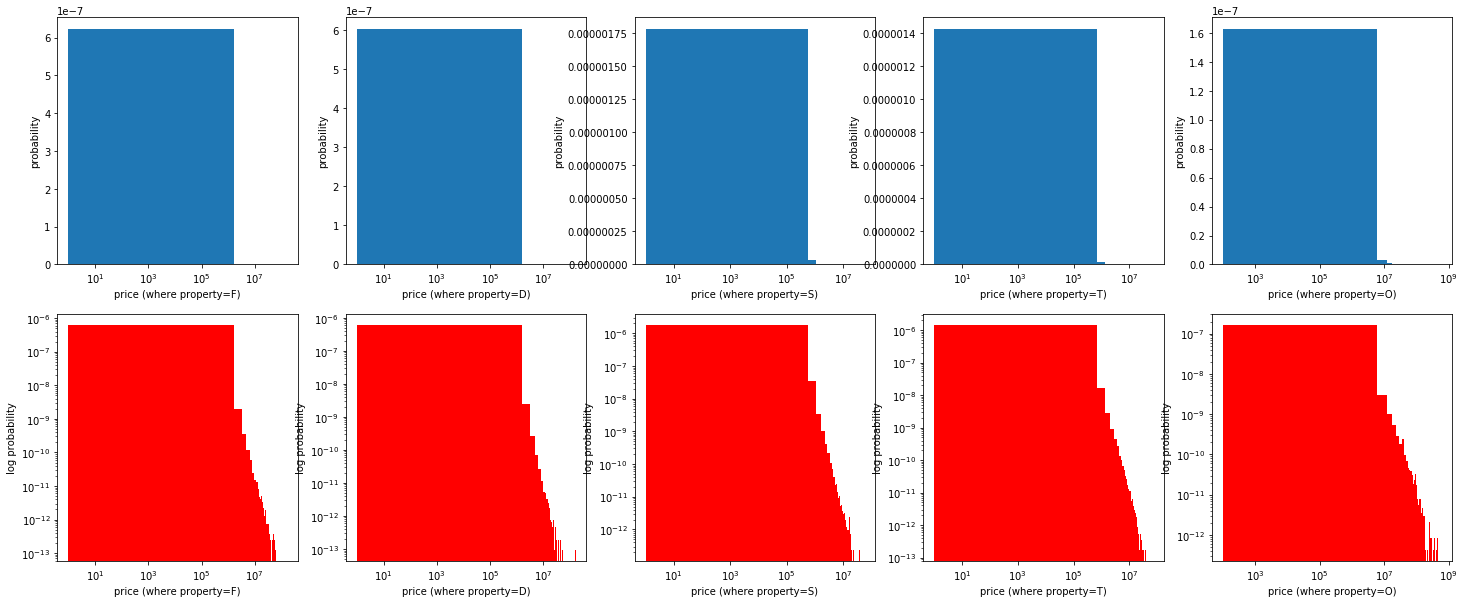



pppodata_latlong_distribution:



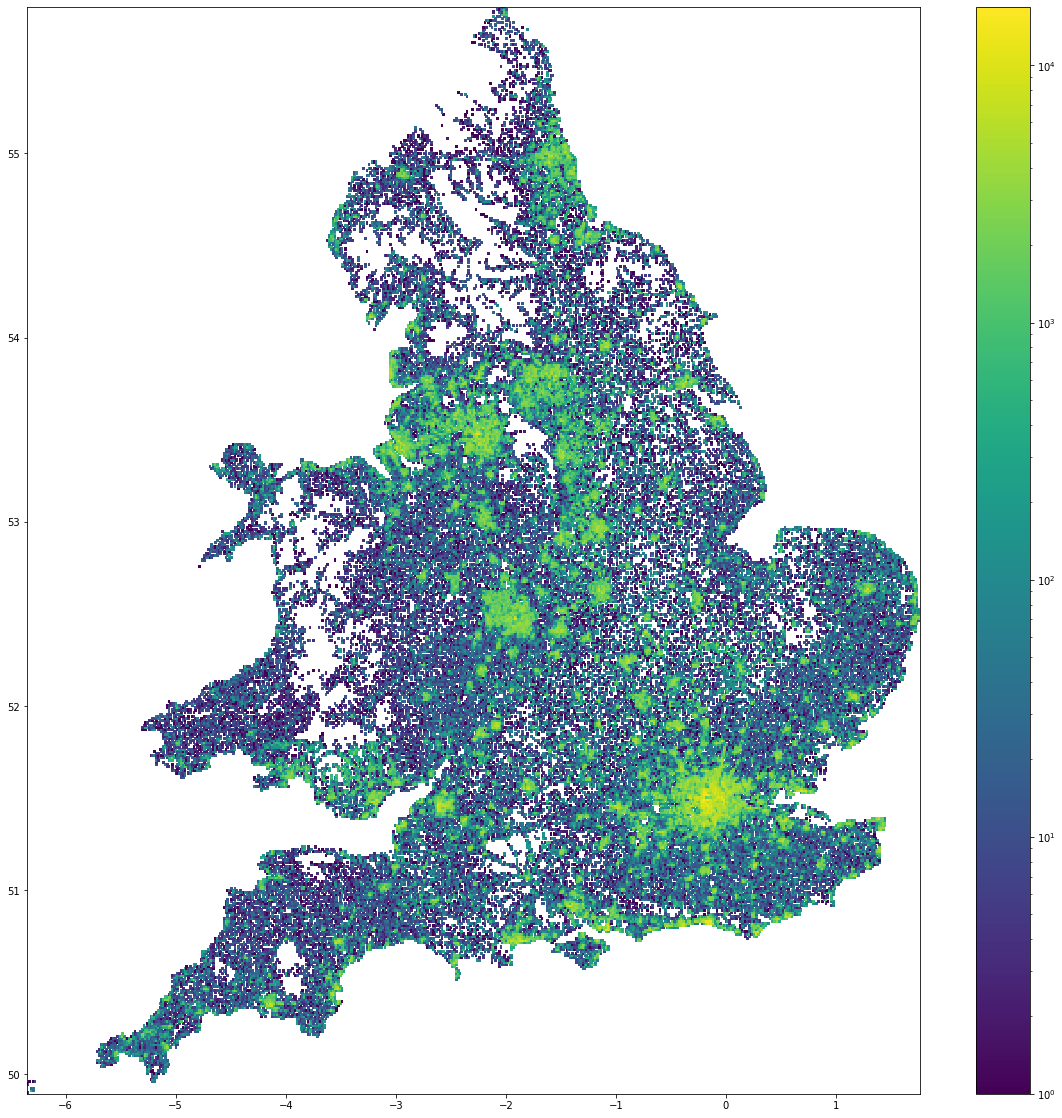

In [9]:
assess.characterise_raw_ppdata_and_raw_podata()

From the above, we can see that:

1. **What is the total number of rows in `ppdata` and `podata`?**
   - `ppdata`: 27 734 966. That's huge! I've tried, and it's not possible to load it all into memory at the same time. Google Colab's free instance can't handle it, let alone my own machine.
   - `podata`: 2 610 679. 
2. **Are there rows whose `postcode` is null in `ppdata` and `podata`?**
   - Yes for `ppdata`: 44 773 of them. This accounts for $\frac{44773}{27734996 + 44773} \times 100\% = 0.16\%$ of the original dataset, so it's rather insignificant. However, they aren't useful for use during predictions (since we can't even find the latlong of the `ppdata` records if there's no postcode, given that we use `postcode` to join with `podata` to find the latlongs).
   - Not for `podata`: great.
3. **What is the distribution of numerical columns in `ppdata` and `podata`?**
   - `ppdata`:
     - `price`: The range is from £1 to £594 300 000. That's a huge range. From the plot, we can see that most properties are within 100 million, with a grand majority being within 1 million (around the narrow spike near the left of the plot).
     - `date_of_transfer`: We can almost make out a yearly pattern for each year: number of sales is generally the lowest when the year just starts (at least for 1995 to 2004; and from 2009 to 2013). Perhaps there's some regulation involved, perhaps related to maximum sales quotas? This is not important for our task, but interesting to see.
     - `property_type`: Seems almost evenly distributed between flats (`F`), detached (`D`), semi-detached (`S`) and terraces (`T`). The others (`O`) category makes up about 3%: when we want to make price predictions about "other" properties, we can only reference "other" properties in historical `ppdata`, but this means that predictions are likely to be worse, since models have less data to train on.
     - `new_build_flag`: Majority (around 90%) has value `N`, meaning it's a sale of a property that's already been constructed. Since a majority of properties will have `N` value, this attribute is not useful for prediction (including feature making): we know from above that prices have a very "fine definition" and huge range (1 to almost 600 million), so choosing features with very "coarse definition" (there are only 2 values here) is unlikely to be helpful in predicting the "fine definitions".
     - `tenure_type`: `U` is an unexpected, undocumented value! It doesn't even appear on the linear scale plot: only visible on the log scale plot. I cannot find any documentation for what `U` might mean. A friend who is currently studying Law is also unsure of what `U` might mean: as far as he knows, there are only 2 kinds of leases. I'll take `U` to mean unknown/undefined (i.e. null), and thus discard these data rows.
     - `ppd_category_type`: Majority is type `A`. Same analysis as `new_build_flag`: this won't be used for prediction purpose  (including feature making).
     - `record_status`: The [government website](https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd) documented that there is possibility of `C` or `D` records, but we see none here. Great! One less complexity to deal with.
   - `podata`:
     - `status`: Majority is `live`. Same analysis as `new_build_flag`: this won't be used for prediction purpose  (including feature making).
     - `usertype`: Majority is `small`. Same analysis as `new_build_flag`: this won't be used for prediction purposes (including feature making).
     - `positional_quality_indicator`:  Majority is `1`, which is the best quality ("Within the building of the matched address closest to the postcode mean.", from [getthedata](https://www.getthedata.com/open-postcode-geo)). This is reassuring: inaccurate postcodes are rare (can only be seen on the log scale plot). Also, same analysis as `new_build_flag`: this won't be used for prediction purposes (including feature making).
4. **What is the distribution of `price` for each `property_type`? Any significant differences between them?**\
   The distributions for the first 4 types (`F`, `D`, `S`, `T`) look essentially the same. The distribution of `O` looks slightly different (in the log plot, more of the "mass" lies in the right descending part of the graph. 
   
   However, it still makes sense to predict property price for a `F` type property using only historical `ppdata` records for `F` type properties: the difference may not be extremely apparent at this scale, but in our prediction system, we are working with a far smaller subset of the rows we can see here, and these differences can become much more apparent. See the next notebook cell, where I only analyse 2022's data.
5. **What is the geographical distribution of price paid data across UK?**\
   Predictions are likely better if we're in one of the regions that are more "green" above: these regions have more data that we can train our models on.
   
   London is one particular example. (I'm an international student, and can't identify the other "green" regions by name, but a domain expert should be able to interpret this quickly.)

   When we select a bounding box of fixed size, a box situated in a green region like London will likely capture way more historical `ppdata` data points than a box situated in a blue region.

podata: Gathering statistics...
Dropped 0 null postcode rows from df_podata out of 2610679


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[ppdata 2022part1] Dropped 355 null postcode rows out of 266956
[ppdata 2022part2] Dropped 572 null postcode rows out of 266956

Statistics collection complete.

###########
# RESULTS #
###########

Number of rows in podata: 2610679
Number of rows in podata whose postcode is null: 0
Number of rows in ppdata: 533912
Number of rows in ppdata whose postcode is null: 927
Number of rows in ppdata whose record_status isn't A: 0
Number of rows in ppdata whose record_status is A: 532148
Minimum price in ppdata over all rows: 100
Maximum price in ppdata over all rows: 165000000

ppdata_and_podata_distributions plot:



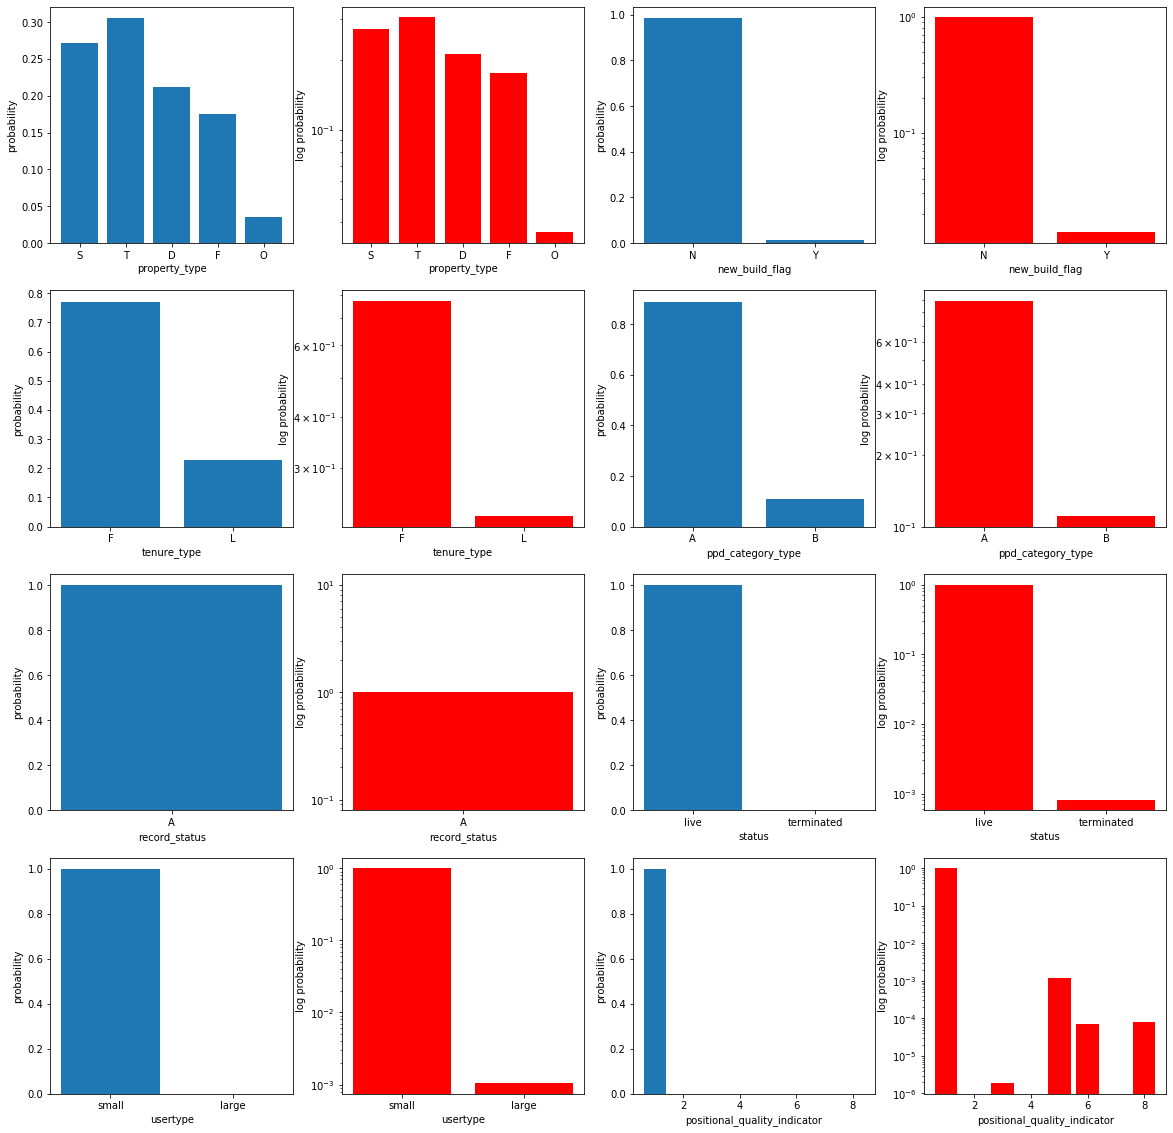



pppodata_distributions plot:



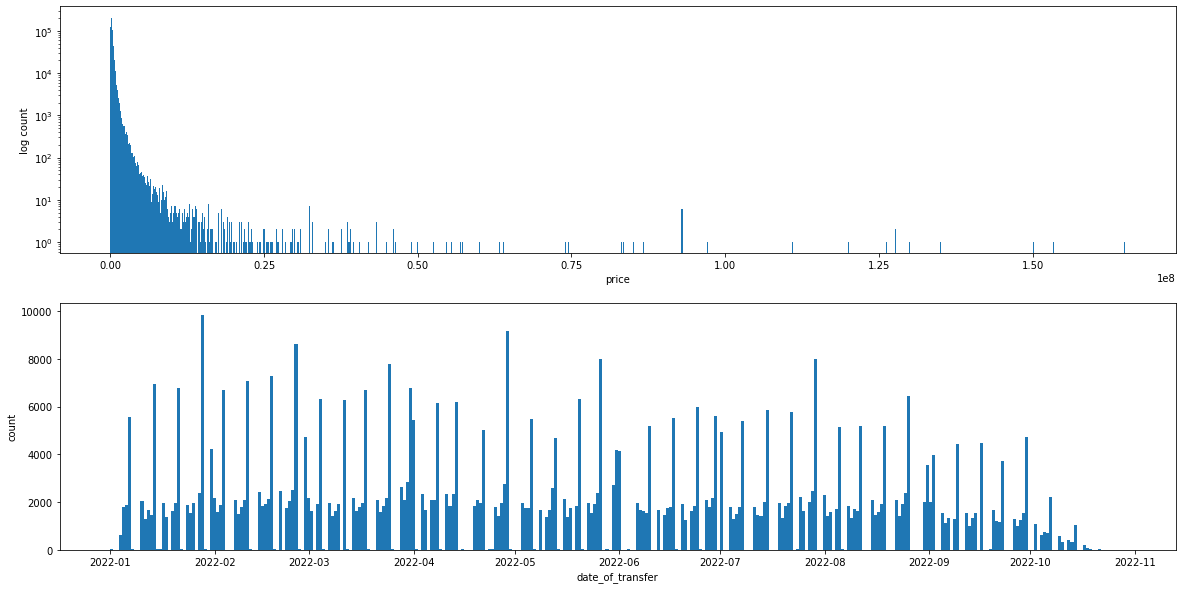



price plots for given property_type:



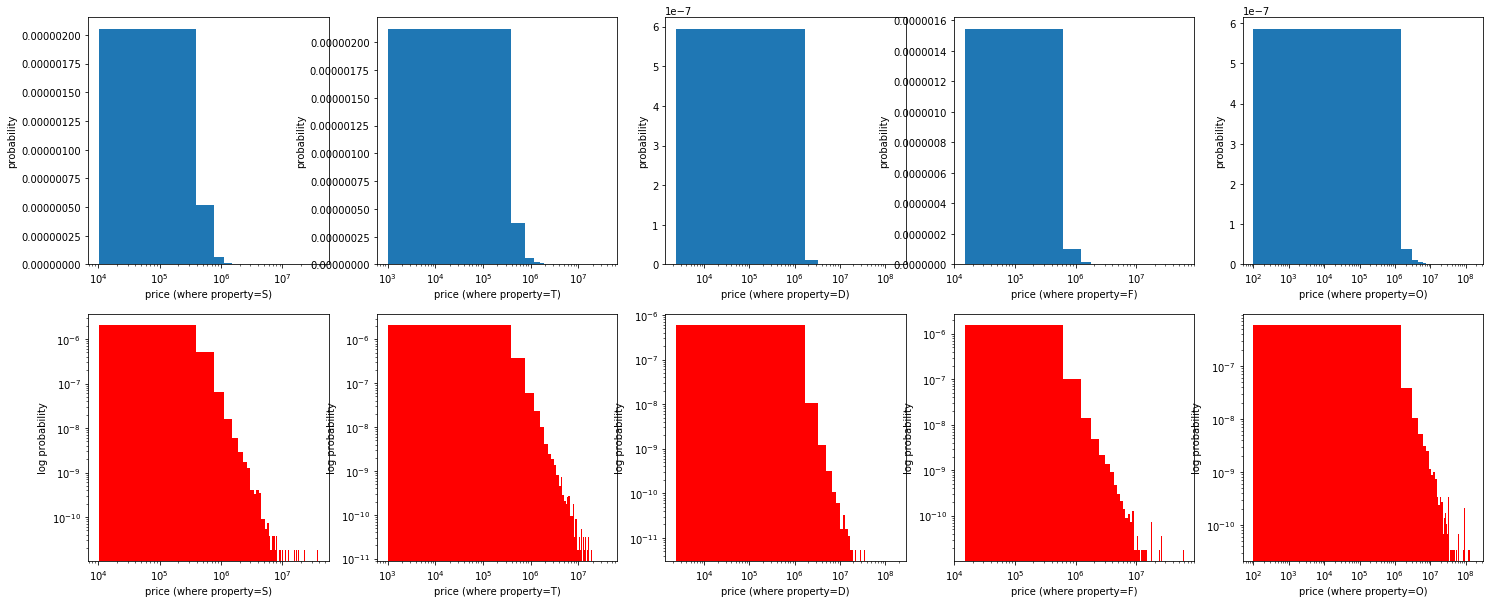



pppodata_latlong_distribution:



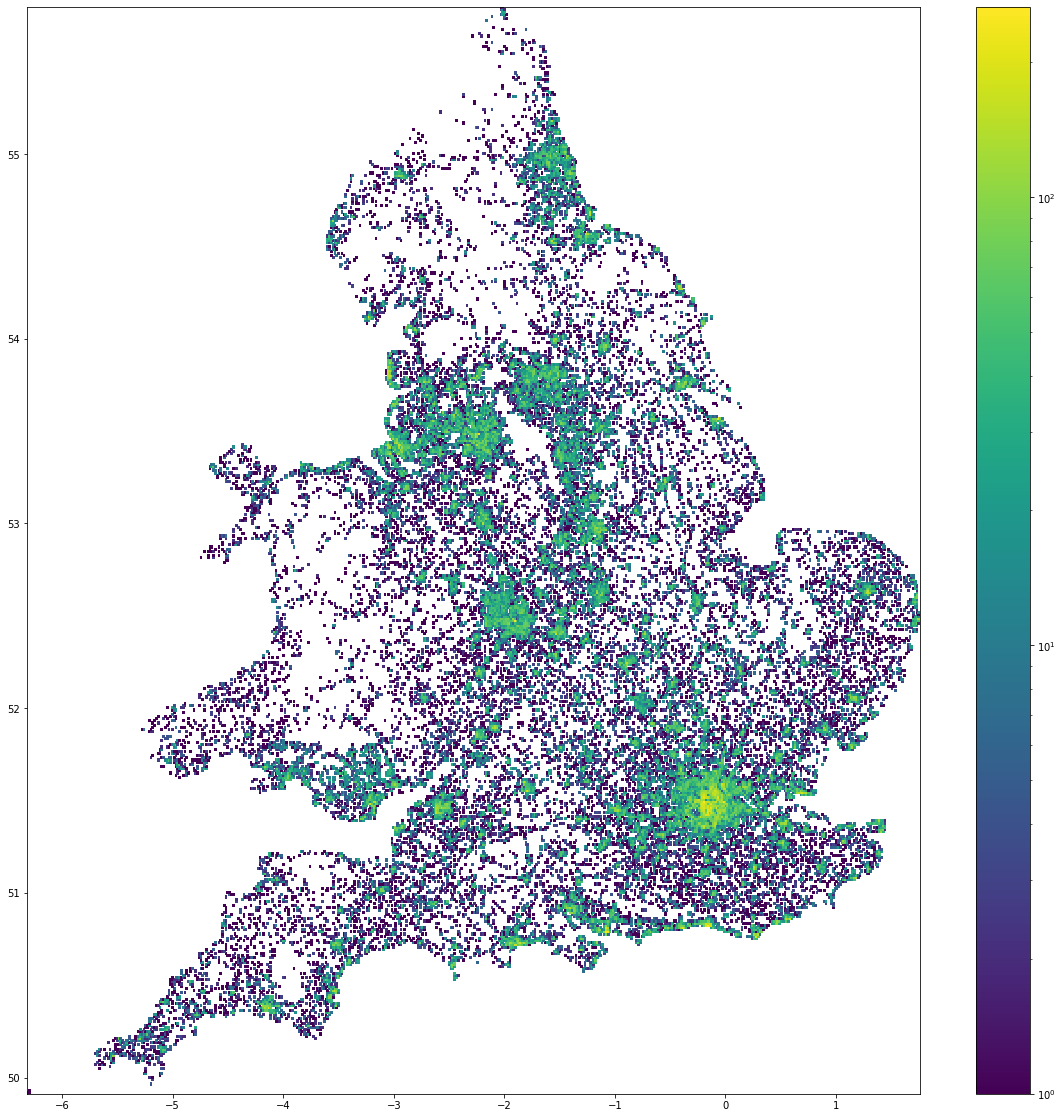

In [10]:
assess.characterise_raw_ppdata_and_raw_podata(2022, 2022)

As we can see from the `price plots for given property type`, the differences in distribution are indeed more apparent with a smaller dataset.

### What the above means for data cleaning:
During the access-assess-address loop, I now go back to access and perform the data cleanup:
1. Removing rows with null `postcode`s from `ppdata`.
2. Removing rows with `U` as `tenure_type` from `ppdata`.

### What the above means for feature generation

#### I'll exclude from in the features I use in my GLMs: (effectively ignored from this point on)
From `ppdata`:
- `transaction_unique_identifier`: Just an arbitrary machine generated ID, meaningless for prediction
- `postcode`: used for joining ppdata and podata; not useful as a feature. Location information is already encoded in latlong.
- `primary_addressable_object_name`: Typically house number. Assume meaningless for prediction (I assume people don't really care about what number their house is assigned).
- `secondary_addressable_object_name`: Typically identities of a unit in a building. Assume meaningless for prediction  (I assume people don't really care about what number their house is assigned).
- `new_build_flag`: explained above (not helpful in predicting "fine definition" details of price).
- `tenure_type`: explained above (not helpful in predicting "fine definition" details of price).
- `street`: Location information is already encoded in latlong.
- `locality`: Location information is already encoded in latlong.
- `town_city`: Location information is already encoded in latlong.
- `district`: Location information is already encoded in latlong.
- `county`: Location information is already encoded in latlong.
- `ppd_category_type`: explained above (not helpful in predicting "fine definition" details of price).
- `record_status`: All records are `A`.

From `podata`:
- `status`: enum(live/terminated). Terminated postcodes are no longer in use, but still included because we're using them as historical data points (about how much a building in some area cost in the past).
- `usertype`: explained above (not helpful in predicting "fine definition" details of price).
- `positional_quality_indicator`: explained above (not helpful in predicting "fine definition" details of price).
- `easting`: Location information is already encoded in latlong.
- `northing`: Location information is already encoded in latlong.
- `country`: Location information is already encoded in latlong.
- `postcode_no_space`: Information is already encoded in postcode.
- `postcode_fixed_width_seven`: Information is already encoded in postcode.
- `postcode_fixed_width_eight`: Information is already encoded in postcode.
- `postcode_area`: Information is already encoded in postcode.
- `postcode_district`: Information is already encoded in postcode.
- `postcode_sector`: Information is already encoded in postcode.
- `outcode`: Information is already encoded in postcode.
- `incode`: Information is already encoded in postcode.

#### I'll include these in the features I use in my GLMs:
From `ppdata`:
- `price`: required as the response variable
- `date_of_transfer`: not direcly used as a feature, but used to filter the rows we query from AWS (querying all rows in history is not only inefficient, but also not helpful: general prices of houses change over time due to inflation.

  According to figure 2 from [Office for National Statistics's UK House Price Index (Sep 2022)](https://www.ons.gov.uk/economy/inflationandpriceindices/bulletins/housepriceindex/september2022) (this is the latest version):
  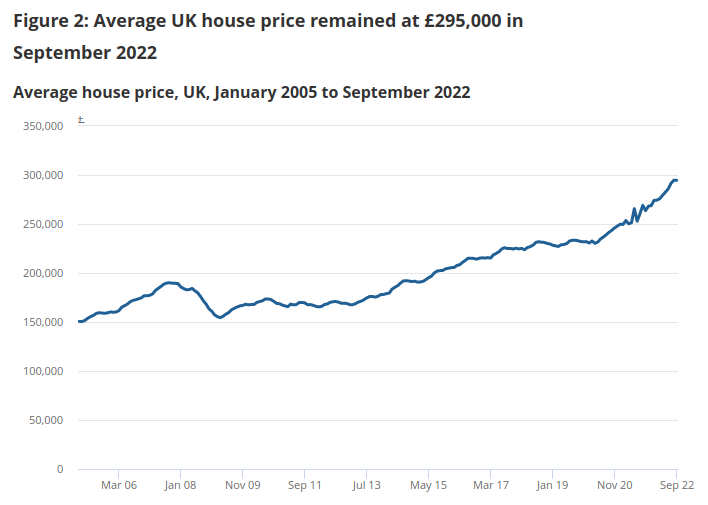

  It seems like the prices are increasing (from 2013 to 2022) at a rate of around £15 000 per year. Most of the prices in our dataset are below a million pounds, so historical data can get stale pretty quickly, particularly for properties prices that are way less than a million. I'll only query 3 years worth of historical `ppdata` from AWS. The number 3 is arbitrary, and is formed by a "non-expert's intuition" and is an assumption I'm putting into the model. If this is wrong, domain experts can correct me, and this can be easily changed in the code via the `num_years_history=3` default argument to the `predict_price()` function.
- `property_type`: will be used to filter the rows I'm querying from AWS: if the end user wants to predict prices for a `F`-type property, I'll only pull historical `ppdata` data related to `F`-type properties. This is explained earlier (findings from characterising `ppdata` and `podata`).

From `podata`:
- latitude: used as a filter. We'll only fetch historical `ppdata` rows in a bounding box around the property we want to predict prices for: I'm assuming that the price of a property is only dependent on local geographical features (e.g. presence of and distances to points of interest), so an identical house in Cambridge will cost different if situated in London instead. This is also done for efficiency reasons: pulling the entire UK's worth of data (i.e. all `ppdata` rows on AWS) is not feasible: it can't fit on the RAM on most machines.
- longitude: used as a filter, as explained above in `latitude`.

## Visualising OpenStreetMap Points of Interest (OSM POIs)
I'll copy some of the `predict_price()` code over to here, and only explain what the visualisation means. The way I select which POIs to pull from OSM is explained in Question 3 (it's makes many question-specific assumptions).

In [15]:
from datetime import datetime, timedelta
import geopandas as gpd
import osmnx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


#################
# FETCHING DATA #
#################
Querying rows from AWS...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 107 rows from AWS.
Getting POIs from OSM...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 3602 POIs in the bounding box around latitude=52.205132329748466, longitude=0.1077164339980662.
Getting edges from OSM for plotting...


<ipython-input-18-b9a19ca931c2>:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  gdf_pois.drop("relation", inplace=True)


  0%|          | 0/1 [00:00<?, ?it/s]

Got edges from OSM for plotting.

##########################################################################
# MAP AROUND PREDICTED PROPERTY (at the provided latitude and longitude) #
##########################################################################


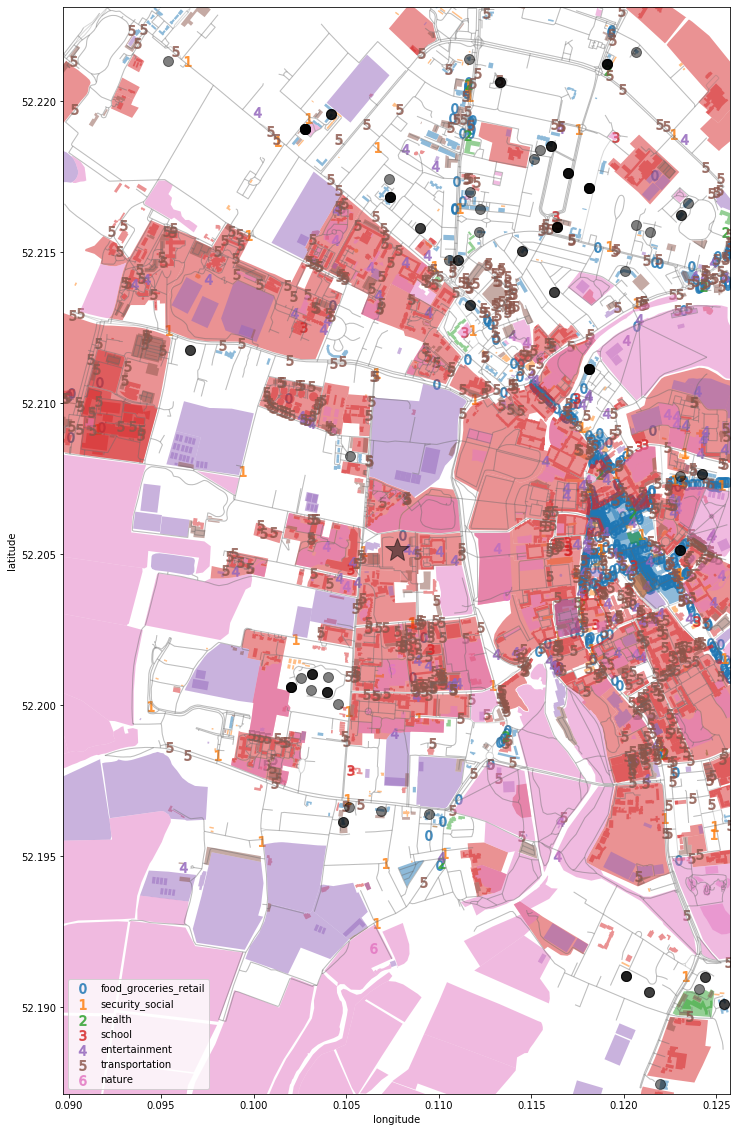

In [18]:
latitude = 52.205132329748466
longitude = 0.1077164339980662
date_isostr = "2022-12-02 00:00"
property_type = "F"
dict_of_categories = address.DEFAULT_DICT_OF_CATEGORIES
box_width_km = 2
box_height_km = 2
num_years_history = 3

# Select a bounding box around the housing location in latitude and longitude.
# get all POIs we'd ever need in our generation of features, hence (* 2) in the following lines
box_width = utils.distance_km_to_degrees(box_width_km * 2)
box_height = utils.distance_km_to_degrees(box_height_km * 2)
north = latitude + box_height / 2
south = latitude - box_height / 2
west = longitude - box_width / 2
east = longitude + box_width / 2

# Select a data range around the prediction date.
date = datetime.fromisoformat(date_isostr)
sql_cutoff_earliest_date = (
    date - timedelta(days=365 * num_years_history)
).isoformat()
sql_cutoff_latest_date = date.isoformat()

tags = utils.merge_categories(dict_of_categories)

# Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
print()
print("#################")
print("# FETCHING DATA #")
print("#################")
print("Querying rows from AWS...")
for _ in tqdm((1, ), leave=False):
    df_pppodata = aws_utils.get_pppodata_conditioned(
        property_type,
        sql_cutoff_earliest_date,
        sql_cutoff_latest_date,
        north,
        south,
        east,
        west
    )
if len(df_pppodata) == 0:
    raise Exception(
        f"Fetched 0 rows from AWS. No model can be trained to generate predictions. Try to increasing box_width_km (currently {box_width_km}), box_height_km (currently {box_height_km}), or num_years_history (currently ({num_years_history}))."
    )
print(f"Fetched {len(df_pppodata)} rows from AWS.")

geometry = gpd.points_from_xy(
    df_pppodata["longitude"], df_pppodata["latitude"]
)
gdf_pppodata = gpd.GeoDataFrame(df_pppodata, geometry=geometry)
gdf_pppodata.crs = "EPSG:4326"

print("Getting POIs from OSM...")
for _ in tqdm((1, ), leave=False):
    gdf_pois = osmnx.geometries_from_bbox(
        north, south, east, west, tags=tags)
    if "relation" in gdf_pois.index:
        gdf_pois.drop("relation", inplace=True)
print(
    f"Fetched {len(gdf_pois)} POIs in the bounding box around latitude={latitude}, longitude={longitude}."
)

dict_of_gdf_pois_categories = {
    category_name: utils.filter_pois(gdf_pois, category)
    for category_name, category in dict_of_categories.items()
}
# Sanity check: spliting the gdf_pois into fragments (gdf_pois_category-s) then unioning them shouldn't result in loss of rows
assert sum(
    [len(gdf) for gdf in dict_of_gdf_pois_categories.values()]
) >= len(gdf_pois)

print("Getting edges from OSM for plotting...")
for _ in tqdm((1,), leave=False):
    graph = osmnx.graph_from_bbox(north, south, east, west)
# Retrieve nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)
print("Got edges from OSM for plotting.")

# print()
# print("################################")
# print("# CHARACTERISATION OF AWS ROWS #")
# print("################################")
# # a modified version of assess.characterise_raw_ppdata_and_raw_podata(), which we've looked at before in Question 2
# assess.characterise_aws_pppodata(
#     prediction_uuid, df_pppodata, print_banners=False
# )

print()
print("##########################################################################")
print("# MAP AROUND PREDICTED PROPERTY (at the provided latitude and longitude) #")
print("##########################################################################")
fig, ax = plt.subplots(
    figsize=(constants.PLT_MAP_WIDTH, constants.PLT_MAP_HEIGHT))
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor="dimgray", alpha=0.25)
ax.set_xlim([west, east])
ax.set_ylim([south, north])
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
# Plot all POIs
for i, (category_name, gdf_pois_category) in enumerate(dict_of_gdf_pois_categories.items()):
    if "node" in gdf_pois_category.index:
        gdf_pois_category.loc["node"].plot(
            ax=ax,
            color=plt.rcParams["axes.prop_cycle"].by_key()["color"][
                i % len(plt.rcParams["axes.prop_cycle"].by_key()["color"])
            ],
            alpha=0.7,
            marker=f"${i}$",
            markersize=100,
            label=category_name
        )
    if "way" in gdf_pois_category.index:
        gdf_pois_category.loc["way"].plot(
            ax=ax,
            color=plt.rcParams["axes.prop_cycle"].by_key()["color"][
                i % len(plt.rcParams["axes.prop_cycle"].by_key()["color"])
            ],
            alpha=0.5
        )
ax.plot(
    longitude, latitude,
    marker="*",
    markersize=25,
    color="black",
    alpha=0.5
)
for i in range(len(gdf_pppodata)):
    ax.plot(
        gdf_pppodata["longitude"][i],
        gdf_pppodata["latitude"][i],
        marker="o",
        markersize=10,
        color="black",
        alpha=0.5
    )
ax.legend()
# plt.savefig(
#     os.path.join(
#         svg_output_dir,
#         f"{prediction_uuid}_map_around_{latitude}-{longitude}.svg"
#     )
# )
plt.show()

This is a plot of the POIs from chosen POI categories (explained in Question 3: [Feature Design](#scrollTo=58sMxYLeUIE9&line=8&uniqifier=1)) near the Cambridge University Library. 

Looking at this plot, we can see that:
- The black star is always at the centre of the plot, and represents the property whose price we want to predict.
- The black circles represent the "training dataset": historical `ppdata` rows that we are considering for training our linear model.
- The numbers starting from 0 each represent a POI (singular point) on the map. Refer to the legend to see what category they belong to. The selection of categories is provided by `address.DEFAULT_DICT_OF_CATEGORIES`, explained in Question 3.
- The shaded areas are the same as the previous bullet point, but for POI (polygons). These are POIs that are represented by areas in OSM. Their colours match the ones used for the singular point POIs.

## Question 3. Addressing a Property Price Prediction Question

<font color="gray">For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,</gray>

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

<font color="gray">We suggest that you use the following approach when building your prediction. </gray>

1. <font color="gray">Select a bounding box around the housing location in latitude and longitude.</gray>
2. <font color="gray">Select a data range around the prediction date. </gray>
3. <font color="gray">Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.</gray>
4. <font color="gray">Train a linear model on the data set you have created.</gray>
5. <font color="gray">Validate the quality of the model.</gray>
6. <font color="gray">Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.</gray>

<font color="gray">The knowledge you need to do a first pass through this question will have been taught by end of lab session four (25th November 2021). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.</gray>



### Model Choice
I am choosing to do a standard OLS model
$$\begin{align*}
y_i &\sim \sum_{j=1}^d \beta_j x_{ij} + N(0, \sigma^2)\\
{E}[y_i|\mathbf{x}_i] &= \sum_{j=1}^d \beta_j x_{ij}
\end{align*}$$


This is equivalent to a generalised linear model
$$g({E}[y_i|\mathbf{x}_i]) = \sum_{j=1}^d \beta_j x_{ij}$$
where $g(\cdot)=\cdot$ is the identity link function. 

The reason I'm sticking to the OLS model (and therefore the `statsmodels.api.OLS` model) is because:
- From experimentation, the performance of the GLM (`statsmodels.api.GLM`) models based on the features I've come up with (explained in the next section) do not show significant performance improvements. Here is a summary of what I found:
  - Our response variable (price) is in the non-negative real numbers range $[0, \infty)$. The only applicable GLM models to implement are:
    - Gaussian
    - Inverse Gaussian
    - Gamma
    - Tweedie

    since their support includes the range $[0,\infty)\subseteq \mathbb{R}$.

    The following are disqualified because:
    - Binomial: support is non-negative integers, but our response variable spans over non-negative reals.
    - Poisson: similar to reasoning for Binomial.
    - Negative Binomial:similar to reasoning for Binomial.
  - I then went to try out all applicable link functions for each of these models, and for some fixed location I generated the features and formed the dataset, then predicted prices for the same data points as in the dataset, to have a quick feel for how they performed (I should have split the dataset into training and test dataset, but didn't do so because the dataset wasn't particularly big, so there was a risk of the training dataset being even smaller than required to produce decent results)
    
    I then looked at the log-likelihood of the dataset, which gives me an idea of how well the model performed: a good fit should have a high log-likelihood (maximum likelihood estimation idea):
    - Gaussian (identity link): $-755.79$ *(equivalent to OLS model)*\
      Gaussian (log link): $-783.84$ (plus the predictions were really far from the correct prices)\
      Gaussian (inverse power link): $-748.19$
    - Inverse Gaussian (identity link): $-736.87$\
      Inverse Gaussian (log link): $-789.11$ (plus the predictions were extremely far from the correct prices)
    - Gamma (identity link): $-738.86$\
      Gamma (log link): $-792.64$\
      Gamma (inverse power link): $-746.34$
    - Tweedie (identity link): nan (predictions looked below-average, same as those above which I didn't write comments for)\
      Tweedie (power link): nan (predictions looked below-average)\
      Tweedie (log link): nan (plus the predictions were extremely far from the correct prices)\
      Tweedie (inverse power link): nan (predictions looked below-average)
    
    Here, inverse Gaussian with identity link is a "tentative best" for this fixed location. However, when I tried the same experiments on other fixed locations, inverse Gaussian wasn't always the "tentative best". This was taking quite too much time to experiment beyond the potential merits it had, therefore I stopped exploring GLMs. I surmised that no one class of GLMs outperformed another.
- This is the more important reason: I want a numerical measure of how good a *prediction* (price) is: that's the final question we're answering in the address aspect of the entire data science workflow.
  - The `statsmodels.api.OLS` models provide `obs_ci_lower` and `obs_ci_upper`, which means I can generate a (95%) confidence interval around the *prediction*.  
  - On the other hand, `statsmodels.api.GLM` models only provide `mean_ci_lower` and `mean_ci_upper`, which tells us how good the *fit*/*model* is (not the *prediction*!).

Using `statsmodels.api.OLS` unfortunately limits me to Gaussian GLM with identity link, but from the first bullet point, I haven't seen much merit in using GLMs (I also cannot immediately see ways where a GLM with a non-identity link might be useful: the POI-related features I can think of (nearby count, shortest distance to one) doesn't seem to be exponentially related with price, for example). This might require domain expert knowledge, which I do not possess. 

Furthermore, this is only a first pass of the access-assess-address cycle. Therefore, I'll proceed with only exploring OLS models for now (i.e. for this assessment).

### Feature Design
I am choosing to do a standard OLS model

$$\mathbb{E}[y_i|\mathbf{x}_i] = \sum_{j=1}^d \beta_j x_{ij}$$

where $y_i$ is price, and $\mathbf{x}_i = \begin{bmatrix} 1 \\ \text{category$_1$ POI count in bounding box}\\ \text{distance to closest category$_1$ POI within bounding box} \\ \vdots \\ \text{category$_M$ POI count in bounding box}\\ \text{distance to closest category$_M$ POI within bounding box} \end{bmatrix}^T$ are the features. The first column of the design matrix $\mathbf{x}$ is a ones vector. *(For clarity, $\mathbf{x}$ is the same as `train_X` that I use in code, and is fed into the model as `sm.OLS(train_Y, train_X)`. $\mathbf{x}_i$ is the $i$-th row in this matrix, representing one property.)*

The ones column is added such that its coefficient $\beta_\texttt{const}$ represents a sort of "mean" price of properties around the point we wish to predict the price of, where the remaining features are all $0$. 

I'll choose $M$ types of categories to look at. These are another one of my assumptions: I'll assume that the prices are somewhat related to the number of nearby POIs for some category (e.g. transportation facilities), and also the distance to the closest one of these POIs. 

- Should the categories I choose be wrong, they can be very easily changed in code, by providing the `dict_of_categories` optional argument to the `predict_price()` function. Currently, the default value of this argument is obtained from manual cherry-picking from [OSM Map Features](https://wiki.openstreetmap.org/wiki/Map_features), as follows:
  ```python
DEFAULT_DICT_OF_CATEGORIES = {
    "food_groceries_retail": {
        "amenity": ["cafe", "fast_food", "food_court", "restaurant", "marketplace"],
        "building": ["apartments", "retail", "supermarket"],
        "shop": True  # True means include all kinds of shops
    },
    "security_social": {
        "amenity": ["fire_station", "police", "post_box", "post_office", "place_of_worship"],
        "building": ["cathedral", "chapel", "church", "kingdom_hall", "monastery", "mosque", "religious", "shrine", "synagogue", "temple", "fire_station", "government", "garage", "garages", "parking"]
    },
    "health": {
        "amenity": ["clinic", "dentist", "doctors", "hospital", "pharmacy", "social_facility"],
        "building": ["hospital"],
        "healthcare": True
    },
    "school": {
        "amenity": ["college", "kindergarten", "language_school", "library", "training", "school", "university"],
        "building": ["college", "kindergarten", "school", "university"],
        "landuse": ["education"],
        "leisure": ["playground"]
    },
    "entertainment": {
        "amenity": ["cinema", "community_centre", "events_venue", "fountain", "theatre", "bbq"],
        "building": ["sports_hall", "stadium"],
        "leisure": ["fitness_station", "sports_centre", "stadium", "swimming_pool", "track"],
        "sport": True,
        "tourism": True,
    },
    # assumption: land transportation only (boat etc. not included)
    "transportation": {
        "amenity": ["bicycle_parking", "bicycle_repair_station", "bicycle_rental", "bus_station", "car_rental", "car_sharing", "car_wash", "charging_station", "fuel", "mortorcycle_parking", "parking", "taxi"],
        "building": ["train_station", "transportation"],
        "public_transport": ["stop_position", "platform", "station", "stop_area"],
        "railway": ["halt", "platform"],
        "public_transport": ["platform", "station", "subway_entrance", "tram_stop"]
    },
    "nature": {
        "boundary": ["forest", "national_park"],
        "landuse": ["farmland", "forest", "meadow"],
        "leisure": ["garden", "nature_reserve", "park"]
    }
}
    ```
    Since I've identified, manually, 7 categories here, there'll be 15 features in the design matrix: 2 for each of the 7 categories (nearby count, distance to nearest), plus one ones vector.

    There will therefore be 15 $\beta$s (coefficients) in the model. These are all features that I assume are beneficial for people buying a property: 
    - presence of food/groceries/retail options is essential
    - presence of social/public facilities like post offices are useful
    - presence of clinics are essential
    - presence of schools are good for people raising children
    - presence of entertainment options makes a place lively and therefore attractive
    - presence of transportation increases convenience and are good
    - presence of nature is good for relaxation (e.g. parks)

  I'd expect the $\beta$s for each "count" feature to be positive, since I assume that having more of these POIs nearby is good, and therefore should drive up the price. I'd expect the $\beta$s for each "distance" feature to be negative, since I assume that being further from one of these POIs is bad (hassle to travel further to get to one), and should therefore drive down the price.
- Should these *kinds* of features be wrong (i.e. property price isn't really related to nearby POIs or distance to nearby POIs), then we can generate new features with some effort in the code. 

In either case, the choices I've put forth for this assessment reflects 1 cycle of the access-assess-address cycle, awaiting feedback from domain experts. 

(Personally, I am not familiar with housing markets, and as an international student, am not familiar with the general topology of the UK in general as well. As such, the assumptions I make may tend to be stronger.)

### Code structure of `predict_price()`
The code in the library is rather monolithic, but it follows the suggested procedure. I'll explain my choices in each step. In this section, I'll run the function spread out over multiple cells, on a sample input.

In [19]:
import os
import uuid
from datetime import datetime, timedelta

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx
import pandas as pd
import shapely
import statsmodels.api as sm
from tqdm.auto import tqdm

latitude = 52.205132329748466
longitude = 0.1077164339980662
date_isostr = "2022-12-02 00:00"
property_type = "F"
dict_of_categories = address.DEFAULT_DICT_OF_CATEGORIES
box_width_km = 2
box_height_km = 2
num_years_history = 3
svg_output_dir = "prediction_svgs/"

#### 1. Select a bounding box around the housing location in latitude and longitude.

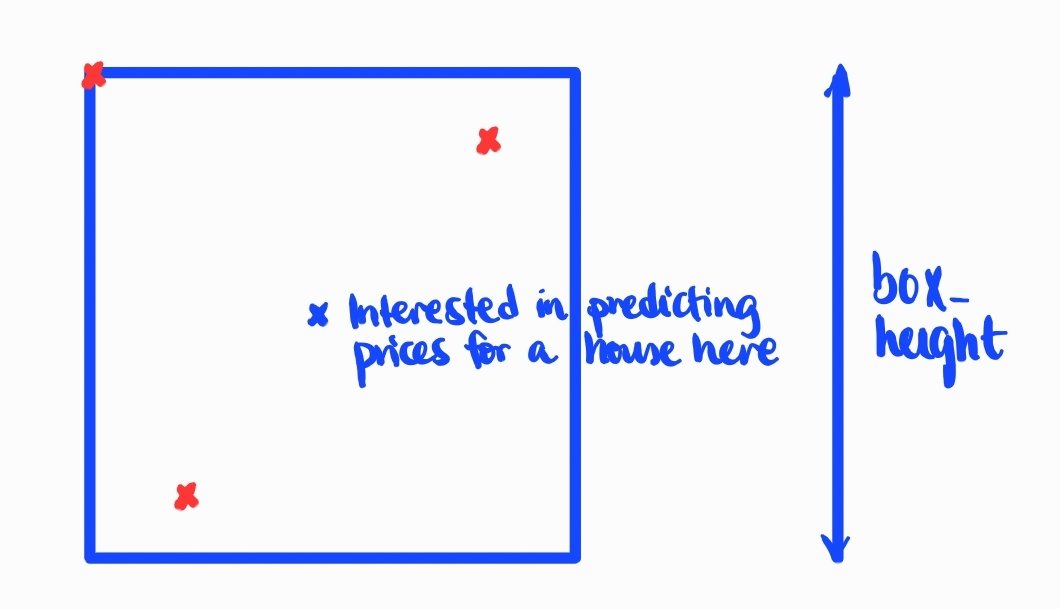

Suppose we want to find the price for a property at the blue cross. We first gather all historical `ppdata` records of properties within the bounding box as shown above, with dimensions defined by `box_height_km` and `box_width_km` (arguments to `predict_price()`).

In [20]:
if property_type not in ("D", "S", "T", "F", "O"):
    raise Exception(
        f"""
        Invalid property_type: expected one of ["D", "S", "T", "F", "O"], got {property_type}
        """
    )

os.makedirs(svg_output_dir, exist_ok=True)

prediction_uuid = uuid.uuid4()
print(
    f"The UUID for this prediction is: {prediction_uuid}. All saved figures will be labelled with this UUID."
)

# Select a bounding box around the housing location in latitude and longitude.
# get all POIs we'd ever need in our generation of features, hence (* 2) in the following lines
box_width = utils.distance_km_to_degrees(box_width_km * 2)
box_height = utils.distance_km_to_degrees(box_height_km * 2)
north = latitude + box_height / 2
south = latitude - box_height / 2
west = longitude - box_width / 2
east = longitude + box_width / 2

The UUID for this prediction is: 420ca32f-2e6e-453e-89d3-ba4486fefcbb. All saved figures will be labelled with this UUID.


#### 2. Select a data range around the prediction date. 

As explained in Question 2 in the section titled ["*I'll include these in the features I use in my GLMs:*"](#scrollTo=BijUEMqeJK22&line=10&uniqifier=1) (opens in new tab), I've chosen to look at 3 years worth of historical records from the given date.

In [21]:
# Select a data range around the prediction date.
date = datetime.fromisoformat(date_isostr)
sql_cutoff_earliest_date = (
    date - timedelta(days=365 * num_years_history)
).isoformat()
sql_cutoff_latest_date = date.isoformat()

tags = utils.merge_categories(dict_of_categories)

#### 3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.

As described before in [Feature Design](#scrollTo=58sMxYLeUIE9&line=69&uniqifier=1), I'll need to calculate, for a given property, the number of POIs (for some category) near it (within its bounding box) and the shortest distance to one of these POIs (for this category).

Therefore, referring to the figure below, the blue cross is the property whose price we're interested in. We'll train a linear model where the training dataset is:
- response variable: price of properties near blue cross (i.e. the price of red crosses)
- design matrix: the features of the red crosses (i.e. count and shortest distance to category POIs)

Calculation of the features for the red crosses requires POIs that range the orange square. Therefore in the code, there's this section:
```python
def predict_price(...):
    ...
    # Select a bounding box around the housing location in latitude and longitude.
    # get all POIs we'd ever need in our generation of features, hence (* 2) in the following lines
    box_width = utils.distance_km_to_degrees(box_width_km * 2)
    box_height = utils.distance_km_to_degrees(box_height_km * 2)
    north = latitude + box_height / 2
    south = latitude - box_height / 2
    west = longitude - box_width / 2
    east = longitude + box_width / 2
```
_NB: This code fragment is actually already run above. The explanation is placed here because it fits logically here._

Here, `box_width_km` and `box_height_km` are the dimensions of the blue box in the figure. The `* 2` gives us the dimensions of the orange box in the figure, and later, `north`, `south`, `east`, and `west` are used to fetch POIs from OSM.

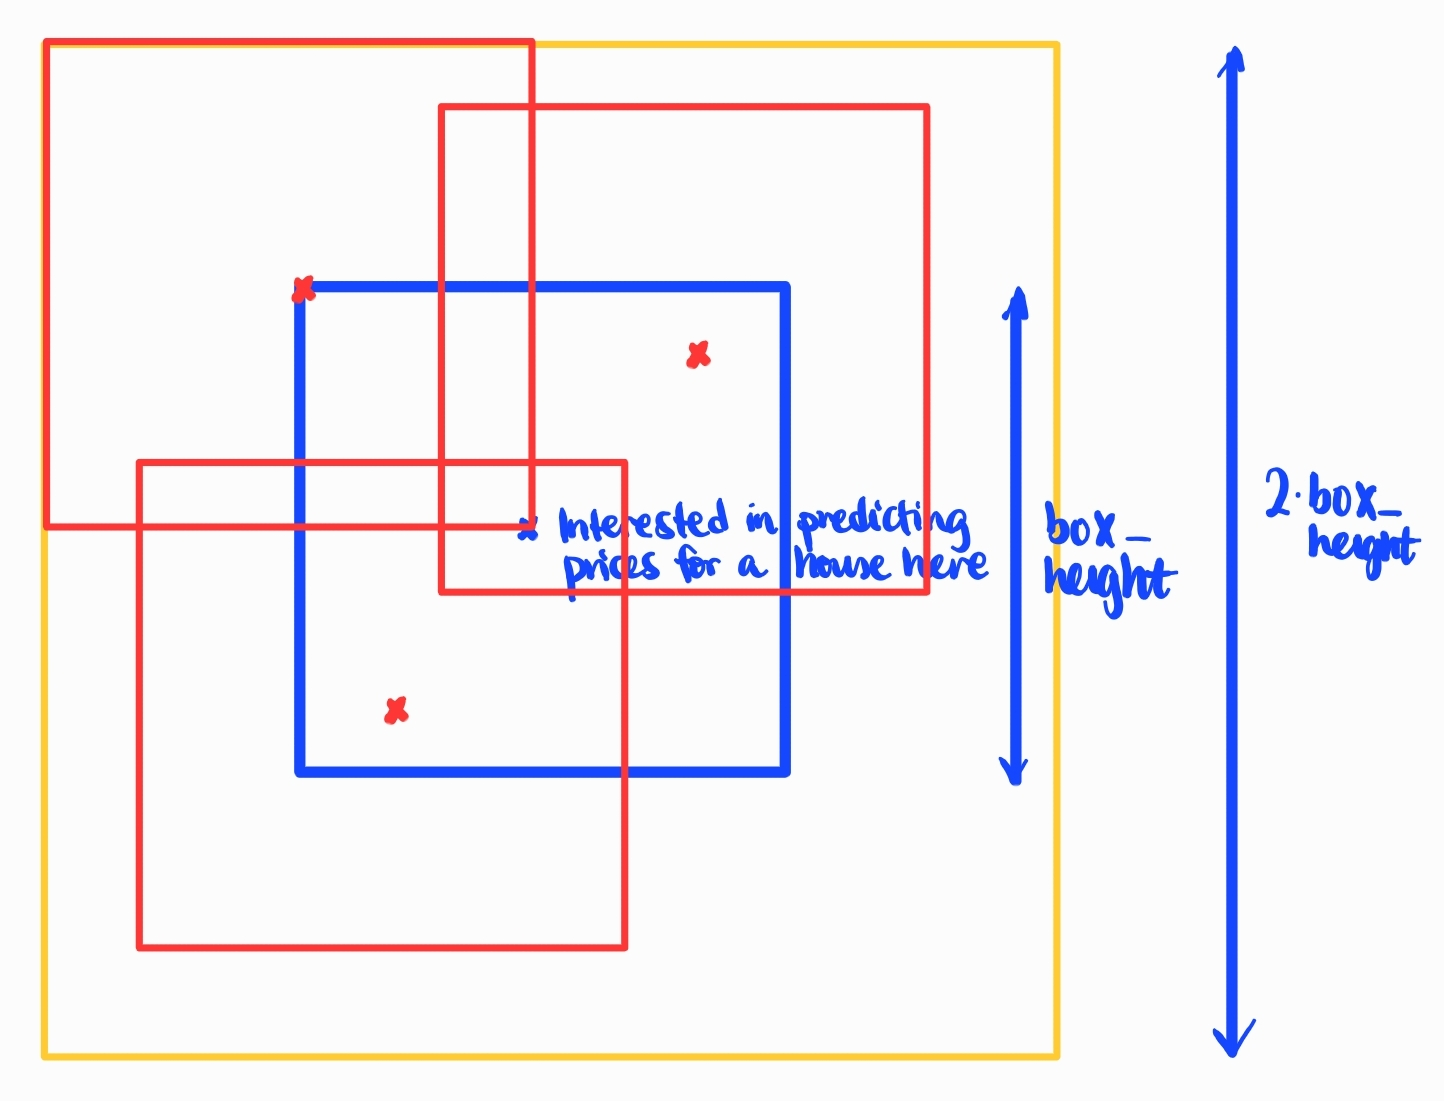

Now, for OSM POIs, we use only `node`s and `way`s. `relation`s are additional information built on top of underlying `node`s and `way`s (and `relation`s) [(Source)](https://wiki.openstreetmap.org/wiki/Relation). For simplicity, `relation`s are ignore by the following part of the code:
```python
def predict_price(...):
    ...
    print("Getting POIs from OSM...")
    for _ in tqdm((1, ), leave=False):
        gdf_pois = osmnx.geometries_from_bbox(
            north, south, east, west, tags=tags)
        if "relation" in gdf_pois.index:
            gdf_pois.drop("relation", inplace=True)  # here
    print(
        f"Fetched {len(gdf_pois)} POIs in the bounding box around latitude={latitude}, longitude={longitude}."
    )
```

In [22]:
# Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
print()
print("#################")
print("# FETCHING DATA #")
print("#################")
print("Querying rows from AWS...")
for _ in tqdm((1, ), leave=False):
    df_pppodata = aws_utils.get_pppodata_conditioned(
        property_type,
        sql_cutoff_earliest_date,
        sql_cutoff_latest_date,
        north,
        south,
        east,
        west
    )
if len(df_pppodata) == 0:
    raise Exception(
        f"Fetched 0 rows from AWS. No model can be trained to generate predictions. Try to increasing box_width_km (currently {box_width_km}), box_height_km (currently {box_height_km}), or num_years_history (currently ({num_years_history}))."
    )
print(f"Fetched {len(df_pppodata)} rows from AWS.")

geometry = gpd.points_from_xy(
    df_pppodata["longitude"], df_pppodata["latitude"]
)
gdf_pppodata = gpd.GeoDataFrame(df_pppodata, geometry=geometry)
gdf_pppodata.crs = "EPSG:4326"

print("Getting POIs from OSM...")
for _ in tqdm((1, ), leave=False):
    gdf_pois = osmnx.geometries_from_bbox(
        north, south, east, west, tags=tags)
    if "relation" in gdf_pois.index:
        gdf_pois.drop("relation", inplace=True)
print(
    f"Fetched {len(gdf_pois)} POIs in the bounding box around latitude={latitude}, longitude={longitude}."
)

dict_of_gdf_pois_categories = {
    category_name: utils.filter_pois(gdf_pois, category)
    for category_name, category in dict_of_categories.items()
}
# Sanity check: spliting the gdf_pois into fragments (gdf_pois_category-s) then unioning them shouldn't result in loss of rows
assert sum(
    [len(gdf) for gdf in dict_of_gdf_pois_categories.values()]
) >= len(gdf_pois)

print("Getting edges from OSM for plotting...")
for _ in tqdm((1,), leave=False):
    graph = osmnx.graph_from_bbox(north, south, east, west)
# Retrieve nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)
print("Got edges from OSM for plotting.")


#################
# FETCHING DATA #
#################
Querying rows from AWS...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 107 rows from AWS.
Getting POIs from OSM...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 3602 POIs in the bounding box around latitude=52.205132329748466, longitude=0.1077164339980662.
Getting edges from OSM for plotting...


<ipython-input-22-d1d43e7f444b>:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  gdf_pois.drop("relation", inplace=True)


  0%|          | 0/1 [00:00<?, ?it/s]

Got edges from OSM for plotting.


Next, we present some distribution plots and a map, which can be useful for "debugging" in the data science process: visualising what our data looks like and what kinds of biases our training dataset has. Some of these machinery have been explained before in previous sections (Question 2).


################################
# CHARACTERISATION OF AWS ROWS #
################################
Number of rows: 107
Minimum price over all rows: 109000
Maximum price over all rows: 890000

ppdata_and_podata_distributions plot:



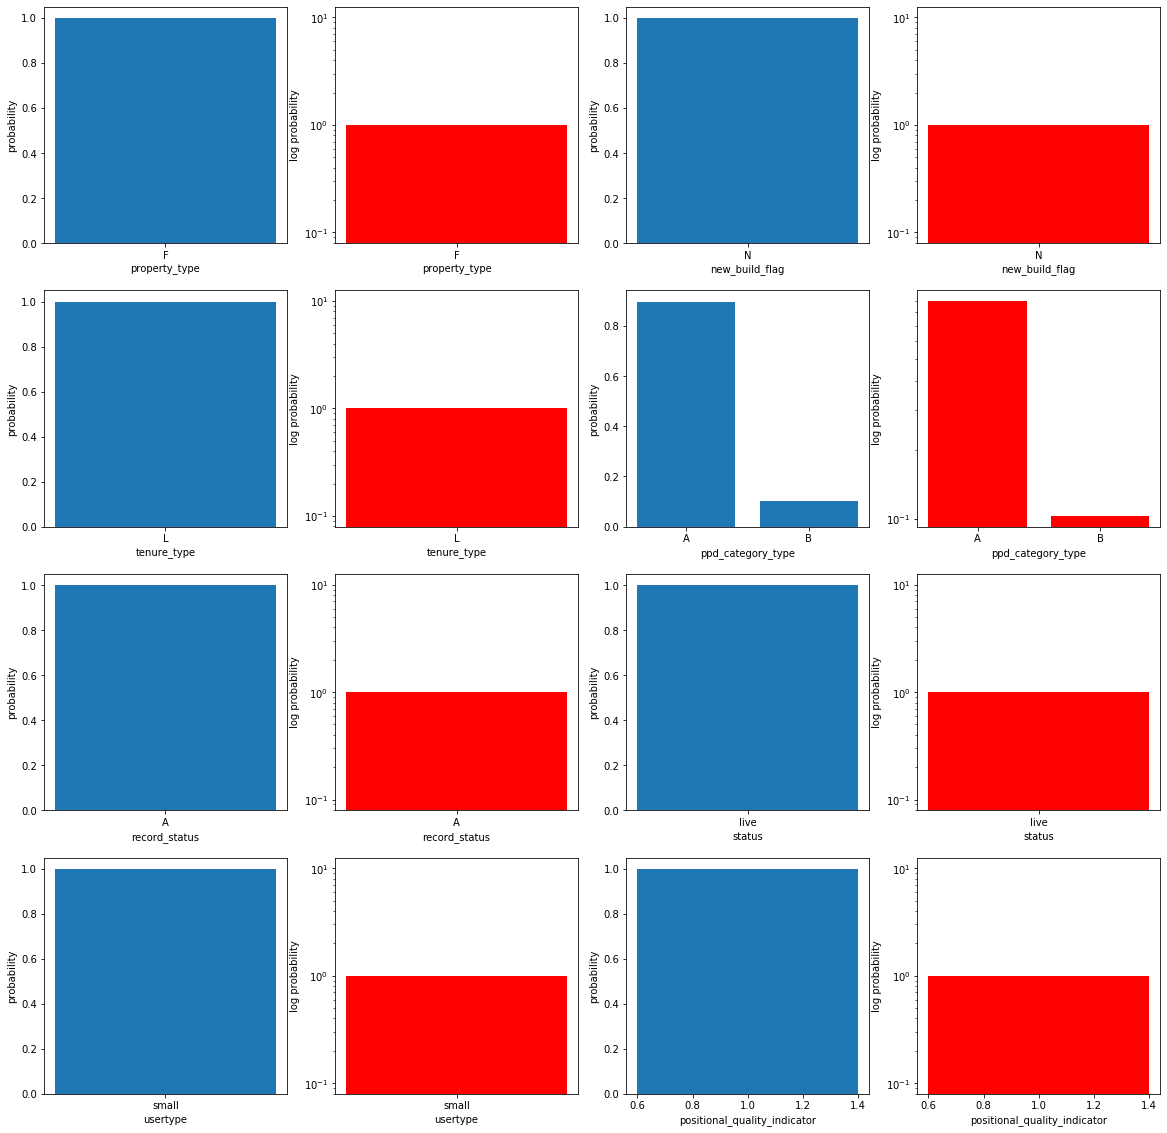



pppodata_distributions plot:



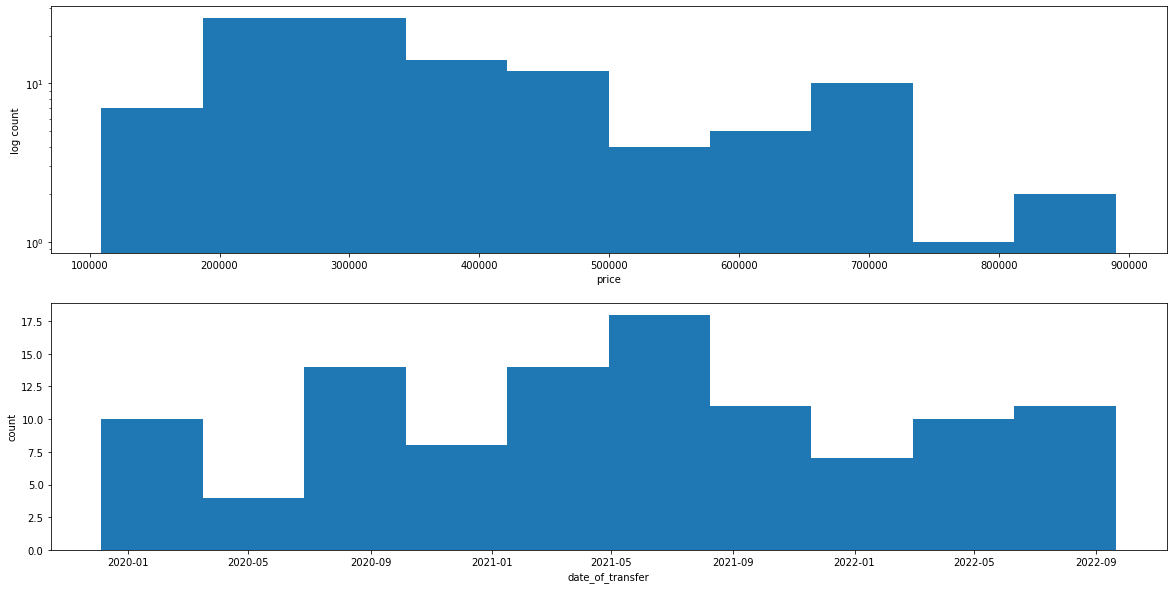



price plots for given property_type:



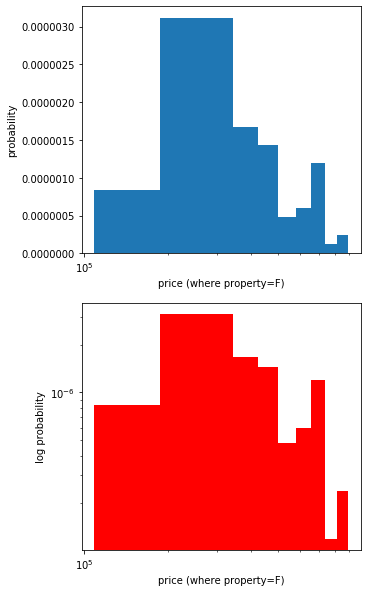



pppodata_latlong_distribution:



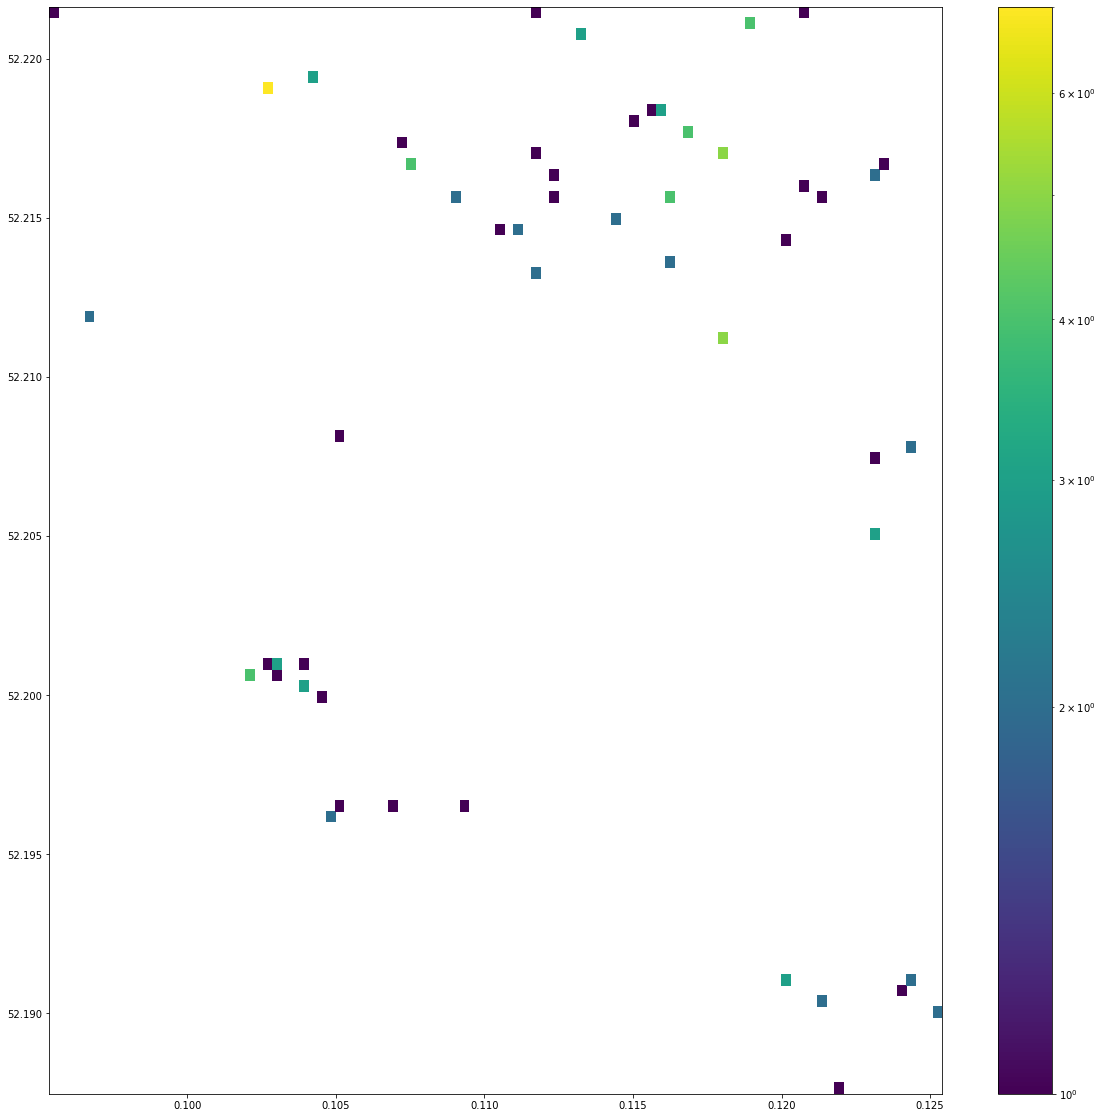



##########################################################################
# MAP AROUND PREDICTED PROPERTY (at the provided latitude and longitude) #
##########################################################################


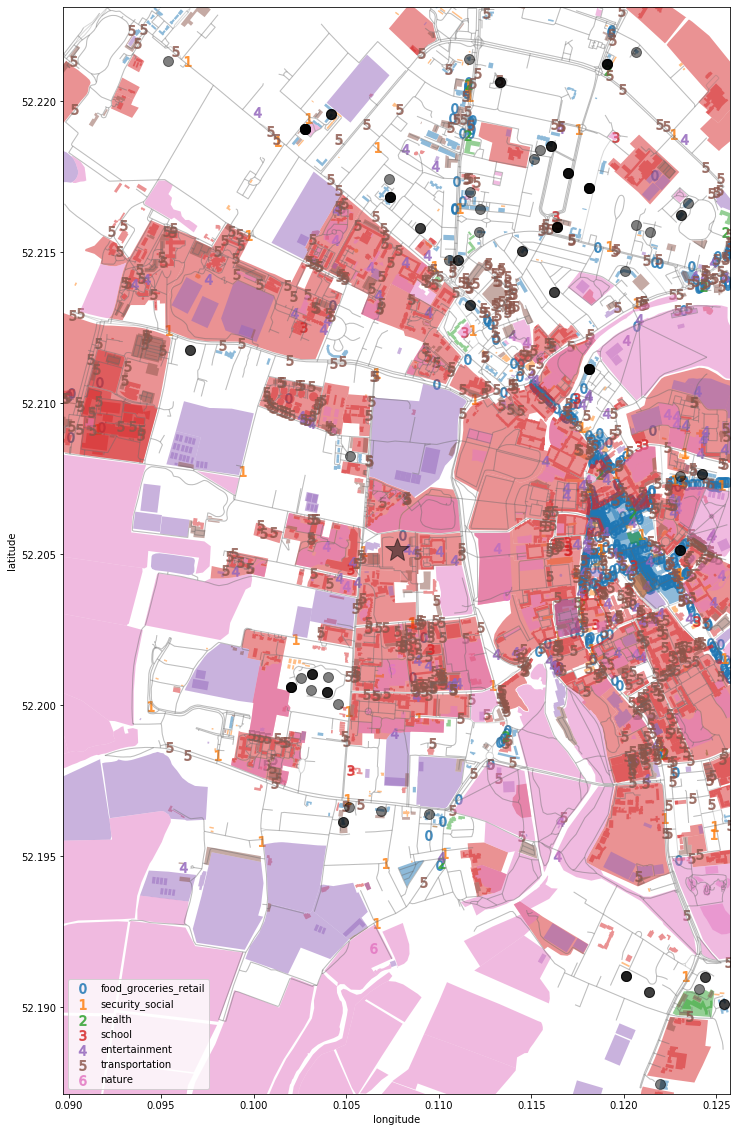

In [23]:
print()
print("################################")
print("# CHARACTERISATION OF AWS ROWS #")
print("################################")
# a modified version of assess.characterise_raw_ppdata_and_raw_podata(), which we've looked at before in Question 2
assess.characterise_aws_pppodata(  
    prediction_uuid, df_pppodata, print_banners=False
)

print()
print("##########################################################################")
print("# MAP AROUND PREDICTED PROPERTY (at the provided latitude and longitude) #")
print("##########################################################################")
fig, ax = plt.subplots(
    figsize=(constants.PLT_MAP_WIDTH, constants.PLT_MAP_HEIGHT))
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor="dimgray", alpha=0.25)
ax.set_xlim([west, east])
ax.set_ylim([south, north])
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
# Plot all POIs
for i, (category_name, gdf_pois_category) in enumerate(dict_of_gdf_pois_categories.items()):
    if "node" in gdf_pois_category.index:
        gdf_pois_category.loc["node"].plot(
            ax=ax,
            color=plt.rcParams["axes.prop_cycle"].by_key()["color"][
                i % len(plt.rcParams["axes.prop_cycle"].by_key()["color"])
            ],
            alpha=0.7,
            marker=f"${i}$",
            markersize=100,
            label=category_name
        )
    if "way" in gdf_pois_category.index:
        gdf_pois_category.loc["way"].plot(
            ax=ax,
            color=plt.rcParams["axes.prop_cycle"].by_key()["color"][
                i % len(plt.rcParams["axes.prop_cycle"].by_key()["color"])
            ],
            alpha=0.5
        )
ax.plot(
    longitude, latitude,
    marker="*",
    markersize=25,
    color="black",
    alpha=0.5
)
for i in range(len(gdf_pppodata)):    
    ax.plot(
        gdf_pppodata["longitude"][i],
        gdf_pppodata["latitude"][i],
        marker="o",
        markersize=10,
        color="black",
        alpha=0.5
    )
ax.legend()
plt.savefig(
    os.path.join(
        svg_output_dir,
        f"{prediction_uuid}_map_around_{latitude}-{longitude}.svg"
    )
)
plt.show()

Finally, feature generation. The following code generates the columns of the design matrix $\mathbf{x}$ of our training dataset. Basically massaging the data to get it to the correct form. There's a subtle catch: what if for some category, there happens to be no POIs near a particular training set property? What should we put for the distance to the closest one?

I make an assumption here: I assume that if I increased the length of the bounding box by a factor of 2, I'll be able to find it. Therefore, if $w$ is the original length of the bounding box, I assume that I can find the closest POI of that category at distance $\sqrt{2}w$, as shown in the following figure.

This logic is contained in `utils.find_degree_distance_to_closest_within_bounding_box_of_point()`.

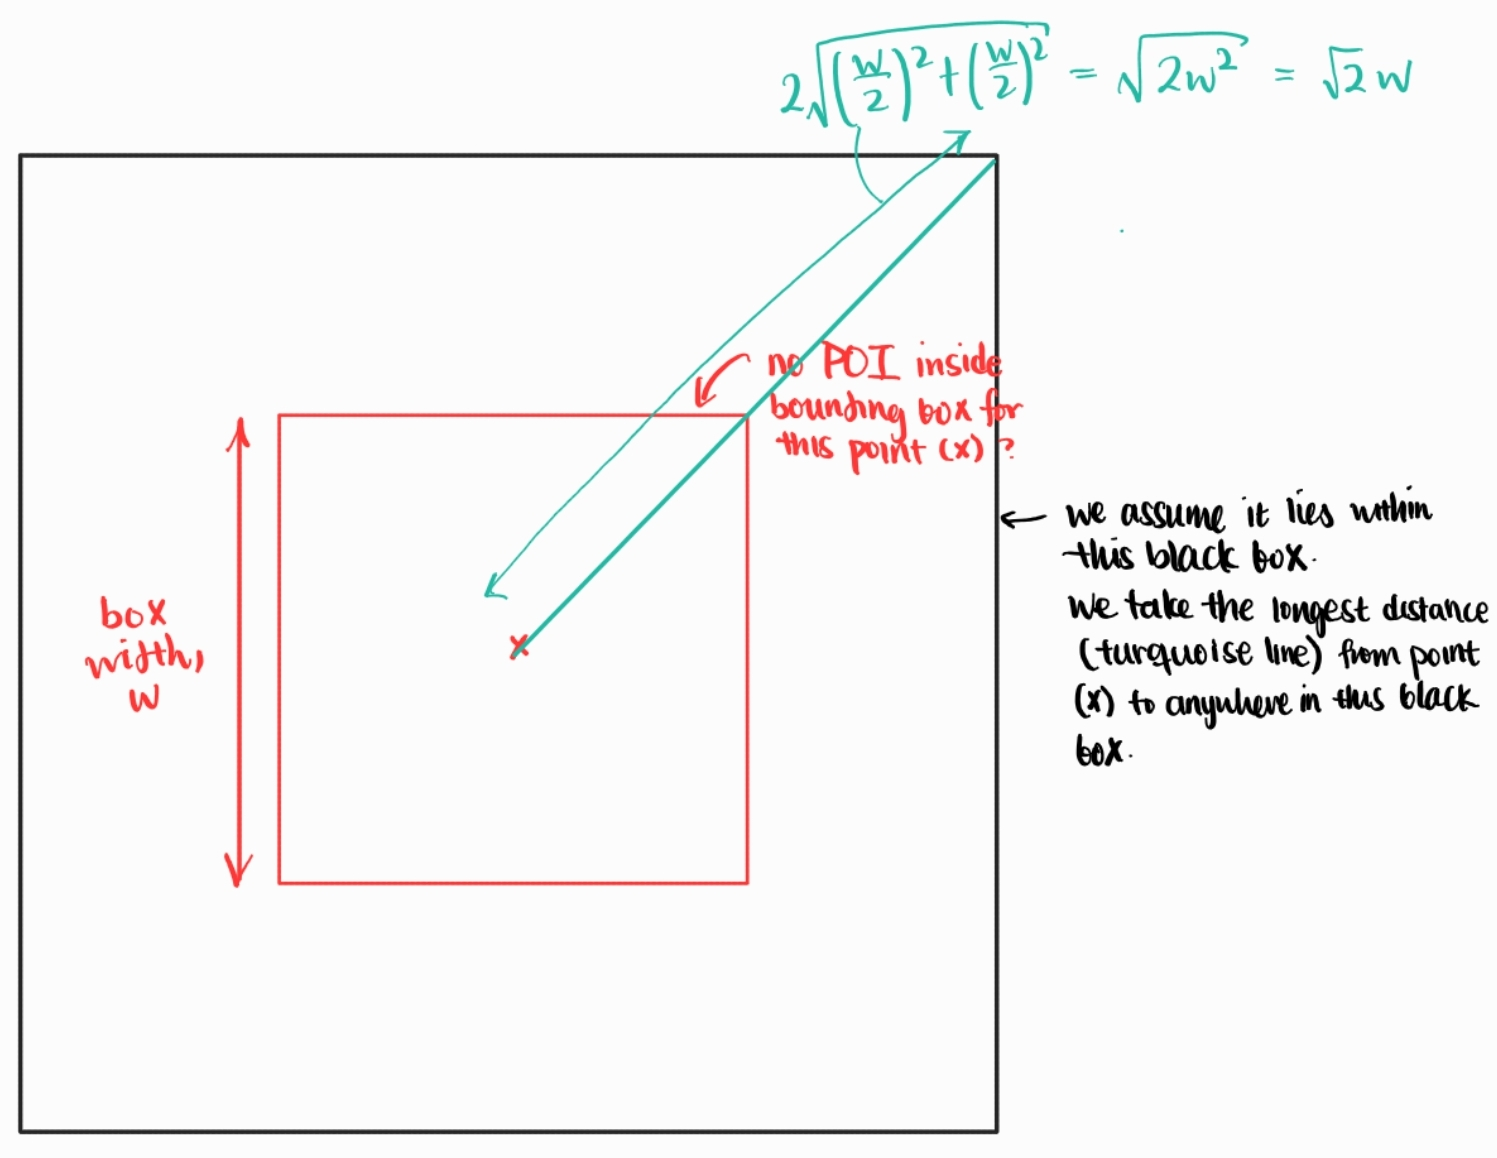

In [24]:
print()
print("######################")
print("# FEATURE GENERATION #")
print("######################")
# Feature generation
print("Generating features...")

# Train a linear model on the data set you have created.
for category_name, gdf_pois_category in tqdm(dict_of_gdf_pois_categories.items()):
    gdf_pppodata[f"{category_name}_count"] = gdf_pppodata["geometry"].apply(
        lambda geo: utils.find_number_within_bounding_box_of_point(
            geo,
            gdf_pois_category,
            box_width_km,
            box_height_km
        ))
    gdf_pppodata[f"{category_name}_closest_degree_distance"] = gdf_pppodata["geometry"].apply(
        lambda geo: utils.find_degree_distance_to_closest_within_bounding_box_of_point(
            geo,
            gdf_pois_category,
            box_width_km,
            box_height_km
        ))
feature_columns_names = [f"{category_name}_count" for category_name in dict_of_categories] + [
    f"{category_name}_closest_degree_distance" for category_name in dict_of_categories
]


######################
# FEATURE GENERATION #
######################
Generating features...


  0%|          | 0/7 [00:00<?, ?it/s]

And the following code also generates a design matrix, but this is for the point we want to predict. We'll use this (`prediction_point_features`) to obtain predictions.

In [25]:
prediction_point_geometry = shapely.geometry.Point(longitude, latitude)
prediction_point_features_dict = {}
for category_name, gdf_pois_category in tqdm(dict_of_gdf_pois_categories.items()):
    prediction_point_features_dict[f"{category_name}_count"] = utils.find_number_within_bounding_box_of_point(
        prediction_point_geometry,
        gdf_pois_category,
        box_width_km,
        box_height_km
    )
    prediction_point_features_dict[f"{category_name}_closest_degree_distance"] = utils.find_degree_distance_to_closest_within_bounding_box_of_point(
        prediction_point_geometry,
        gdf_pois_category,
        box_width_km,
        box_height_km
    )
# Transform each value into a list, as expected by pd.DataFrame.from_dict()
prediction_point_features_dict = {
    k: [v]
    for k, v in prediction_point_features_dict.items()
}
prediction_point_features = pd.DataFrame.from_dict(
    prediction_point_features_dict
)[feature_columns_names]
prediction_point_features.insert(0, "const", 1.0)  # Insert a ones column

  0%|          | 0/7 [00:00<?, ?it/s]

#### 4. Train a linear model on the data set you have created.

In the `predict_price()` function, I always train 2 models: the non-regularised one and the regularised one. This relies on the assumption that the fit of the regularised and non-regularised models would be similar.

The reason for this is due to a limitation of the `statsmodel` API:
- After doing a fit for a non-regularised model, we get confidence intervals for the predictions, but as the name suggests, no regularisation is done.
- After doing a fit for a regularised model, we unfortunately do not get any confidence intervals.


The following code snippet shows the code for training and printing out results in a few formats:
1. OLS Regression Results table (contains coefficients ($\beta$s) as `coef`)
2. OLS Regularised regression coefficients
3. A graph whose y-axis is price, x-axis is an index over our dataset (and thus has no semantic meaning!), and shows the following:
   - Mean prediction for each of training dataset's house in red dotted lines
   - The confidence interval for each datapoint's mean prediction in red shading
   - The mean prediction fro each of training dataset's house in black dotted lines

   I came up with this plotting strategy because otherwise, there's no way to visualise the confidence interval bands in the 15 dimensional space I'm working in. I've conducted some PCA analysis but I am currently unsure of how to use that to visualise things in the context of model evaluation.


########################
# MODEL AND PREDICTION #
########################

Training model (non-regularised)...

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     11.01
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           2.89e-14
Time:                        06:35:59   Log-Likelihood:                -1390.5
No. Observations:                 107   AIC:                             2811.
Df Residuals:                      92   BIC:                             2851.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)



Regularised model coefs:
β_const=344004.15123883064
β_food_groceries_retail_count=270.20303517525275
β_security_social_count=-6222.112347966323
β_health_count=-6287.3544375271385
β_school_count=988.8355534022181
β_entertainment_count=1314.4304615439983
β_transportation_count=-1024.728219569679
β_nature_count=1569.0294773085986
β_food_groceries_retail_closest_degree_distance=0.0
β_security_social_closest_degree_distance=-29869788.88829644
β_health_closest_degree_distance=3142373.1554646874
β_school_closest_degree_distance=30214784.587133866
β_entertainment_closest_degree_distance=-6986847.152519667
β_transportation_closest_degree_distance=98298303.60185586
β_nature_closest_degree_distance=22508064.531709198

Plotting model results... (NB: x axis has no meaning)


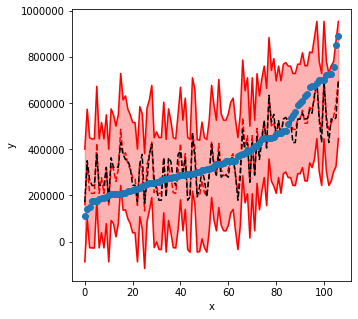

In [26]:
print()
print("########################")
print("# MODEL AND PREDICTION #")
print("########################")
# OLS
train_Y = gdf_pppodata.sort_values("price", ascending=True)["price"]
train_X = gdf_pppodata.sort_values("price", ascending=True)[
    feature_columns_names]
train_X = sm.add_constant(train_X)  # add ones column

print("\nTraining model (non-regularised)...")
model = sm.OLS(train_Y, train_X)
results = model.fit()
print()
print(results.summary())
Y_pred_of_train_X = results.get_prediction(
    train_X
).summary_frame(alpha=0.05)
Y_pred_of_train_X_mse = utils.mse(Y_pred_of_train_X["mean"], train_Y)

print("\nTraining model (regularised)...")
model_regularised = sm.OLS(train_Y, train_X)
results_regularised = model.fit_regularized(alpha=0.10, L1_wt=1.0)
# alpha is the significance level. Confidence interval is 1 - alpha.
Y_pred_of_train_X_regularised = results_regularised.predict(train_X)
Y_pred_of_train_X_regularised_mse = utils.mse(
    Y_pred_of_train_X_regularised, train_Y)
print()
print("Regularised model coefs:")
for i, (feature_name, beta) in enumerate(zip(train_X.columns, results_regularised.params)):
    print(f"β_{feature_name}={beta}")

print("\nPlotting model results... (NB: x axis has no meaning)")
fig, ax = plt.subplots(figsize=(constants.PLT_WIDTH, constants.PLT_HEIGHT))
ax.scatter(range(len(train_X)), train_Y, zorder=2)
# Non-regularised plot
ax.plot(range(len(train_X)),
        Y_pred_of_train_X['mean'], color='red', linestyle='--', zorder=1)
ax.plot(range(len(train_X)),
        Y_pred_of_train_X['obs_ci_lower'], color='red', linestyle='-', zorder=1)
ax.plot(range(len(train_X)),
        Y_pred_of_train_X['obs_ci_upper'], color='red', linestyle='-', zorder=1)
ax.fill_between(range(len(train_X)), Y_pred_of_train_X['obs_ci_lower'],
                Y_pred_of_train_X['obs_ci_upper'], color='red', alpha=0.3, zorder=1)
# Regularised plot
ax.plot(range(len(train_X)), Y_pred_of_train_X_regularised,
        color="black", linestyle='--', zorder=1)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In this example, we could provide the following narrative / interpretation for the coefficients:
```python
β_const=344004.15123883064  # "average"
β_food_groceries_retail_count=270.20303517525275  # presence [of POIs] increases price slightly [relative to the "average"] (for the rest, I won't write [these] out in full)
β_security_social_count=-6222.112347966323  # presence reduces price
β_health_count=-6287.3544375271385  # presence reduces price heavily
β_school_count=988.8355534022181  # presence increases price decently
β_entertainment_count=1314.4304615439983  # presence increases price decently
β_transportation_count=-1024.728219569679  # presence reduces price heavily
β_nature_count=1569.0294773085986  # presence reduces price heavily
β_food_groceries_retail_closest_degree_distance=0.0  # dropped by regulariser
β_security_social_closest_degree_distance=-29869788.88829644  # the closer the better (higher price)
β_health_closest_degree_distance=3142373.1554646874  # the closer the worse (lower price)
β_school_closest_degree_distance=30214784.587133866  # the closer the worse
β_entertainment_closest_degree_distance=-6986847.152519667  # the closer the better
β_transportation_closest_degree_distance=98298303.60185586  # the closer the worse
β_nature_closest_degree_distance=22508064.531709198  # the closer the worse
```
Perhaps:
- For food/groceries/retail, presence is much more important than distance (doesn't matter)?
- For security/social, people in this area like to live near one very much, but don't want too many of these?
- For health, people in this area just don't want to live near these?
- For school, people in this area like to live near schools but not too close (perhaps because schools are noisy)?
- For entertainment, people in this area like to live near lots of them, and really near them. What I defined as entertainment actually mostly refers to sports facilities, so perhaps this region is conducive for sporting?
- For transportation, people in this area just don't want to live near bus stops and the like?
- For nature, people in this area just don't want to live near these, perhaps because of bugs?

(These are complete speculation and shouldn't be seen as rigorous reasoning. These may be worth discussing with a domain expert, which may highlight potential flaws in my assumptions.)

#### 5. Validate the quality of the model.
The quality of the non-regularised model can be inspected via looking at the printouts from the previous cell. I usually look at the `log-likelihood`, `std err`, `[0.025` and `0.975]` (95% confidence interval) values.

However, the `statsmodels` library doesn't provide any evaluation metrics for the regularised model. 

I've decided to do a mean squared error (MSE) calculation for both models: get each model to predict prices for the training dataset points `train_X`, and then calculate the MSE. Using MSE as a metric makes sense because we are doing standard linear regression by using `statsmodels.api.OLS`, which carries out maximum likelihood estimation using least squares (also seen in the `OLS Regression Results` printout above, under `Method`).

A lower MSE is better.


Prediction (non-regularised model; MSE=11356310447.228935):
            mean       mean_se  mean_ci_lower  mean_ci_upper   obs_ci_lower  \
0  489174.754033  90396.612313   309639.27923  668710.228836  198775.040433   

    obs_ci_upper  
0  779574.467634  

Prediction (regularised model; MSE=12326768774.419752):
0    496796.805119
dtype: float64



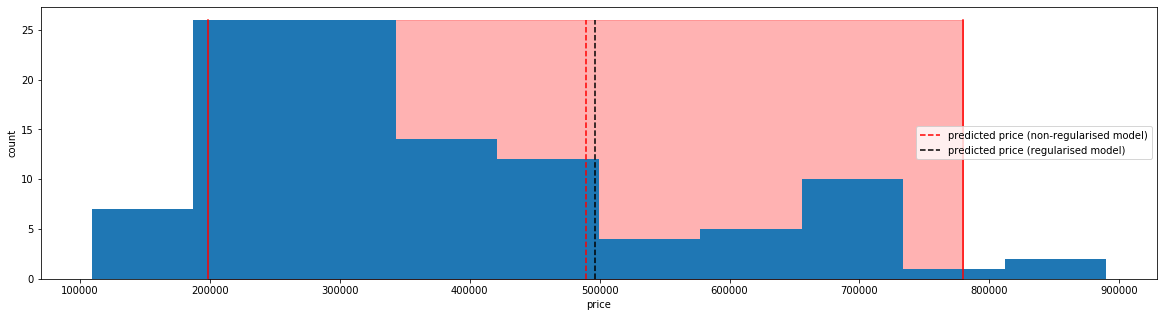

In [27]:
Y_pred_of_prediction_point = results.get_prediction(
    prediction_point_features).summary_frame(alpha=0.05)
print()
print(
    f"Prediction (non-regularised model; MSE={Y_pred_of_train_X_mse}):\n{Y_pred_of_prediction_point}")
print()
Y_pred_of_prediction_point_regularised = results_regularised.predict(
    prediction_point_features)
print(
    f"Prediction (regularised model; MSE={Y_pred_of_train_X_regularised_mse}):\n{Y_pred_of_prediction_point_regularised}")
print()

final_prediction = Y_pred_of_prediction_point["mean"][0]
final_prediction_obs_ci_lower = Y_pred_of_prediction_point["obs_ci_lower"][0]
final_prediction_obs_ci_upper = Y_pred_of_prediction_point["obs_ci_upper"][0]
final_prediction_regularised = Y_pred_of_prediction_point_regularised[0]
fig, ax = plt.subplots(
    figsize=(constants.PLT_WIDTH_LARGE, constants.PLT_HEIGHT))
hist_values, _, _ = ax.hist(
    gdf_pppodata["price"],
    # between 10 to 1000 bins
    bins=np.clip(len(gdf_pppodata["date_of_transfer_dt"]) // 10, 10, 1000)
)
ax.plot(
    [final_prediction, final_prediction],
    [0, hist_values.max()],
    color="red",
    linestyle="--",
    label="predicted price (non-regularised model)"
)
ax.plot(
    [final_prediction_obs_ci_lower, final_prediction_obs_ci_lower],
    [0, hist_values.max()],
    color="red",
    linestyle="-",
)
ax.plot(
    [final_prediction_obs_ci_upper, final_prediction_obs_ci_upper],
    [0, hist_values.max()],
    color="red",
    linestyle="-",
)
ax.fill_betweenx([0, hist_values.max()], final_prediction_obs_ci_lower,
                    final_prediction_obs_ci_upper, color='red', alpha=0.3)
ax.plot(
    [final_prediction_regularised, final_prediction_regularised],
    [0, hist_values.max()],
    color="black",
    linestyle="--",
    label="predicted price (regularised model)"
)
ax.legend()
ax.set_xlabel("price")
ax.set_ylabel("count")
plt.show()

#### 6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

Since I have a MSE value for both the non-regularised and regularised model, I use this to pick the better model, whose prediction I output from `predict_prices()`.

In [28]:
if final_prediction_obs_ci_lower < 0:
    print("WARNING: Lower end of confidence interval lies below 0 pounds!")
# prefer prediction from regularised model if MSE of regularised model is smaller than the non-regularised model
if Y_pred_of_train_X_regularised_mse < Y_pred_of_train_X_mse:
    print("Outputting prediction of regularised model (black dotted line)")
    output = final_prediction_regularised
else:
    print("Outputting prediction of non-regularised model (red dotted line)")
    output = final_prediction
if output < gdf_pppodata["price"].min() or output > gdf_pppodata["price"].max():
    print("WARNING: The predicted value lies outside of the training dataset's range!")
print(output)  # actually a return statement in the fynesse package

Outputting prediction of non-regularised model (red dotted line)
489174.7540331681


I'll warn if the lower half of the confidence interval of the non-regularised model falls below 0, or if the output prediction lies outside the range of prices in the training dataset. These indicate that something terrible has gone wrong. 

Big confidence intervals seem to be the norm for my method despite best efforts, so I won't display warnings regardless of the size of the confidence interval, as long as it doesn't include negative prices.

### Distance Matrices and PCA Analysis
I tried to perform distance matrices and PCA analysis.

We want features with maximal variance: features with minimum variance are unlikely to help with prediction. Since prices have a big variance (from 1 to 600 million), we need high variance features to be able to map to the high variance space of prices. (the same idea as the "fine definition" and "coarse definition" idea I mentioned earlier in this notebook). PCA can somewhat help us find these high variance features that can separate the dataset into clusters.

In [29]:
gdf_pppodata

price date_of_transfer postcode property_type new_build_flag  \
0    455000       2021-01-20  CB3 0DL             F              N   
1    450000       2021-06-18  CB3 0EL             F              N   
2    675000       2021-12-15  CB3 0EL             F              N   
3    510000       2020-09-11  CB3 9BH             F              N   
4    470000       2020-08-26  CB3 9BH             F              N   
..      ...              ...      ...           ...            ...   
102  465000       2022-04-19  CB1 1LJ             F              N   
103  320000       2020-10-02  CB2 8AY             F              N   
104  255000       2021-07-07  CB2 8AY             F              N   
105  400000       2020-07-20  CB2 8AN             F              N   
106  392500       2022-09-21  CB2 8AN             F              N   

    tenure_type ppd_category_type record_status status usertype  ...  \
0             L                 A             A   live    small  ...   
1             L                 A             A   live    small  ...   
2             L                 A             A   live    small  ...   
3             L                 A             A   live    small  ...   
4             L                 A             A   live    small  ...   
..          ...               ...           ...    ...      ...  ...   
102           L                 A             A   live    small  ...   
103           L                 A             A   live    small  ...   
104           L                 A             A   live    small  ...   
105           L                 A             A   live    small  ...   
106           L                 A             A   live    small  ...   

     health_count health_closest_degree_distance school_count  \
0               0                       0.025456           94   
1               0                       0.025456          189   
2               0                       0.025456          189   
3               3                       0.008460          255   
4               3                       0.008460          255   
..            ...                            ...          ...   
102             8                       0.003853          462   
103             4                       0.000439          117   
104             4                       0.000439          117   
105             4                       0.000579          103   
106             4                       0.000579          103   

    school_closest_degree_distance entertainment_count  \
0                         0.001265                  19   
1                         0.000380                  66   
2                         0.000380                  66   
3                         0.000184                 103   
4                         0.000184                 103   
..                             ...                 ...   
102                       0.000441                 103   
103                       0.001427                  23   
104                       0.001427                  23   
105                       0.001020                  20   
106                       0.001020                  20   

     entertainment_closest_degree_distance  transportation_count  \
0                                 0.001837                    81   
1                                 0.000965                   218   
2                                 0.000965                   218   
3                                 0.001583                   206   
4                                 0.001583                   206   
..                                     ...                   ...   
102                               0.000586                   355   
103                               0.004055                    84   
104                               0.004055                    84   
105                               0.004846                    72   
106                               0.004846                    72   

     

In [30]:
feature_columns_names

['food_groceries_retail_count',
 'security_social_count',
 'health_count',
 'school_count',
 'entertainment_count',
 'transportation_count',
 'nature_count',
 'food_groceries_retail_closest_degree_distance',
 'security_social_closest_degree_distance',
 'health_closest_degree_distance',
 'school_closest_degree_distance',
 'entertainment_closest_degree_distance',
 'transportation_closest_degree_distance',
 'nature_closest_degree_distance']

In [31]:
gdf_pppodata["date_of_transfer_dt"]

0     2021-01-20
1     2021-06-18
2     2021-12-15
3     2020-09-11
4     2020-08-26
         ...    
102   2022-04-19
103   2020-10-02
104   2021-07-07
105   2020-07-20
106   2022-09-21
Name: date_of_transfer_dt, Length: 107, dtype: datetime64[ns]

In [32]:
gdf_pppodata["date_of_transfer_ts"] = gdf_pppodata["date_of_transfer_dt"].apply(datetime.timestamp)

In [33]:
gdf_pppodata.columns

Index(['price', 'date_of_transfer', 'postcode', 'property_type',
       'new_build_flag', 'tenure_type', 'ppd_category_type', 'record_status',
       'status', 'usertype', 'positional_quality_indicator', 'latitude',
       'longitude', 'geometry', 'date_of_transfer_dt',
       'food_groceries_retail_count',
       'food_groceries_retail_closest_degree_distance',
       'security_social_count', 'security_social_closest_degree_distance',
       'health_count', 'health_closest_degree_distance', 'school_count',
       'school_closest_degree_distance', 'entertainment_count',
       'entertainment_closest_degree_distance', 'transportation_count',
       'transportation_closest_degree_distance', 'nature_count',
       'nature_closest_degree_distance', 'date_of_transfer_ts'],
      dtype='object')

In [34]:
pca_columns = ["price", "date_of_transfer_ts"] + feature_columns_names
gdf_pppodata2 = gdf_pppodata.loc[:, pca_columns]

Now, which of these are sensible?


Distance matrix plots are sensitive to the scale of each column... So we need to normalise first.

In [35]:
import scipy

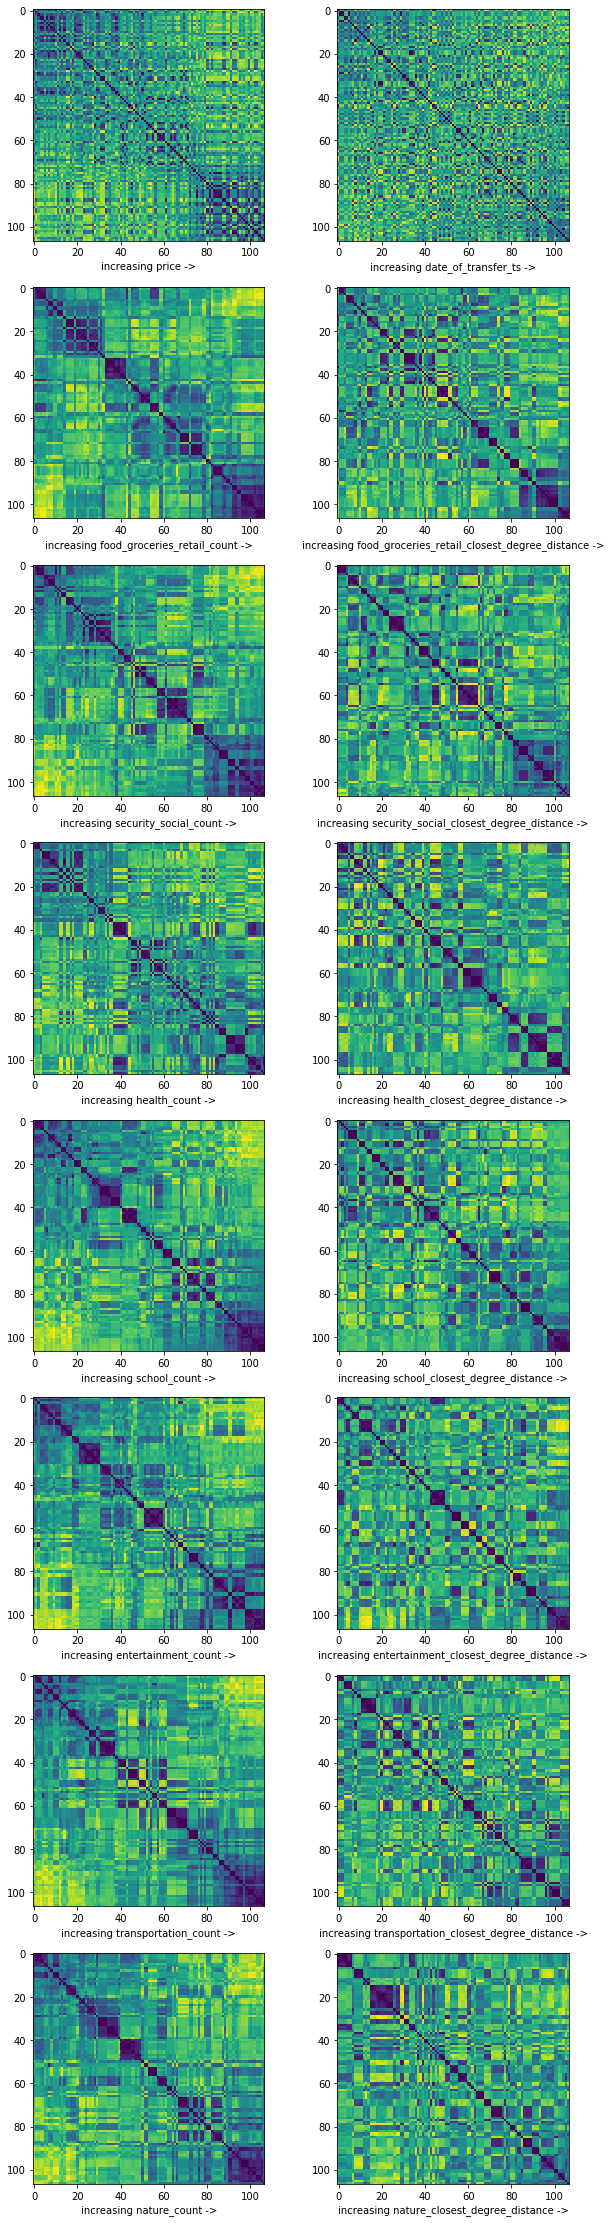

In [36]:
gdf_pppodata2_normalised = gdf_pppodata2.copy()
for col_name in gdf_pppodata2_normalised.columns:
    gdf_pppodata2_normalised[col_name] = (gdf_pppodata2_normalised[col_name] - gdf_pppodata2_normalised[col_name].mean()) / gdf_pppodata2_normalised[col_name].std()

fig_nrows = 1 + len(dict_of_gdf_pois_categories)
fig_ncols = 2
fig, axs = plt.subplots(fig_nrows, fig_ncols, figsize=(fig_ncols * 5, fig_nrows * 5))
assert fig_nrows > 1

gdf_pppodata2_normalised_sorted = gdf_pppodata2_normalised.sort_values("price")
distance_matrix = scipy.spatial.distance.cdist(gdf_pppodata2_normalised_sorted, gdf_pppodata2_normalised_sorted, metric="cosine")
im = axs[0][0].imshow(distance_matrix)
axs[0][0].set_xlabel("increasing price ->")

gdf_pppodata2_normalised_sorted = gdf_pppodata2_normalised.sort_values("date_of_transfer_ts")
distance_matrix = scipy.spatial.distance.cdist(gdf_pppodata2_normalised_sorted, gdf_pppodata2_normalised_sorted, metric="cosine")
im = axs[0][1].imshow(distance_matrix)
axs[0][1].set_xlabel("increasing date_of_transfer_ts ->")

for i, category_name in enumerate(dict_of_gdf_pois_categories):
    gdf_pppodata2_normalised_sorted = gdf_pppodata2_normalised.sort_values(f"{category_name}_count")
    distance_matrix = scipy.spatial.distance.cdist(gdf_pppodata2_normalised_sorted, gdf_pppodata2_normalised_sorted, metric="cosine")
    im = axs[i + 1][0].imshow(distance_matrix)
    axs[i + 1][0].set_xlabel(f"increasing {category_name}_count ->")

    gdf_pppodata2_normalised_sorted = gdf_pppodata2_normalised.sort_values(f"{category_name}_closest_degree_distance")
    distance_matrix = scipy.spatial.distance.cdist(gdf_pppodata2_normalised_sorted, gdf_pppodata2_normalised_sorted, metric="cosine")
    im = axs[i + 1][1].imshow(distance_matrix)
    axs[i + 1][1].set_xlabel(f"increasing {category_name}_closest_degree_distance ->")

plt.show()

Regions of dark squares near the main diagonal are interesting: that's where (cosine) similarity is high (in `cdist`, cosine distance of two vectors $\boldsymbol{x}$ and $\boldsymbol{y}$ is calculated as $1-\hat{\boldsymbol{x}}\cdot\hat{\boldsymbol{y}}$ where hat means normalised to unit length) for data points that have a similar of that metric, so dark patches (low values) indicate high similarity. This is a hallmark of a good differentiator: the metric is able to capture the fact that those data points are similar.

But these rely on the assumption that all dimensions are equally important.

PCA tells us what linear combination of variables is most suitable for **clustering** the data.

transportation_count                             0.402181
school_count                                     0.395824
security_social_count                            0.390070
nature_count                                     0.374067
food_groceries_retail_count                      0.346606
entertainment_count                              0.343224
nature_closest_degree_distance                   0.192015
entertainment_closest_degree_distance            0.185725
health_count                                     0.176666
school_closest_degree_distance                   0.161852
food_groceries_retail_closest_degree_distance    0.119141
transportation_closest_degree_distance           0.067924
health_closest_degree_distance                   0.047983
security_social_closest_degree_distance          0.039366
price                                            0.010457
date_of_transfer_ts                              0.003943
Name: comp_00, dtype: float64

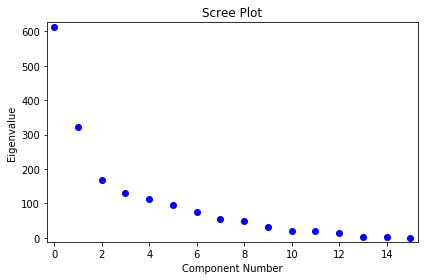

In [37]:
from statsmodels.multivariate.pca import PCA
pca = PCA(gdf_pppodata2)
pca.plot_scree(log_scale=False)
pca.loadings.iloc[:, 0].abs().sort_values(ascending=False)

This gives us a hint as to which categories are more important. Since all columns are normalised (by `statsmodels.multivariate.pca.PCA()`) before PCA is performed, relative scalings between columns don't matter (it doesn't matter that the price column is in the millions, but the distances are less than 1).

From the loadings table, looking at the first column, we can interpret this as the proportion of each category (and also price) that makes up PC1. The absolute magnitude is what matters. 

For this particular chosen `latitude` and `longitude` we wished to predict a price for, we can see that count measures generally play a bigger role in PC1 than the distance measures. Interestingly, the `health_count` feature is an outlier among the count features. Of the count features, the `transportation_count` feature is the most important in PC1, although it's not far in the lead.

These distance analysis and PCA analyses can be repeated for each training dataset (subsets of the entire database), and can yield interesting insights as demonstrated here, but it's mainly useful for clustering data points. It's not directly useful for telling us which features are good: L1 regularisation is a more direct way of achieving that: L1 regularisers try to push unneeded features' coefficients to 0.

In [38]:
# Refuses to work, perhaps due to dependency error (matplotlib too old?) Matplotlib must be 3.1.3 for the earlier plots to work.
# Placing this here for future reference: this is a good way to quickly generate scatter plots between columns.

# pd.plotting.scatter_matrix(gdf_pppodata[["price"] + feature_columns_names], figsize=(100, 100))

# Sample Predictions (From Tick 4)
NB: The results I get here are slightly different from what I produced during the Tick 4 lab session in the Intel Lab.

## Seaside apartment
Flat\
Latitude: 50.7693314\
Longitude: 0.1285943

The UUID for this prediction is: 2b745ece-eb7c-45f7-8e0c-2b7dba5d3228. All saved figures will be labelled with this UUID.

#################
# FETCHING DATA #
#################
Querying rows from AWS...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 34 rows from AWS.
Getting POIs from OSM...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 152 POIs in the bounding box around latitude=50.7693314, longitude=0.1285943.
Getting edges from OSM for plotting...


/usr/local/lib/python3.8/dist-packages/fynesse/address.py:156: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  gdf_pois.drop("relation", inplace=True)


  0%|          | 0/1 [00:00<?, ?it/s]

Got edges from OSM for plotting.

################################
# CHARACTERISATION OF AWS ROWS #
################################
Number of rows: 34
Minimum price over all rows: 94000
Maximum price over all rows: 545000

ppdata_and_podata_distributions plot:



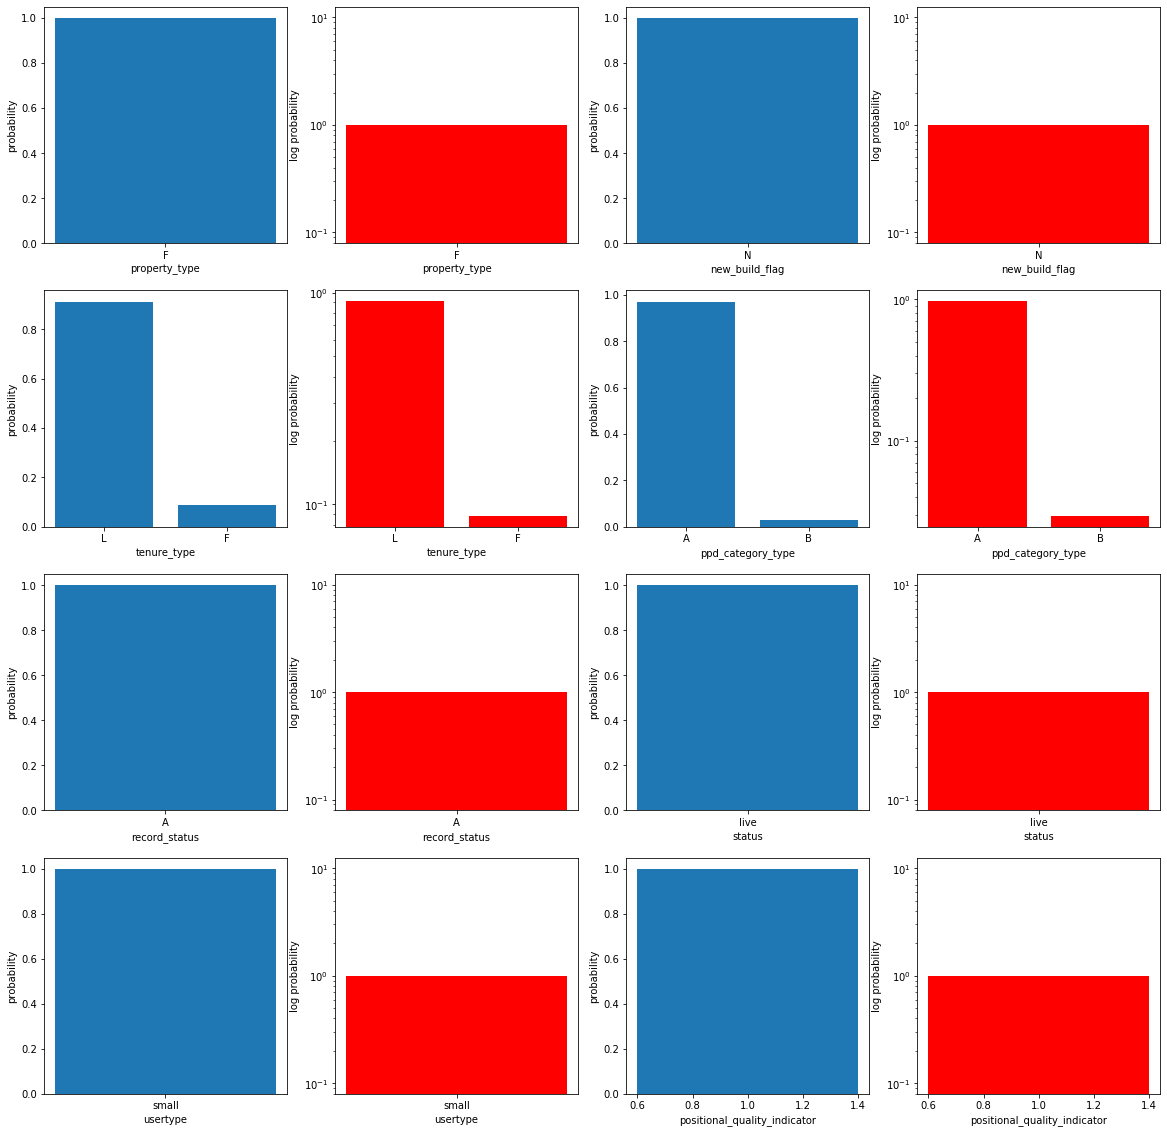



pppodata_distributions plot:



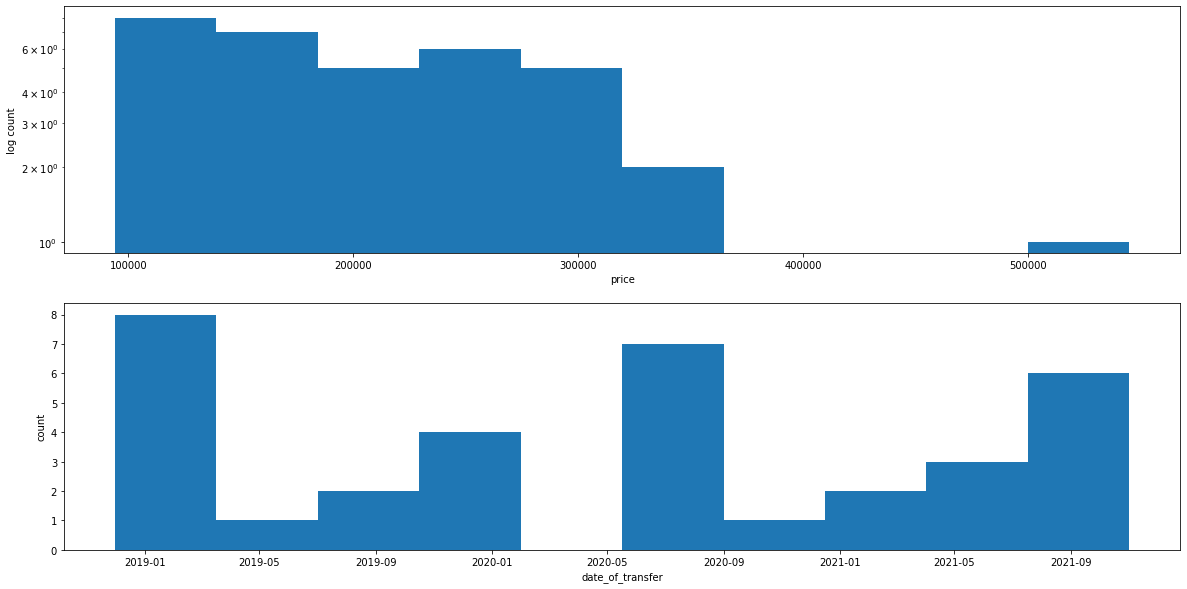



price plots for given property_type:



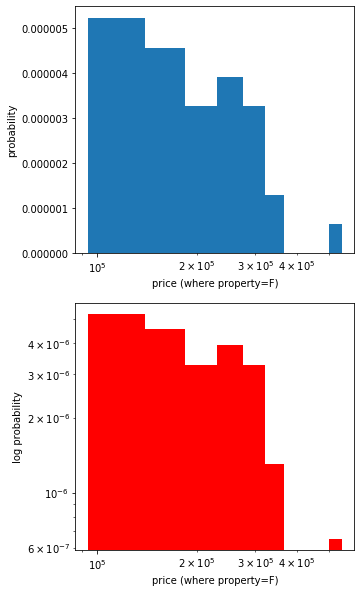



pppodata_latlong_distribution:



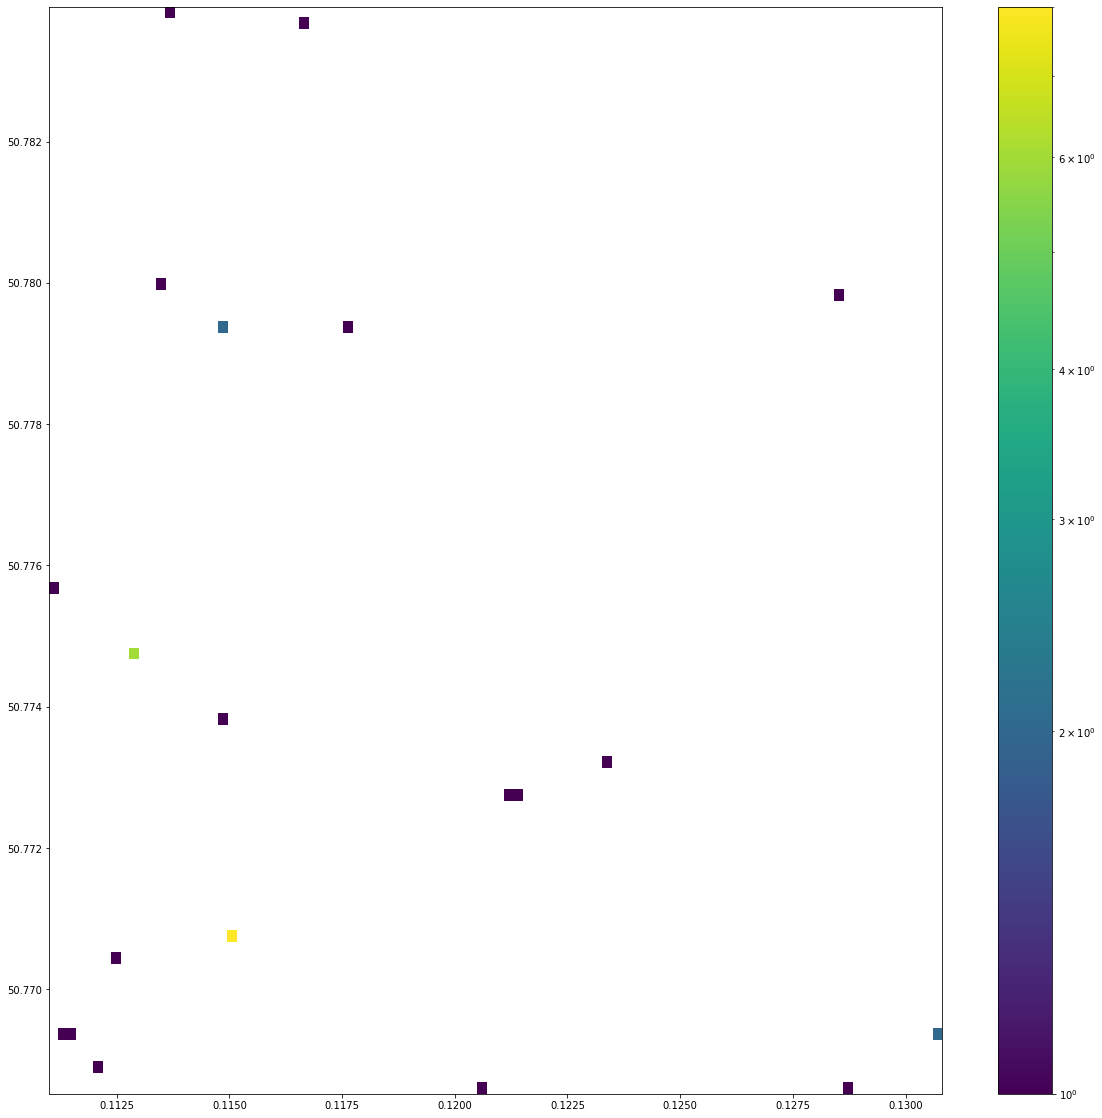



##########################################################################
# MAP AROUND PREDICTED PROPERTY (at the provided latitude and longitude) #
##########################################################################


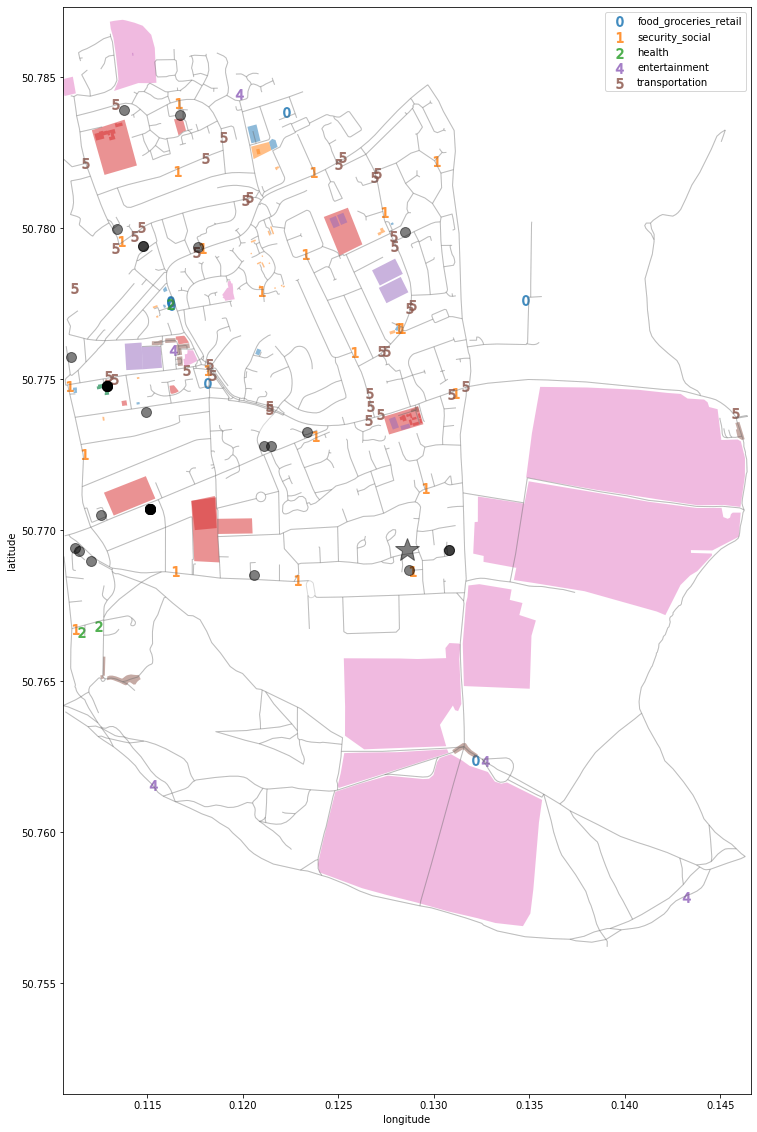


######################
# FEATURE GENERATION #
######################
Generating features...


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


########################
# MODEL AND PREDICTION #
########################

Training model (non-regularised)...

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     3.952
Date:                Fri, 02 Dec 2022   Prob (F-statistic):            0.00313
Time:                        06:36:37   Log-Likelihood:                -414.20
No. Observations:                  34   AIC:                             858.4
Df Residuals:                      19   BIC:                             881.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [

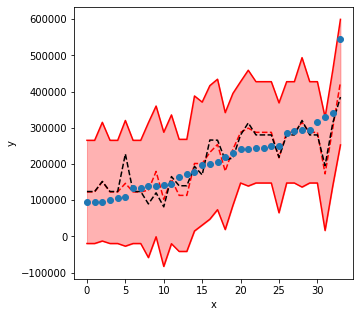


Prediction (non-regularised model; MSE=2232851205.7681947):
            mean       mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  247631.890445  56294.111544  129806.960862  365456.820027  70469.359877   

    obs_ci_upper  
0  424794.421012  

Prediction (regularised model; MSE=2831335073.56509):
0    275427.351439
dtype: float64



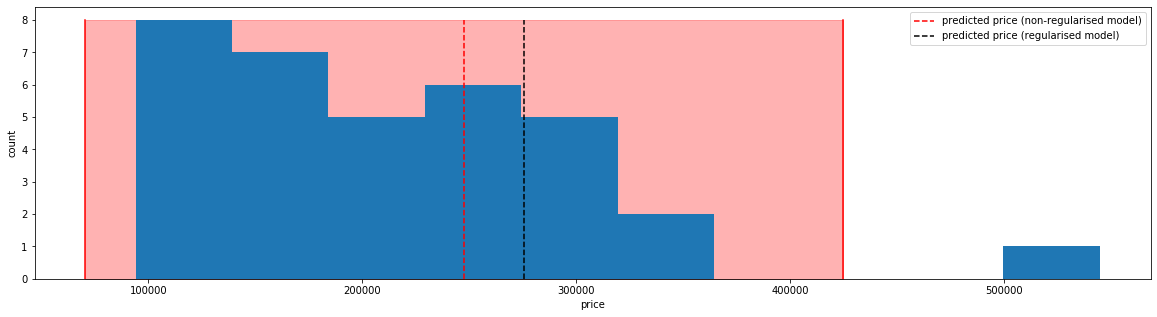

Outputting prediction of non-regularised model (red dotted line)


247631.8904446037

In [39]:
address.predict_price(50.7693314, 0.1285943, "2021-11-29 00:00", "F")

## Sheffield
Detached house\
Latitude: 53.3589907\
Longitude: -1.491815

The UUID for this prediction is: 5396ab31-3dd4-4d60-9cfe-a76c4745f99f. All saved figures will be labelled with this UUID.

#################
# FETCHING DATA #
#################
Querying rows from AWS...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 275 rows from AWS.
Getting POIs from OSM...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 1826 POIs in the bounding box around latitude=53.3589907, longitude=-1.491815.
Getting edges from OSM for plotting...


/usr/local/lib/python3.8/dist-packages/fynesse/address.py:156: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  gdf_pois.drop("relation", inplace=True)


  0%|          | 0/1 [00:00<?, ?it/s]

Got edges from OSM for plotting.

################################
# CHARACTERISATION OF AWS ROWS #
################################
Number of rows: 275
Minimum price over all rows: 120000
Maximum price over all rows: 1150000

ppdata_and_podata_distributions plot:



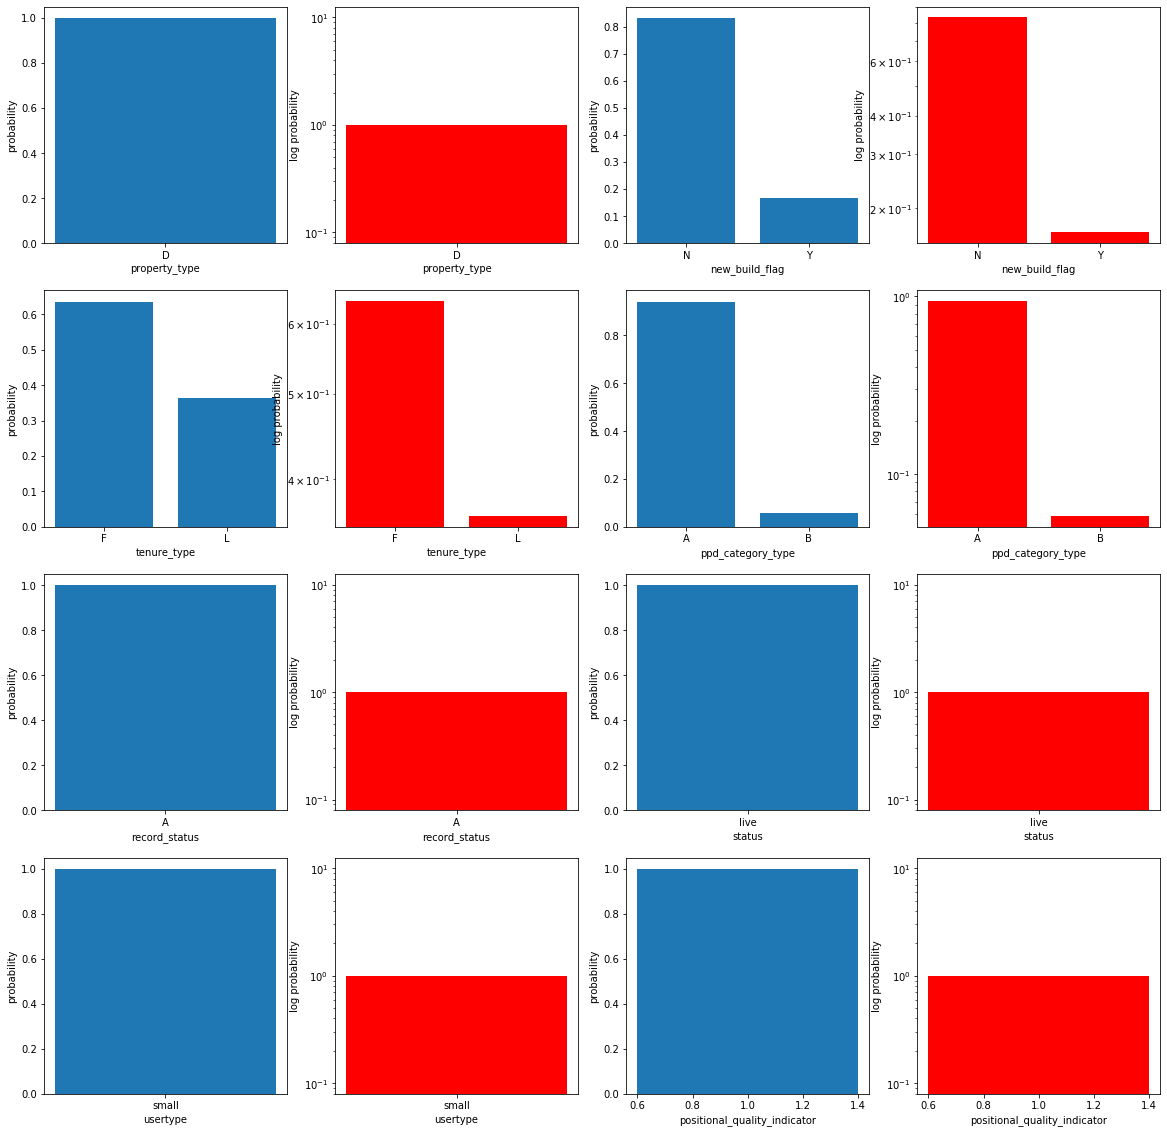



pppodata_distributions plot:



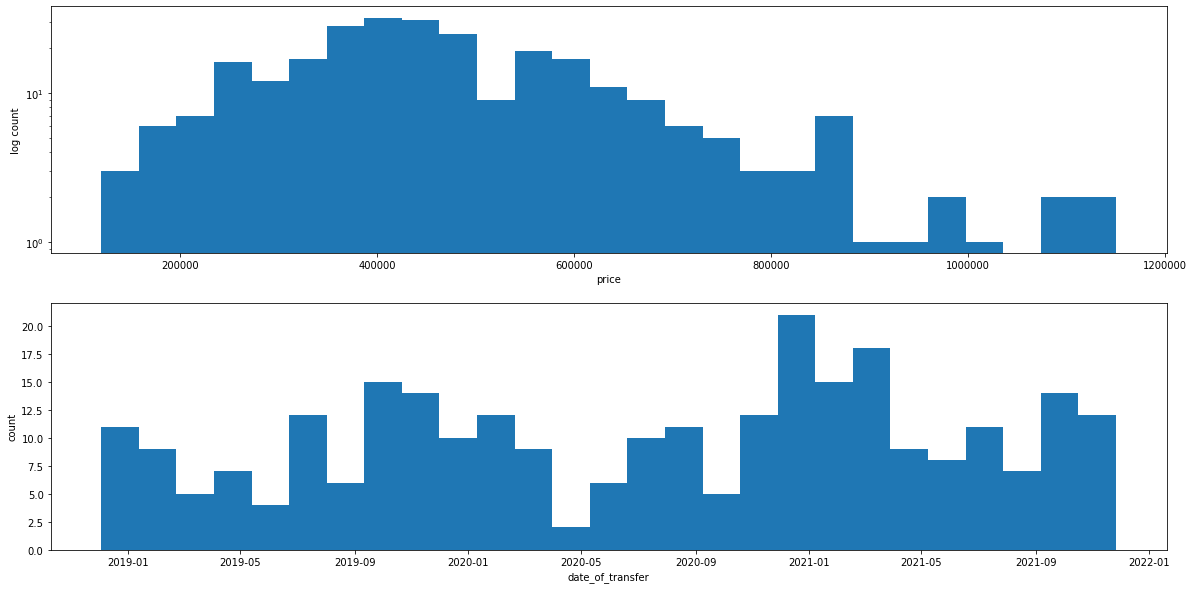



price plots for given property_type:



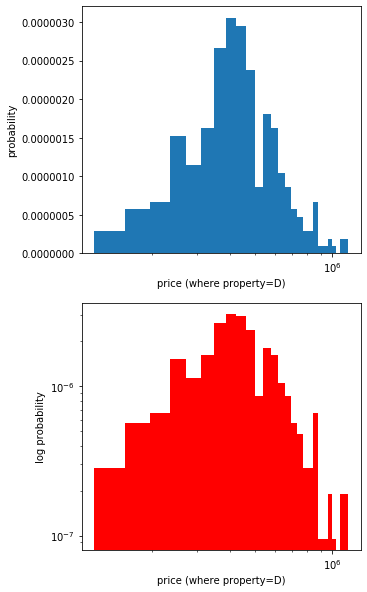



pppodata_latlong_distribution:



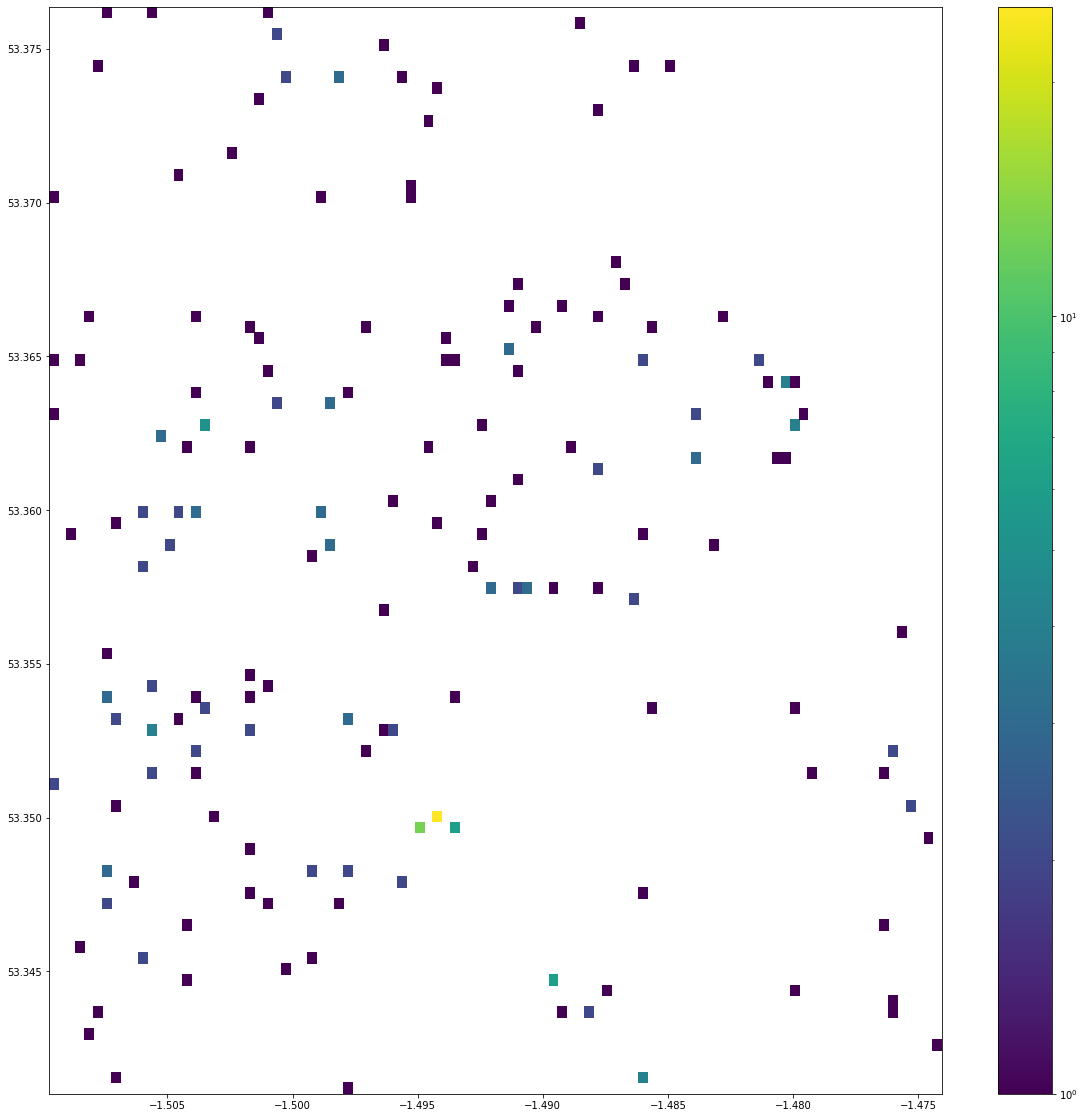



##########################################################################
# MAP AROUND PREDICTED PROPERTY (at the provided latitude and longitude) #
##########################################################################


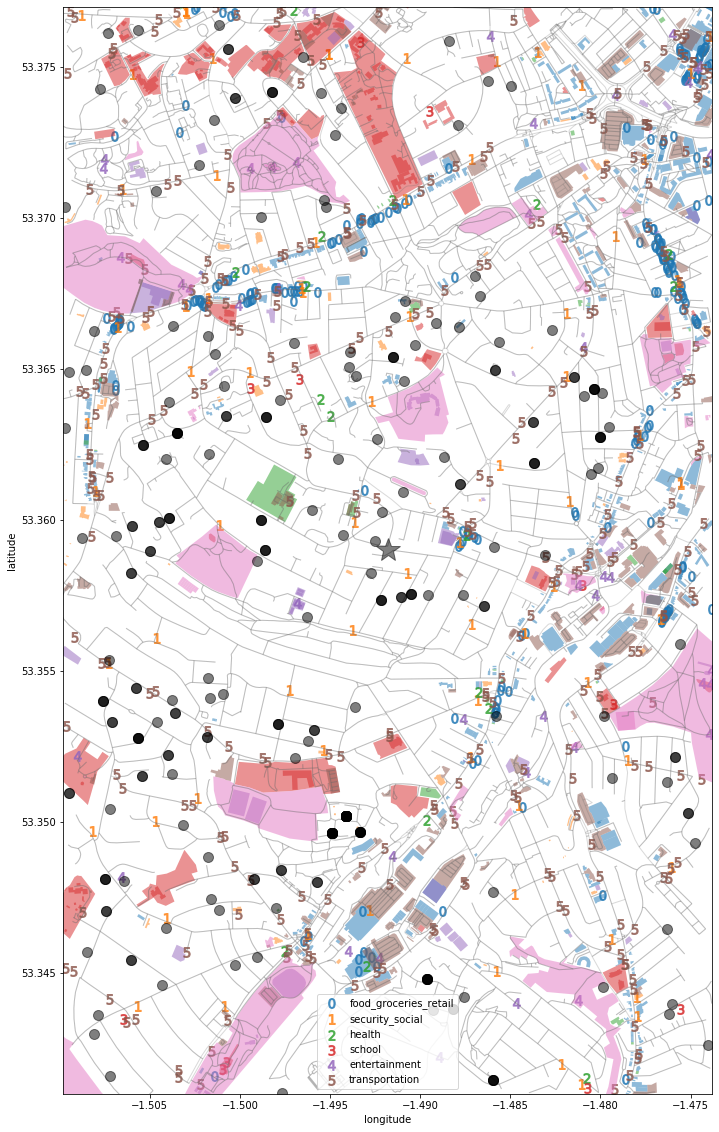


######################
# FEATURE GENERATION #
######################
Generating features...


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


########################
# MODEL AND PREDICTION #
########################

Training model (non-regularised)...

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     4.459
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           3.60e-07
Time:                        06:37:47   Log-Likelihood:                -3701.1
No. Observations:                 275   AIC:                             7432.
Df Residuals:                     260   BIC:                             7486.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [

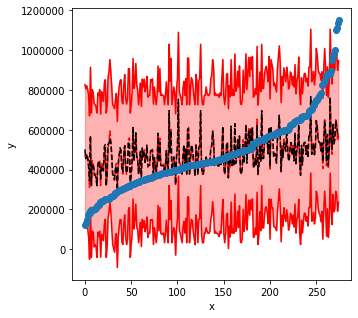


Prediction (non-regularised model; MSE=28670270129.115993):
            mean      mean_se  mean_ci_lower  mean_ci_upper   obs_ci_lower  \
0  543968.308972  43507.64343   458296.10292  629640.515025  190525.988054   

    obs_ci_upper  
0  897410.629891  

Prediction (regularised model; MSE=28825908561.833115):
0    538599.336717
dtype: float64



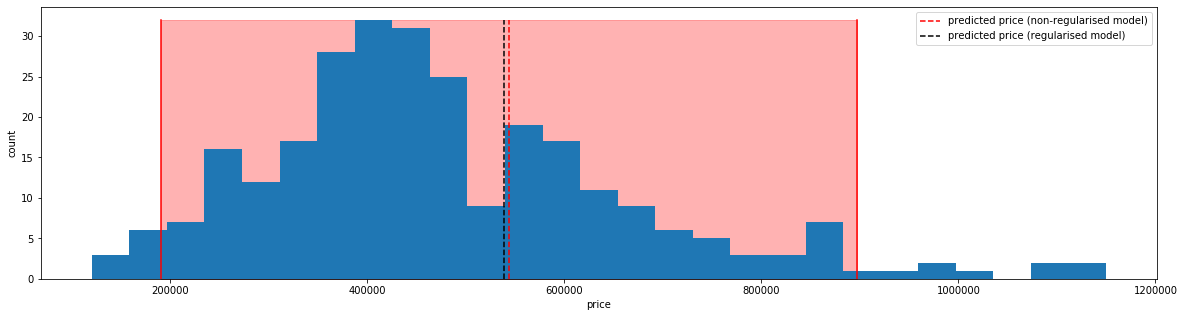

Outputting prediction of non-regularised model (red dotted line)


543968.3089722559

In [40]:
address.predict_price(53.3589907, -1.491815, "2021-11-29 00:00", "D")

## near London
Semidetached House\
Latitude: 51.3815042\
Longitude: -0.2554954

The UUID for this prediction is: 25d92a18-bcd7-4790-8a0b-434416383d6c. All saved figures will be labelled with this UUID.

#################
# FETCHING DATA #
#################
Querying rows from AWS...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 732 rows from AWS.
Getting POIs from OSM...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 995 POIs in the bounding box around latitude=51.3815042, longitude=-0.2554954.
Getting edges from OSM for plotting...


/usr/local/lib/python3.8/dist-packages/fynesse/address.py:156: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  gdf_pois.drop("relation", inplace=True)


  0%|          | 0/1 [00:00<?, ?it/s]

Got edges from OSM for plotting.

################################
# CHARACTERISATION OF AWS ROWS #
################################
Number of rows: 732
Minimum price over all rows: 250000
Maximum price over all rows: 1350000

ppdata_and_podata_distributions plot:



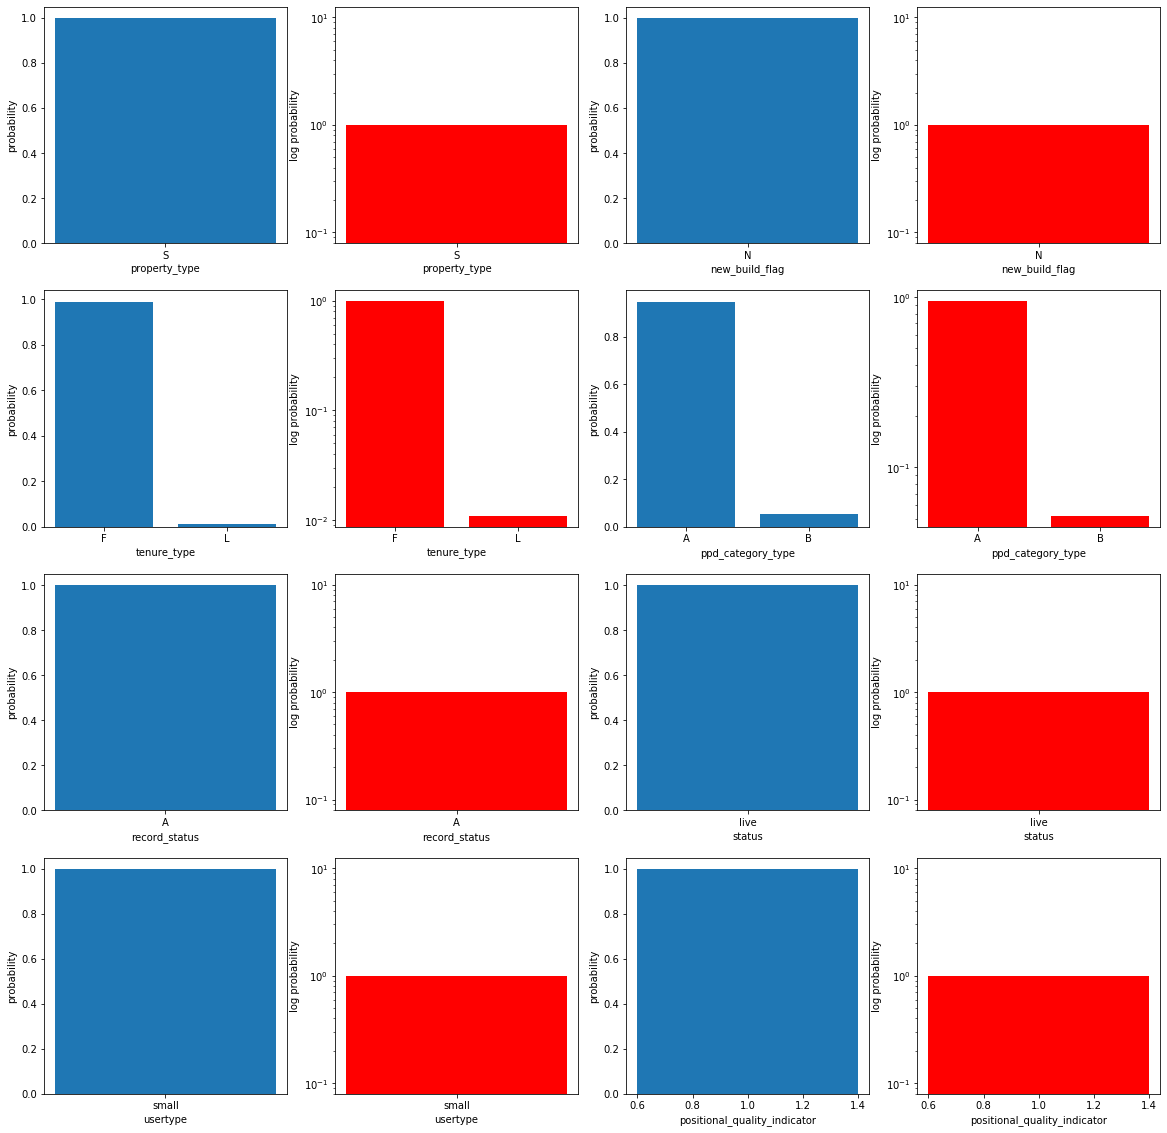



pppodata_distributions plot:



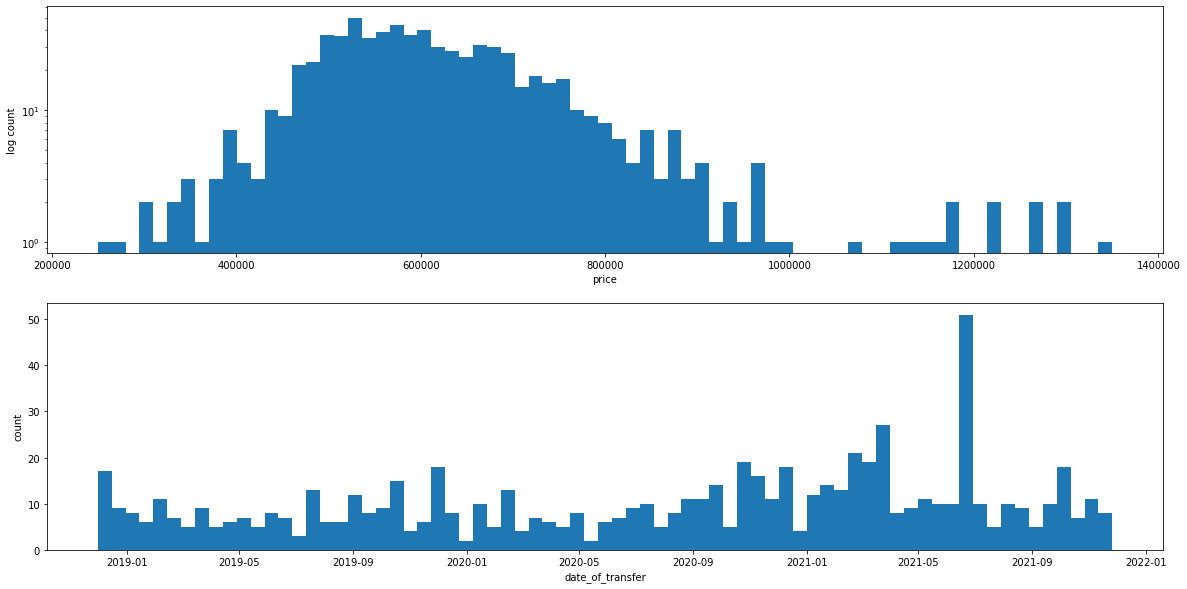



price plots for given property_type:



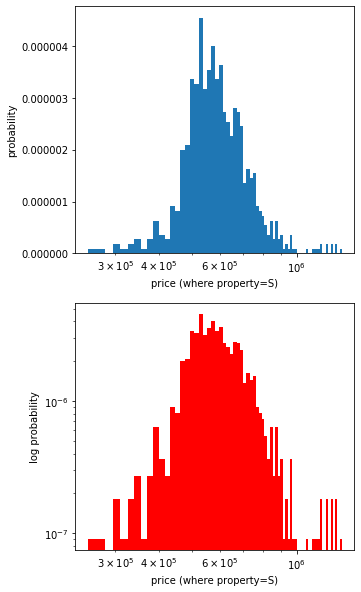



pppodata_latlong_distribution:



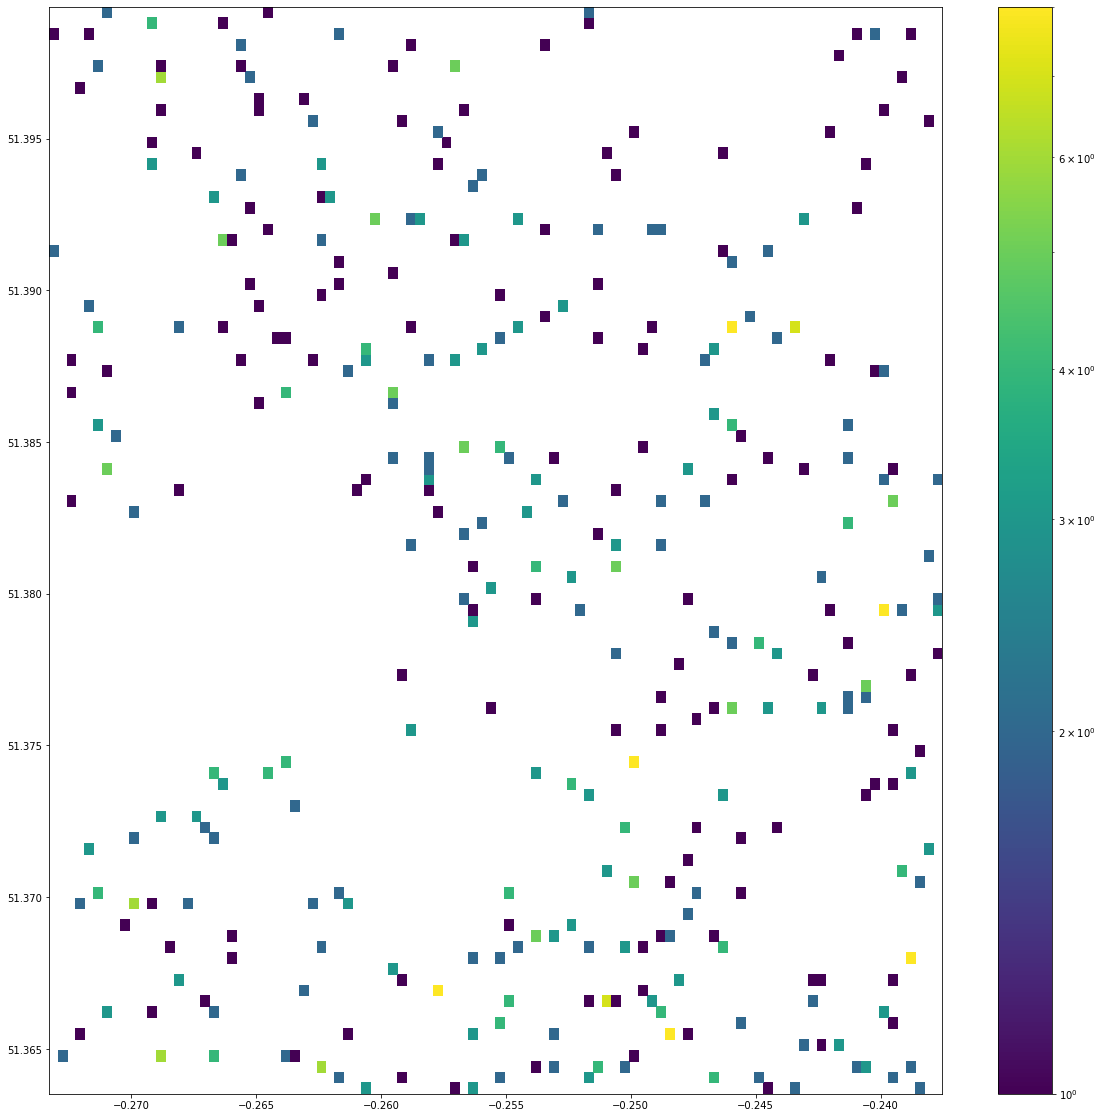



##########################################################################
# MAP AROUND PREDICTED PROPERTY (at the provided latitude and longitude) #
##########################################################################


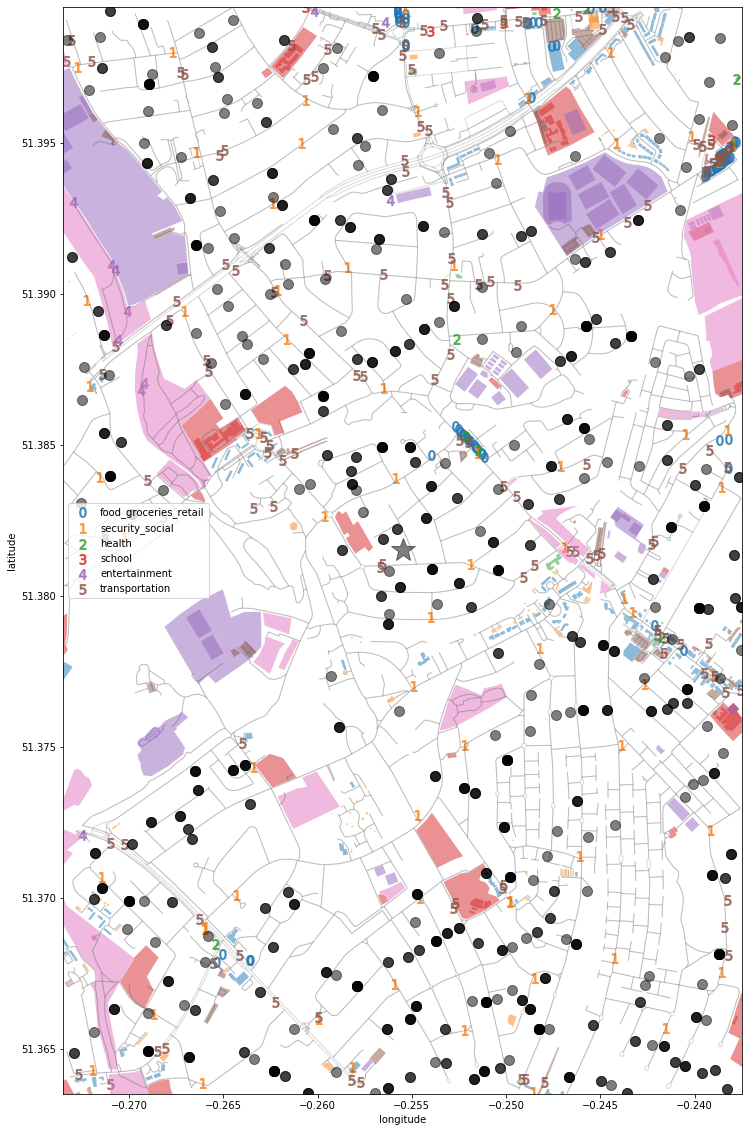


######################
# FEATURE GENERATION #
######################
Generating features...


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


########################
# MODEL AND PREDICTION #
########################

Training model (non-regularised)...

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     8.894
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           4.24e-18
Time:                        06:39:17   Log-Likelihood:                -9670.2
No. Observations:                 732   AIC:                         1.937e+04
Df Residuals:                     717   BIC:                         1.944e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [

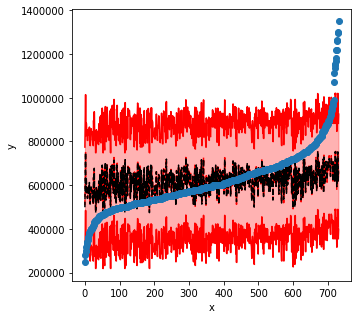


Prediction (non-regularised model; MSE=17463118085.182617):
           mean       mean_se  mean_ci_lower  mean_ci_upper   obs_ci_lower  \
0  666427.34892  16069.736405  634877.987543  697976.710296  402392.417178   

    obs_ci_upper  
0  930462.280661  

Prediction (regularised model; MSE=17494100138.362076):
0    663722.026553
dtype: float64



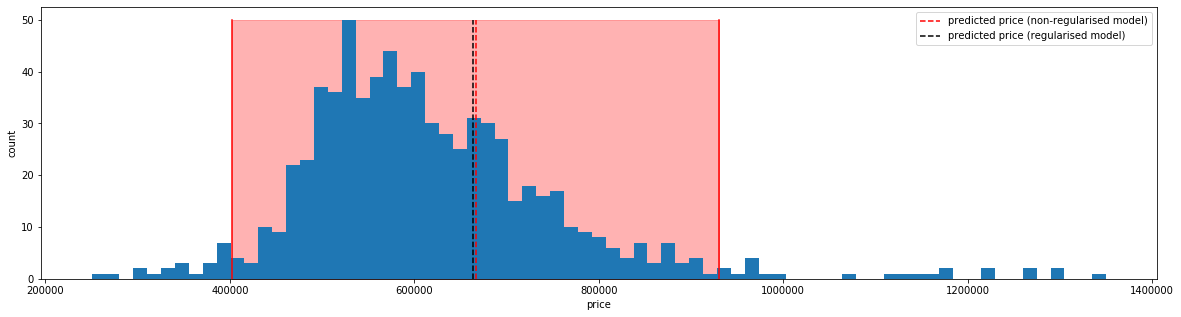

Outputting prediction of non-regularised model (red dotted line)


666427.34891969

In [41]:
address.predict_price(51.3815042, -0.2554954, "2021-11-29 00:00", "S")

## peak district
Other\
Latitude: 53.3967492\
Longitude: -1.7259923

In [42]:
address.predict_price(53.3967492, -1.7259923, "2021-11-29 00:00", "O")

The UUID for this prediction is: a3997852-178a-4463-ab5b-2aa95d179057. All saved figures will be labelled with this UUID.

#################
# FETCHING DATA #
#################
Querying rows from AWS...


  0%|          | 0/1 [00:00<?, ?it/s]

Exception: ignored

The UUID for this prediction is: 3a4067f3-dc94-407d-9335-816390e09c60. All saved figures will be labelled with this UUID.

#################
# FETCHING DATA #
#################
Querying rows from AWS...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 2 rows from AWS.
Getting POIs from OSM...


  0%|          | 0/1 [00:00<?, ?it/s]

Fetched 125 POIs in the bounding box around latitude=53.3967492, longitude=-1.7259923.
Getting edges from OSM for plotting...


/usr/local/lib/python3.8/dist-packages/fynesse/address.py:156: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  gdf_pois.drop("relation", inplace=True)


  0%|          | 0/1 [00:00<?, ?it/s]

Got edges from OSM for plotting.

################################
# CHARACTERISATION OF AWS ROWS #
################################
Number of rows: 2
Minimum price over all rows: 795000
Maximum price over all rows: 900000

ppdata_and_podata_distributions plot:



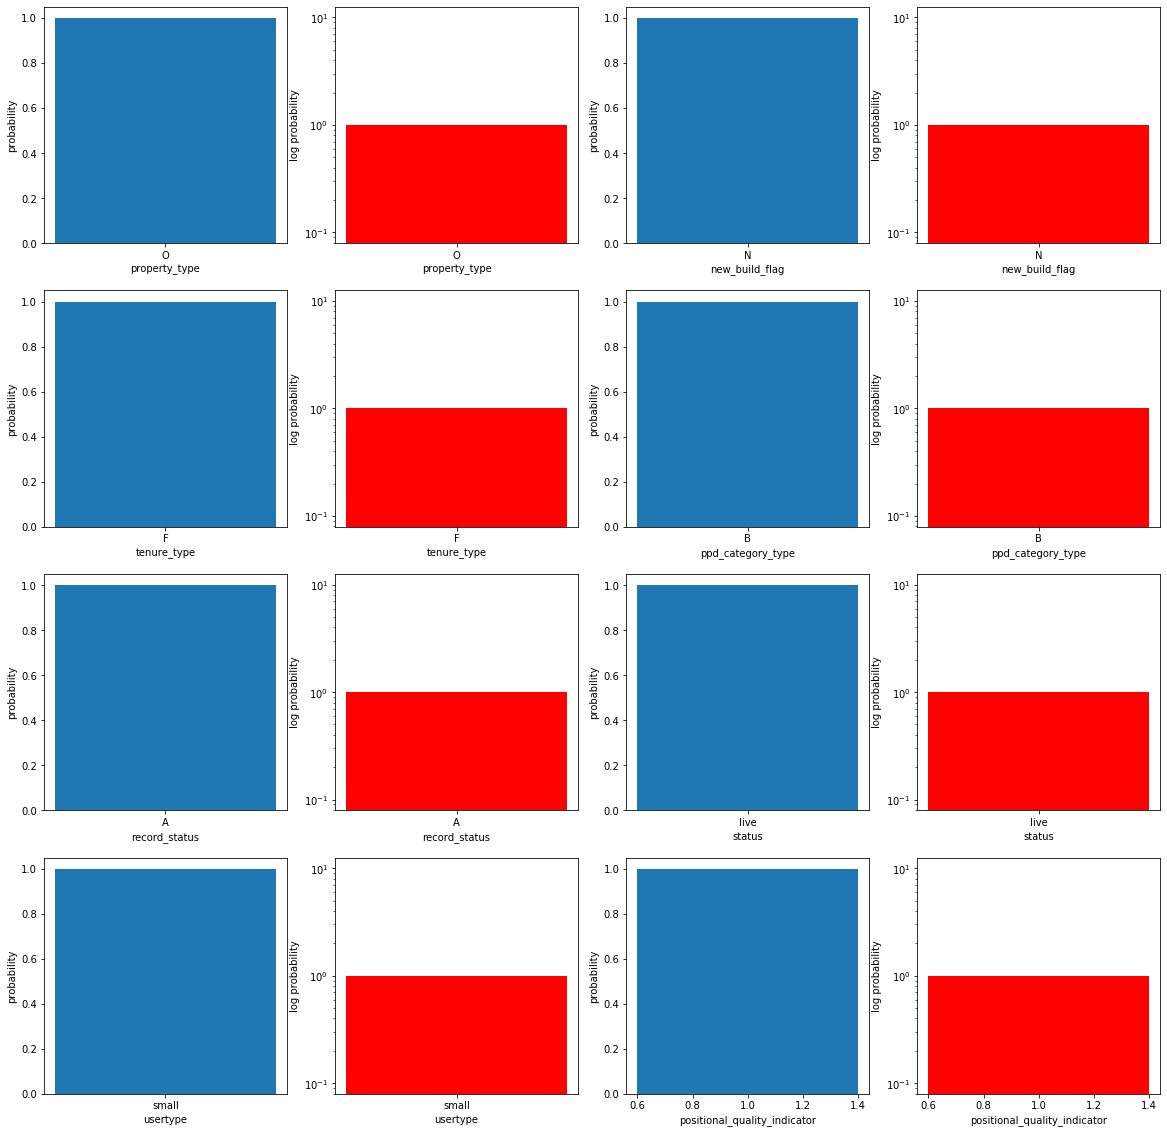



pppodata_distributions plot:



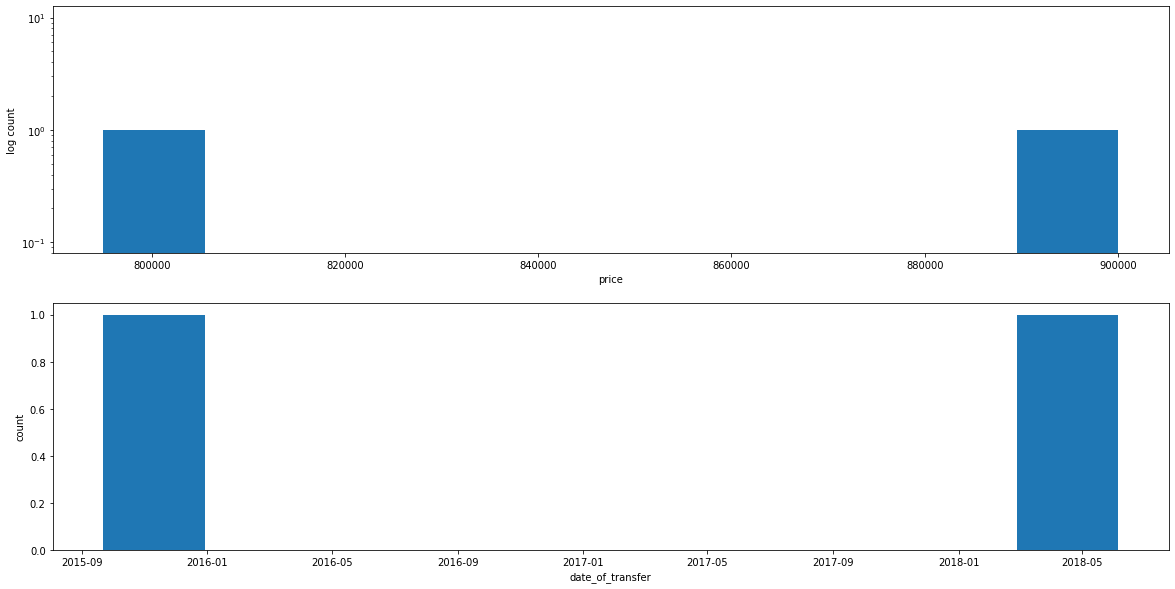



price plots for given property_type:



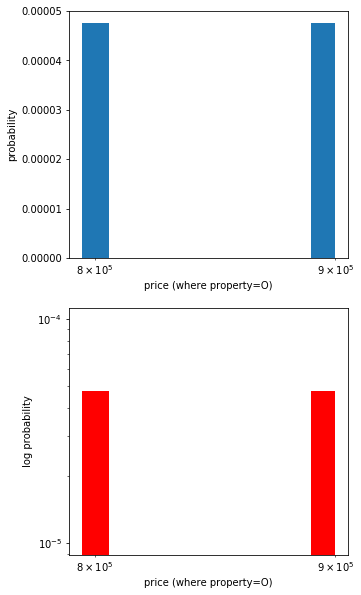



pppodata_latlong_distribution:



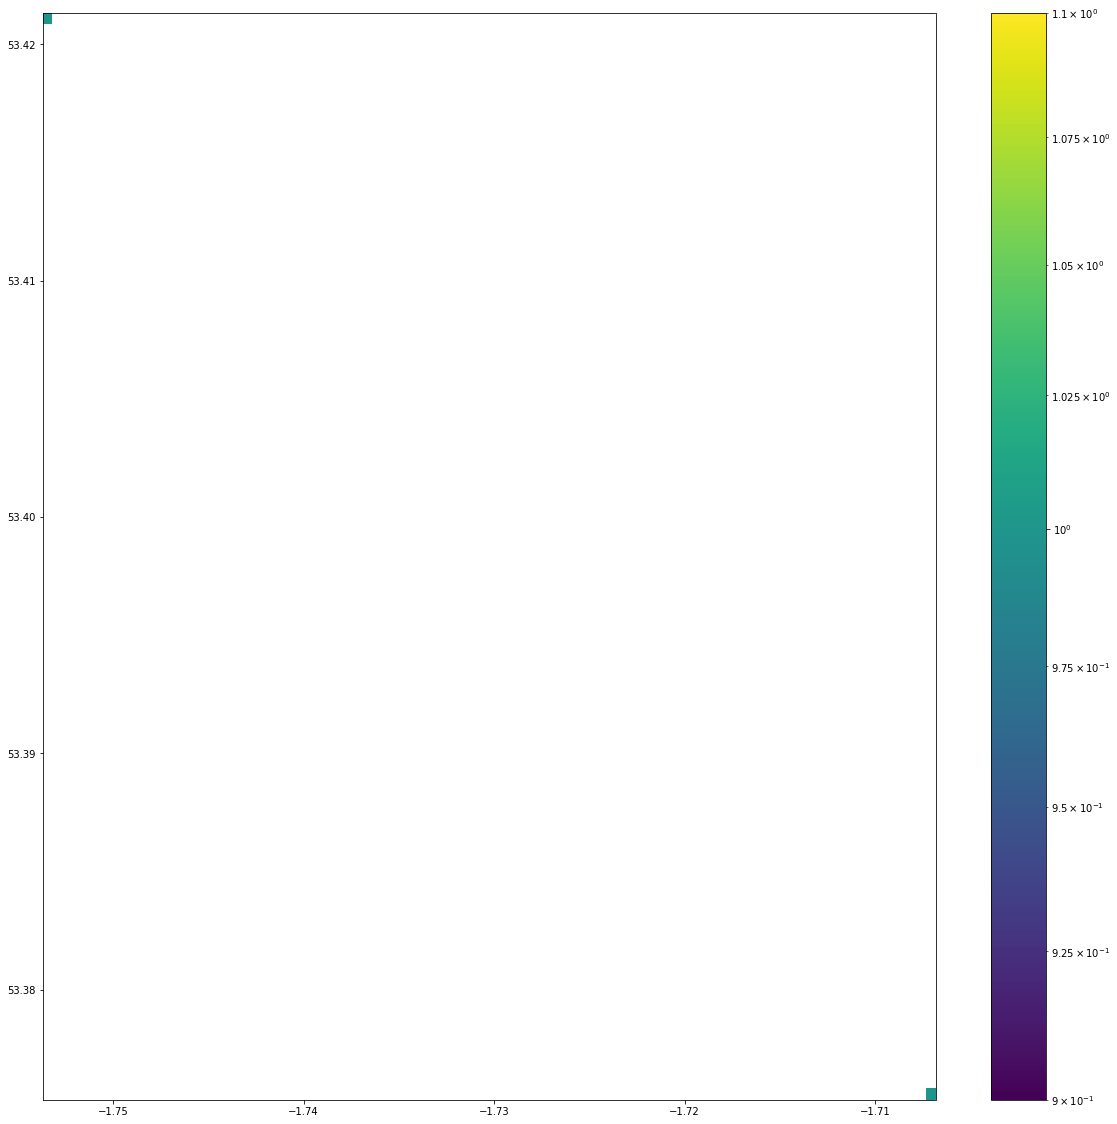



##########################################################################
# MAP AROUND PREDICTED PROPERTY (at the provided latitude and longitude) #
##########################################################################


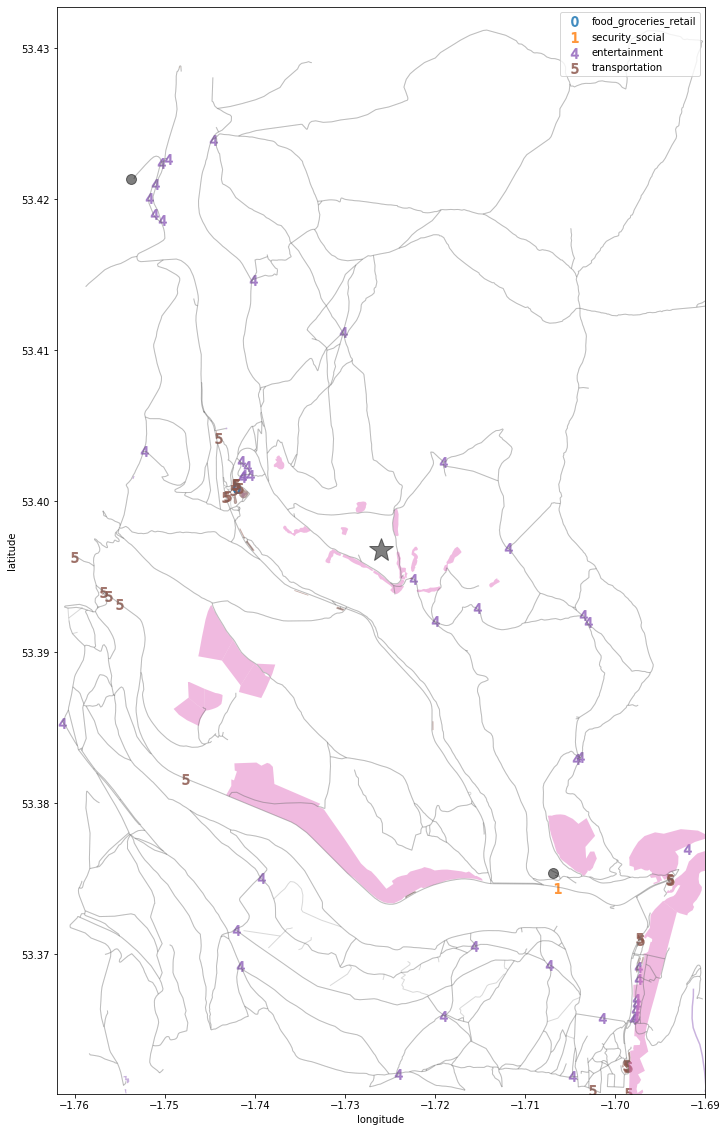


######################
# FEATURE GENERATION #
######################
Generating features...


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


########################
# MODEL AND PREDICTION #
########################

Training model (non-regularised)...

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 02 Dec 2022   Prob (F-statistic):                nan
Time:                        06:39:49   Log-Likelihood:                 38.735
No. Observations:                   2   AIC:                            -73.47
Df Residuals:                       0   BIC:                            -76.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:1452: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normal

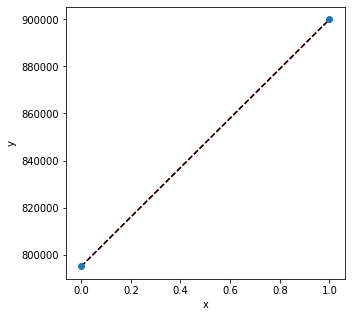

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:1452: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale



Prediction (non-regularised model; MSE=8.809142651444724e-19):
           mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  38321.354745      NaN            NaN            NaN           NaN   

   obs_ci_upper  
0           NaN  

Prediction (regularised model; MSE=252.545374469887):
0    657222.473871
dtype: float64



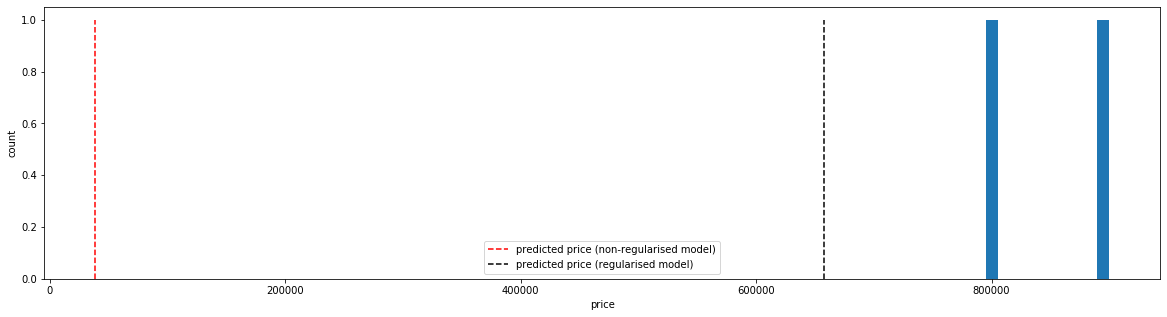

Outputting prediction of non-regularised model (red dotted line)


38321.354745071905

In [43]:
address.predict_price(53.3967492, -1.7259923, "2021-11-29 00:00", "O", box_width_km=4, box_height_km=4, num_years_history=10)